# 기술전형 1차(사전과제) - 임소연
# 과제 # 1. 데이터 분석
##### 데이터 분석 목적
- 한국 의료 패널 데이터 2014~2018년(5개년) 자료를 사용하여, 당뇨(만성질환) 보유자의 2019년 의료비 예측
- 개인의 인구통계학적 요인, 건강 상태, 의료 이용 내역 등을 고려하여 의료비 지출을 예측하고자 함.

## 1-1. 라이브러리 불러오기

In [1]:
# 파일 처리 라이브러리
import os # 운영체제와 상호작용하기 위한 라이브리리
from sas7bdat import SAS7BDAT  # SAS 데이터 파일(.sas7bdat)을 읽기 위한 라이브러리
import glob # 파일 경로 패턴을 사용하여 파일 목록을 찾는 라이브러리

# 데이터 처리 및 분석 라이브러리 
import numpy as np
import pandas as pd

# 데이터 분석 세부 설정
pd.set_option('display.max_columns', 100) # 최대 열 수 설정

# 시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt

# matplotlib 세부 설정
plt.rc('font', family='Malgun Gothic') # 폰트 설정
plt.rcParams['axes.unicode_minus'] = False # 마이너스 설정

# 시간 관련 기능 제공 모듈
import time

# 통계 라이브러리
from scipy import stats # 통계
from scipy.stats import kruskal # Kruskal-Wallis 검정 수행
from scipy.stats import kurtosis, skew # 첨도, 왜도
from statsmodels.stats.outliers_influence import variance_inflation_factor # 다중공선성 측정

# 모델링
from sklearn.preprocessing import StandardScaler # 표준화
from sklearn.linear_model import LinearRegression, Ridge, Lasso # 선형회귀모델 / 릿지 / 라쏘
import statsmodels.api as sm # 통계 모델링 
from sklearn.ensemble import RandomForestRegressor  # Random Forest
from xgboost import XGBRegressor # XGBoost
from sklearn.model_selection import GridSearchCV # 하이퍼 파라미터 튜닝 라이브리리
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # 회귀 성능평가 지표

In [2]:
# 경로 확인
os.getcwd()

'C:\\Users\\ssyyy\\Desktop\\사전과제\\변수'

## 1-2. 데이터 불러오기

In [82]:
# 파일 경로 패턴 설정
file_pattern = "../기술전형 1차 - Data Scientist - Dataset/t*.sas7bdat"

# 모든 파일 경로 가져오기
file_list = glob.glob(file_pattern)

# 전체 시간 측정 시작
start_time = time.time()

# 각 파일을 읽어 각각의 데이터프레임으로 저장
for file_path in file_list:
    file_start_time = time.time()  # 각 파일 읽기 시작 시간
    
    with SAS7BDAT(file_path) as f:
        df = f.to_data_frame()
        
        # 파일 이름 추출
        file_name = file_path.split('-')[2].split('\\')[1].split('.')[0][1:] # 예 : 14cd
        
        # 키 생성
        key = f'df_{file_name}'  # 예: df_14ind, df_16ou
        print(key)  # 생성된 키 출력
        
        # 전역 변수에 저장
        globals()[key] = df  # 전역 변수에 저장

    # 각 파일 읽기 소요 시간 측정
    file_end_time = time.time()
    print(f"Time taken to read {file_path}: {file_end_time - file_start_time:.2f} seconds")

# 전체 시간 측정 종료
end_time = time.time()
print(f"\nTotal time taken to read all files: {end_time - start_time:.2f} seconds")

df_14appen
Time taken to read ../기술전형 1차 - Data Scientist - Dataset\t14appen.sas7bdat: 1.87 seconds
df_14cd
Time taken to read ../기술전형 1차 - Data Scientist - Dataset\t14cd.sas7bdat: 5.52 seconds
df_14er
Time taken to read ../기술전형 1차 - Data Scientist - Dataset\t14er.sas7bdat: 0.16 seconds
df_14hh
Time taken to read ../기술전형 1차 - Data Scientist - Dataset\t14hh.sas7bdat: 0.77 seconds
df_14in
Time taken to read ../기술전형 1차 - Data Scientist - Dataset\t14in.sas7bdat: 0.35 seconds
df_14ind
Time taken to read ../기술전형 1차 - Data Scientist - Dataset\t14ind.sas7bdat: 3.08 seconds
df_14ou
Time taken to read ../기술전형 1차 - Data Scientist - Dataset\t14ou.sas7bdat: 34.12 seconds
df_15appen
Time taken to read ../기술전형 1차 - Data Scientist - Dataset\t15appen.sas7bdat: 1.68 seconds
df_15cd
Time taken to read ../기술전형 1차 - Data Scientist - Dataset\t15cd.sas7bdat: 4.93 seconds
df_15er
Time taken to read ../기술전형 1차 - Data Scientist - Dataset\t15er.sas7bdat: 0.15 seconds
df_15hh
Time taken to read ../기술전형 1차 - Data 

## 1-3. 데이터 통합
- 목적 : 여러 개의 테이블을 통합하여 개인지출의료비(I_MEDICALEXP1)를 예측할 수 있는 분석용 데이터셋 생성
- 가구, 만성 질환 여부, 의료 이용 내역 등 데이터를 결합함.
<br>

##### <strong>테이블 정보 및 주요 변수</strong>
- hh : 가구정보 ( 가구 가중치, 일반 사항, 주거 형태, 가구 소득 및 지출, 의료 관련 지출)

- ind : 가구원 정보 ( 가구원 가중치, 변동사항, 일반 사항, 경제활동 상태, 의료 이용 여부, 임신 및 출산(

- cd : 만성 질환 ( 만성질환코드, 의사 진단 여부 및 시기, 복약순응, 월평균약값 및 약제비 부담수준)

- er : 응급서비스 이용 ( 응급의료이용 내역, 수납금액 및 처방약 값, 의료비 재원, 만족도)

- in : 입원서비스 이용 ( 입원의료이용 내역, 입원결정, 수납금액 및 약값, 의료비 재원, 만족도, 간병)

- ou : 외래 서비스 이용 ( 외래의료이용 내역, 수납금액 및 처방약 값, 의료비 재원, 검진 및 발견질병 등)

- appen : 흡연, 음주, 신체활동, 정신건강, 삶의 질, 활동 제한, 의료접근성, 환자경험

- I_MEDICAL_EXP1 : 개인지출의료비 (응급 의료비 + 입원 의료비 + 외래 의료비 + 응급 처방약 값 + 입원 처방약 값 + 외래처방약 값)

#### 1. CD(만성질환)
1) 데이터 필터링
- 목적 : 의료비 예측 대상자를 당뇨 보유자로 제한
- 만성질환 데이터에서 당뇨 보유자만 필터링 한 후 EDA를 진행함.

In [83]:
# ‘CD3_2(의사진단여부)' 의 값과 개수 출력
# -1 :해당 사항 없음, 1 : 예, 2: 아니오
df_14cd['CD3_2'].value_counts()

CD3_2
-1.0    125679
 1.0     29521
 2.0       102
Name: count, dtype: int64

In [84]:
# ‘CDNUM(만성질환번호)’의 값과 개수 출력
# CDNUM : 2(당뇨)
df_14cd['CDNUM'].value_counts()

CDNUM
1.0     19219
2.0     19219
3.0     19219
4.0     19219
5.0     19219
6.0     19219
7.0     19219
8.0      9503
9.0      5060
10.0     2786
11.0     1560
12.0      872
13.0      488
14.0      268
15.0      132
16.0       61
17.0       22
18.0       10
19.0        4
20.0        2
21.0        1
Name: count, dtype: int64

In [85]:
# 당뇨 보유자를 필터링하는 함수
def diabetes(data):
    # 당뇨 환자 : ‘CD3_2(의사진단여부)’ 확인의 ‘(1) 예’ 값, ‘CDNUM(만성질환번호)’의 ‘(2) 당뇨’ 값
    df = data[(data['CD3_2'] == 1) & (data['CDNUM'] == 2)] 
    print(df.shape) # 데이터 프레임 형태 확인
    return df

In [86]:
# 특정 열을 선택하여 새로운 데이터 프레임을 생성하는 함수 
def select_cols(data, selected_cols):
    # selected_cols를 사용하여 선택된 컬럼으로 DataFrame 생성
    df = data[selected_cols]  
    return df

In [87]:
# 당뇨(만성질환)보유자 필터링
df_14cd = diabetes(df_14cd)
df_15cd = diabetes(df_15cd)
df_16cd = diabetes(df_16cd)
df_17cd = diabetes(df_17cd)
df_18cd = diabetes(df_18cd)

(1404, 22)
(1406, 22)
(1431, 22)
(1505, 22)
(1555, 22)


In [88]:
# 각 컬럼의 속성 및 결측치 확인
df_14cd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1404 entries, 13 to 155296
Data columns (total 22 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   HHIDWON  1404 non-null   float64
 1   M1       1404 non-null   float64
 2   M2       1404 non-null   float64
 3   HHID     1404 non-null   float64
 4   PID      1404 non-null   float64
 5   PIDWON   1404 non-null   float64
 6   HPID     1404 non-null   float64
 7   CDNUM    1404 non-null   float64
 8   cd1_1    1404 non-null   object 
 9   CD2      1404 non-null   float64
 10  CD3_2    1404 non-null   float64
 11  CD3_1    1404 non-null   float64
 12  CD3      1404 non-null   float64
 13  CD4      1404 non-null   float64
 14  CD5      1404 non-null   float64
 15  CD6      1404 non-null   float64
 16  CD9      1404 non-null   float64
 17  CD10     1404 non-null   float64
 18  CD11     1404 non-null   float64
 19  CD12_0   1404 non-null   float64
 20  CD12     1404 non-null   float64
 21  CD19     1404 no

In [89]:
# 데이터 고윳값 확인
## 예측 모델에서 기여하지 않는 변수(고윳값이 1인 경우)를 분석에서 제외함
df_14cd.nunique().sort_values()

CD3_2         1
CD12_0        1
M2            1
CDNUM         1
cd1_1         1
CD2           1
CD12          1
CD5           3
CD4           3
CD11          4
CD9           4
CD19          6
CD6           8
CD10          8
PID           9
M1            9
CD3_1        38
CD3          51
HHIDWON    1292
HHID       1295
HPID       1404
PIDWON     1404
dtype: int64

In [90]:
# 해당 질병으로 인한 의료 이용 여부의 값과 개수 출력
## (1) : 예 (2) : 아니요 (-9) : 모름 / 무응답
df_14cd['CD4'].value_counts().head(4)

CD4
 1.0    1340
 2.0      63
-9.0       1
Name: count, dtype: int64

In [91]:
# 진단시기(년도)의 값과 개수 출력
## (-1) : 해당 사항 없음, (숫자) : 진단받은 년도
## 진단 받은 환자를 대상으로 추출했지만, (-1) : 해당 사항이 없는 응답이 나타남. 
df_14cd['CD3_1'].value_counts().head(4)

CD3_1
-1.0       307
 2012.0    111
 2011.0    103
 2013.0    101
Name: count, dtype: int64

In [92]:
# 진단시기(연령)의 값과 개수 출력
## (-1) : 해당 사항 없음, (숫자) : 진단받은 연령
## 진단 받은 환자를 대상으로 추출했지만, (-1) : 해당 사항이 없는 응답이 나타남. 
df_14cd['CD3'].value_counts().head(4)

CD3
-1.0     1097
 60.0      21
 55.0      15
 52.0      14
Name: count, dtype: int64

In [93]:
# 의약품 복용 여부의 값과 개수 출력
## (1) : 예, (2) : 아니요, (-9) : 모름 / 무응답
df_14cd['CD5'].value_counts().head(4)

CD5
 1.0    1330
 2.0      73
-9.0       1
Name: count, dtype: int64

##### 2. 만성질환자 변수 선택

1. 선택 변수
- PIDWON : 가구원 고유 번호
- CD3 : 진단시기(연령)
- CD3_1 : 진단시기(년도)
- CD4 : 질병으로 인한 의료이용 여부 
- CD5 : 의약품 복용여부 

In [94]:
# 연도 목록 생성
years = [2014, 2015, 2016, 2017, 2018]  # 각 DataFrame에 추가할 연도 목록

# 추출할 열 목록 정의
lst_cd_columns = ['PIDWON', 'CD3','CD3_1', 'CD4', 'CD5']  # 필요한 열 이름 리스트

# 각 DataFrame에서 지정한 열을 선택하고 연도를 추가
df_14cd1 = select_cols(df_14cd, lst_cd_columns).assign(year=years[0])  # 2014년 데이터
df_15cd1 = select_cols(df_15cd, lst_cd_columns).assign(year=years[1])  # 2015년 데이터
df_16cd1 = select_cols(df_16cd, lst_cd_columns).assign(year=years[2])  # 2016년 데이터
df_17cd1 = select_cols(df_17cd, lst_cd_columns).assign(year=years[3])  # 2017년 데이터
df_18cd1 = select_cols(df_18cd, lst_cd_columns).assign(year=years[4])  # 2018년 데이터

In [95]:
df_14cd1.shape, df_15cd1.shape, df_16cd1.shape, df_17cd1.shape, df_18cd1.shape

((1404, 6), (1406, 6), (1431, 6), (1505, 6), (1555, 6))

##### 3. 만성질환자 데이터 생성
- 가구원 단위(PIDWON)로 연도별 만성질환 정보를 통합

In [96]:
# DataFrame 합치기
df_cd = pd.concat([df_14cd1, df_15cd1, df_16cd1, df_17cd1, df_18cd1], ignore_index=True)
df_cd

,PIDWON,CD3,CD3_1,CD4,CD5,year
0,1000402.0,-1.0,2010.0,2.0,2.0,2014
1,1000601.0,-1.0,2011.0,1.0,1.0,2014
2,1000602.0,-1.0,2013.0,1.0,1.0,2014
3,1003301.0,-1.0,2012.0,1.0,1.0,2014
4,1003302.0,-1.0,2003.0,1.0,1.0,2014
...,...,...,...,...,...,...
7296,3251201.0,-1.0,2012.0,1.0,1.0,2018
7297,3251601.0,-1.0,2011.0,1.0,1.0,2018
7298,3251706.0,-1.0,2000.0,1.0,1.0,2018
7299,3300304.0,-1.0,2008.0,1.0,1.0,2018


#### 2. IND(가구원 정보)
1. 데이터 필터링
- 개인 특성: 연령, 성별, 교육 수준 등 당뇨 환자의 인구학적 특성을 고려
- 경제적 요인: 가구소득, 의료비 부담 정도 등 의료비 예측과 관련된 변수 포함
- 당뇨 보유자 식별: 당뇨병 진단 여부를 기준으로 데이터를 필터링

In [97]:
# 당뇨 보유자 데이터 추출 함수
def extract_diabetes(data, lst_pidwon):
    df = data[data['PIDWON'].isin(lst_pidwon)] # 당뇨 보유자의 가구원 고유번호가 포함되어 있다면 데이터프레임 생성
    return df

In [98]:
# 당뇨 보유자 가구원 정보 추출
df_14ind1 = extract_diabetes(df_14ind, list(df_14cd1['PIDWON']))
df_15ind1 = extract_diabetes(df_15ind, list(df_15cd1['PIDWON']))
df_16ind1 = extract_diabetes(df_16ind, list(df_16cd1['PIDWON']))
df_17ind1 = extract_diabetes(df_17ind, list(df_17cd1['PIDWON']))
df_18ind1 = extract_diabetes(df_18ind, list(df_18cd1['PIDWON']))

In [99]:
# 각 컬럼의 속성 및 결측치 확인
## 가중치, 소득 관련 변수에서 결측치가 나타남
df_14ind1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1404 entries, 1 to 19218
Data columns (total 95 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   HHIDWON          1404 non-null   float64
 1   M1               1404 non-null   float64
 2   M2               1404 non-null   float64
 3   HHID             1404 non-null   float64
 4   PID              1404 non-null   float64
 5   PIDWON           1404 non-null   float64
 6   HPID             1404 non-null   float64
 7   I_WGC_08         1061 non-null   float64
 8   I_WGC_TOT        1404 non-null   float64
 9   WGL_08           1061 non-null   float64
 10  WGL_TOT          1404 non-null   float64
 11  WGL_M_08         1015 non-null   float64
 12  WGL_M_TOT        1372 non-null   float64
 13  A2               1404 non-null   float64
 14  A2_0             1404 non-null   float64
 15  A2_1             1404 non-null   float64
 16  A2_2             1404 non-null   float64
 17  A3               1

##### 2. 가구원 변수 선택

1. 선택 변수
- PIDWON : 가구원 고유 번호
- C3 : 성별
- C4_0 : 출생 년도
- C8 : 교육 수준
- C11 : 의료보장형태
- C24 : 경제활동유무
- C41 : 3개월 이상 생활 / 건강증진 의약품 복용
- TOTAL_Q5_08 : 총 가구소득 5분위 원표본
- I_MEDICALEXP1 : 개인지출 의료비

In [100]:
# 연도 목록 생성
years = [2014, 2015, 2016, 2017, 2018]  # 각 DataFrame에 추가할 연도 목록

# 추출할 열 목록 정의
lst_ind_columns = ['PIDWON','C3', 'C4_0', 'C8', 'C11', 'C24', 'C41','TOTAL_Q5_08', 'I_MEDICALEXP1']  # 필요한 열 이름 리스트

# 각 DataFrame에서 지정한 열을 선택하고 연도를 추가
df_14ind2 = select_cols(df_14ind1, lst_ind_columns).assign(year=years[0])  # 2014년 데이터
df_15ind2 = select_cols(df_15ind1, lst_ind_columns).assign(year=years[1])  # 2015년 데이터
df_16ind2 = select_cols(df_16ind1, lst_ind_columns).assign(year=years[2])  # 2016년 데이터
df_17ind2 = select_cols(df_17ind1, lst_ind_columns).assign(year=years[3])  # 2017년 데이터
df_18ind2 = select_cols(df_18ind1, lst_ind_columns).assign(year=years[4])  # 2018년 데이터

In [101]:
# 컬럼 추출 전
df_14ind1.shape, df_15ind1.shape, df_16ind1.shape, df_17ind1.shape, df_18ind1.shape

((1404, 95), (1406, 95), (1431, 95), (1505, 93), (1555, 92))

In [102]:
# 컬럼 추출 후
df_14ind2.shape, df_15ind2.shape, df_16ind2.shape, df_17ind2.shape, df_18ind2.shape

((1404, 10), (1406, 10), (1431, 10), (1505, 10), (1555, 10))

##### 3. 가구원 데이터 생성
- 가구원 단위(PIDWON)로 연도별 개인 특성과 경제적 요인 등을 통합

In [103]:
# ind DataFrame 합치기
df_ind = pd.concat([df_14ind2, df_15ind2, df_16ind2, df_17ind2, df_18ind2], ignore_index=True)
df_ind

,PIDWON,C3,C4_0,C8,C11,C24,C41,TOTAL_Q5_08,I_MEDICALEXP1,year
0,1000402.0,1.0,1953.0,51.0,3.0,1.0,2.0,4.0,10067300.0,2014
1,1000601.0,1.0,1955.0,44.0,3.0,1.0,2.0,3.0,254750.0,2014
2,1000602.0,2.0,1956.0,16.0,3.0,1.0,2.0,3.0,1596730.0,2014
3,1003301.0,1.0,1961.0,33.0,2.0,1.0,2.0,5.0,266010.0,2014
4,1003302.0,2.0,1967.0,33.0,2.0,2.0,2.0,5.0,872758.0,2014
...,...,...,...,...,...,...,...,...,...,...
7296,3251201.0,1.0,1952.0,16.0,3.0,2.0,2.0,NaN,467400.0,2018
7297,3251601.0,1.0,1948.0,44.0,2.0,2.0,2.0,NaN,220160.0,2018
7298,3251706.0,2.0,1932.0,3.0,2.0,2.0,2.0,NaN,5384290.0,2018
7299,3300304.0,1.0,1950.0,16.0,2.0,2.0,2.0,NaN,918230.0,2018


In [104]:
df_ind['PIDWON'].nunique()

1865

#### 3. ER(응급서비스 이용)
- 당뇨 보유자의 응급 서비스 이용 내역을 포함

In [105]:
# 각 컬럼의 속성 및 결측치 확인 
df_14er.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2241 entries, 0 to 2240
Data columns (total 48 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   HHIDWON  2241 non-null   float64
 1   M1       2241 non-null   float64
 2   M2       2241 non-null   float64
 3   HHID     2241 non-null   float64
 4   PID      2241 non-null   float64
 5   PIDWON   2241 non-null   float64
 6   HPID     2241 non-null   float64
 7   ROUND    2241 non-null   float64
 8   ERCOUNT  2241 non-null   float64
 9   ERNUM    2241 non-null   float64
 10  ER4      2241 non-null   float64
 11  ER5      2241 non-null   float64
 12  ER6      2241 non-null   float64
 13  ER7      2241 non-null   float64
 14  ER8      2241 non-null   float64
 15  ER9      2241 non-null   float64
 16  ER10     2241 non-null   float64
 17  ER12     2241 non-null   float64
 18  ER13     2241 non-null   float64
 19  ER15     2241 non-null   float64
 20  ER16     2241 non-null   float64
 21  ER17_1   2241 

##### 1. 데이터 필터링

In [106]:
# 당뇨 보유자 응급서비스 내역 추출
df_14er1 = extract_diabetes(df_14er, list(df_14cd1['PIDWON']))
df_15er1 = extract_diabetes(df_15er, list(df_15cd1['PIDWON']))
df_16er1 = extract_diabetes(df_16er, list(df_16cd1['PIDWON']))
df_17er1 = extract_diabetes(df_17er, list(df_17cd1['PIDWON']))
df_18er1 = extract_diabetes(df_18er, list(df_18cd1['PIDWON']))

##### 2. 응급서비스 변수 선택
- 가구원 단위(PIDWON)를 기준으로 응급실 이용 내역을 포함함.

1. 선택 변수
- PIDWON : 가구원 고유 번호
- ER26_5 : 총 진료비
- ER33 : 처방약 값

In [107]:
# 추출할 열 목록 정의
lst_er_columns = ['PIDWON','ER26_5','ER33']  # 필요한 열 이름 리스트

# 각 DataFrame에서 지정한 열을 선택하고 연도를 추가
df_14er2 = select_cols(df_14er1, lst_er_columns) 
df_15er2 = select_cols(df_15er1, lst_er_columns)
df_16er2 = select_cols(df_16er1, lst_er_columns)
df_17er2 = select_cols(df_17er1, lst_er_columns)
df_18er2 = select_cols(df_18er1, lst_er_columns)

##### ER26_5 : 총 진료비
- 동일 가구원이 응급실을 여러 번 이용할 수 있음.
- 의료비 예측을 위한 주요 변수 중 하나로 가구원 별 총 진료비 활용함 
- (-1) 해당 없음, (-9) 무응답 -> 0으로 대체

In [108]:
df_14er2['ER26_5'].value_counts()

ER26_5
-1.0         95
-9.0          9
 13050.0      2
 28990.0      2
 23846.0      2
             ..
 194642.0     1
 196762.0     1
 124963.0     1
 81997.0      1
 15720.0      1
Name: count, Length: 148, dtype: int64

##### ER33 : 처방약 값
- 동일 가구원이 응급실을 여러 번 이용할 수 있음.
- 의료비 예측을 위한 주요 변수 중 하나로 가구원 별 총 처방약값 활용함 
- (-1) 해당 없음  -> 0으로 대체

In [109]:
df_14er2['ER33'].value_counts()

ER33
-1.0        236
 0.0          4
 3490.0       1
 4160.0       1
 2400.0       1
 6300.0       1
 24000.0      1
 2300.0       1
 7500.0       1
 3200.0       1
 3600.0       1
 3500.0       1
 1700.0       1
 1900.0       1
 4000.0       1
Name: count, dtype: int64

In [110]:
# 연도 목록 생성
years = [2014, 2015, 2016, 2017, 2018]  # 각 DataFrame에 추가할 연도 목록

##### 3. 응급 서비스 이용 내역 집계

In [111]:
# 해당 없음(-1), 무응답(-9) 데이터를 0으로 대체함 
df_14er2.loc[:,'ER33'] = df_14er2['ER33'].replace(-1, 0)
df_14er2.loc[:,'ER26_5'] = df_14er2['ER26_5'].replace([-1, -9], 0)

# 데이터를 그룹화하여 가구원 단위로 집계
df_14er3 = df_14er2.groupby('PIDWON').agg({'ER33':'sum', 'ER26_5':'sum'}).reset_index()
df_14er3 = df_14er3.assign(year=years[0])
df_14er3

,PIDWON,ER33,ER26_5,year
0,1000602.0,3490.0,213467.0,2014
1,1004201.0,0.0,0.0,2014
2,1005002.0,0.0,128985.0,2014
3,1007401.0,0.0,528875.0,2014
4,1024901.0,0.0,315823.0,2014
...,...,...,...,...
168,3210002.0,0.0,161597.0,2014
169,3225401.0,0.0,0.0,2014
170,3229302.0,0.0,93640.0,2014
171,3235902.0,0.0,0.0,2014


In [112]:
# 해당 없음(-1), 무응답(-9) 데이터를 0으로 대체함 
df_15er2.loc[:,'ER33'] = df_15er2['ER33'].replace(-1, 0)
df_15er2.loc[:,'ER26_5'] = df_15er2['ER26_5'].replace([-1, -9], 0)

# 데이터를 그룹화하여 가구원 단위로 집계
df_15er3 = df_15er2.groupby('PIDWON').agg({'ER33':'sum', 'ER26_5':'sum'}).reset_index()
df_15er3 = df_15er3.assign(year=years[1])
df_15er3

,PIDWON,ER33,ER26_5,year
0,1003602.0,0.0,180630.0,2015
1,1008201.0,0.0,262994.0,2015
2,1010805.0,0.0,1236794.0,2015
3,1040001.0,0.0,111592.0,2015
4,1043402.0,1200.0,32544.0,2015
...,...,...,...,...
186,3235801.0,0.0,443456.0,2015
187,3235902.0,0.0,0.0,2015
188,3240601.0,0.0,0.0,2015
189,3246401.0,0.0,0.0,2015


In [113]:
# 해당 없음(-1), 무응답(-9) 데이터를 0으로 대체함 
df_16er2.loc[:,'ER33'] = df_16er2['ER33'].replace(-1, 0)
df_16er2.loc[:,'ER26_5'] = df_16er2['ER26_5'].replace([-1, -9], 0)

# 데이터를 그룹화하여 가구원 단위로 집계
df_16er3 = df_16er2.groupby('PIDWON').agg({'ER33':'sum', 'ER26_5':'sum'}).reset_index()
df_16er3 = df_16er3.assign(year=years[2])
df_16er3

,PIDWON,ER33,ER26_5,year
0,1005002.0,0.0,1511403.0,2016
1,1011602.0,0.0,323181.0,2016
2,1019801.0,0.0,85852.0,2016
3,1022606.0,0.0,169035.0,2016
4,1028701.0,0.0,19720.0,2016
...,...,...,...,...
166,3235601.0,0.0,630815.0,2016
167,3236701.0,500.0,73861.0,2016
168,3242201.0,0.0,317600.0,2016
169,3243402.0,0.0,0.0,2016


In [114]:
# 해당 없음(-1), 무응답(-9) 데이터를 0으로 대체함 
df_17er2.loc[:,'ER33'] = df_17er2['ER33'].replace(-1, 0)
df_17er2.loc[:,'ER26_5'] = df_17er2['ER26_5'].replace([-1, -9], 0)

# 데이터를 그룹화하여 가구원 단위로 집계
df_17er3 = df_17er2.groupby('PIDWON').agg({'ER33':'sum', 'ER26_5':'sum'}).reset_index()
df_17er3 = df_17er3.assign(year=years[3])
df_17er3

,PIDWON,ER33,ER26_5,year
0,1003302.0,0.0,283259.0,2017
1,1007402.0,0.0,168674.0,2017
2,1046402.0,0.0,109377.0,2017
3,1069102.0,0.0,0.0,2017
4,1069702.0,0.0,150336.0,2017
...,...,...,...,...
202,3240601.0,0.0,43310.0,2017
203,3242202.0,0.0,0.0,2017
204,3249301.0,0.0,229533.0,2017
205,3250501.0,0.0,0.0,2017


In [115]:
# 해당 없음(-1), 무응답(-9) 데이터를 0으로 대체함 
df_18er2.loc[:,'ER33'] = df_18er2['ER33'].replace(-1, 0)
df_18er2.loc[:,'ER26_5'] = df_18er2['ER26_5'].replace([-1, -9], 0)

# 데이터를 그룹화하여 가구원 단위로 집계
df_18er3 = df_18er2.groupby('PIDWON').agg({'ER33':'sum', 'ER26_5':'sum'}).reset_index()
df_18er3 = df_18er3.assign(year=years[4])
df_18er3

,PIDWON,ER33,ER26_5,year
0,1005002.0,0.0,75752.0,2018
1,1010805.0,0.0,0.0,2018
2,1017801.0,0.0,259888.0,2018
3,1017802.0,0.0,89058.0,2018
4,1018101.0,0.0,0.0,2018
...,...,...,...,...
226,3235801.0,0.0,299821.0,2018
227,3235902.0,0.0,266541.0,2018
228,3245001.0,0.0,251340.0,2018
229,3247902.0,0.0,0.0,2018


In [116]:
# 데이터 처리 전
df_14er1.shape, df_15er1.shape, df_16er1.shape, df_17er1.shape, df_18er1.shape

((253, 48), (293, 48), (248, 48), (320, 48), (354, 48))

In [117]:
# 데이터 처리 후
df_14er3.shape, df_15er3.shape, df_16er3.shape, df_17er3.shape, df_18er3.shape

((173, 4), (191, 4), (171, 4), (207, 4), (231, 4))

4. 응급실 서비스 데이터 생성
- 가구원 단위(PIDWON)로 연도별 총 응급실 진료비, 처방약 값 통합

In [118]:
df_er = pd.concat([df_14er3, df_15er3, df_16er3, df_17er3, df_18er3], ignore_index=True)
df_er

,PIDWON,ER33,ER26_5,year
0,1000602.0,3490.0,213467.0,2014
1,1004201.0,0.0,0.0,2014
2,1005002.0,0.0,128985.0,2014
3,1007401.0,0.0,528875.0,2014
4,1024901.0,0.0,315823.0,2014
...,...,...,...,...
968,3235801.0,0.0,299821.0,2018
969,3235902.0,0.0,266541.0,2018
970,3245001.0,0.0,251340.0,2018
971,3247902.0,0.0,0.0,2018


In [119]:
# 응급 서비스 총 진료비
df_er['ER26_5'].value_counts()

ER26_5
0.0         359
19530.0       2
70771.0       2
767118.0      1
123432.0      1
           ... 
223890.0      1
149398.0      1
259139.0      1
160921.0      1
122793.0      1
Name: count, Length: 613, dtype: int64

#### 4. IN(입원서비스 이용)
- 당뇨 보유자의 입원 서비스 이용 내역을 포함

In [120]:
# 각 컬럼의 속성 및 결측치 확인 
df_14in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3429 entries, 0 to 3428
Data columns (total 65 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   HHIDWON  3429 non-null   float64
 1   M1       3429 non-null   float64
 2   M2       3429 non-null   float64
 3   HHID     3429 non-null   float64
 4   PID      3429 non-null   float64
 5   PIDWON   3429 non-null   float64
 6   HPID     3429 non-null   float64
 7   ROUND    3429 non-null   float64
 8   INCOUNT  3429 non-null   float64
 9   INNUM    3429 non-null   float64
 10  IN3      3429 non-null   float64
 11  IN4      3429 non-null   float64
 12  IN5      3429 non-null   float64
 13  IN6      3429 non-null   float64
 14  IN7      3429 non-null   float64
 15  IN8      3429 non-null   float64
 16  IN9      3429 non-null   float64
 17  IN10_1   3429 non-null   float64
 18  IN12     3429 non-null   float64
 19  IN13     3429 non-null   float64
 20  IN15     3429 non-null   float64
 21  IN16     3429 

##### 1. 데이터필터링

In [121]:
# 당뇨환자 입원 내역
df_14in1 = extract_diabetes(df_14in, list(df_14cd1['PIDWON']))
df_15in1 = extract_diabetes(df_15in, list(df_15cd1['PIDWON']))
df_16in1 = extract_diabetes(df_16in, list(df_16cd1['PIDWON']))
df_17in1 = extract_diabetes(df_17in, list(df_17cd1['PIDWON']))
df_18in1 = extract_diabetes(df_18in, list(df_18cd1['PIDWON']))

##### 2. 입원서비스 변수 선택
- 가구원 단위(PIDWON)를 기준으로 입원 내역을 포함함.

1. 선택 변수
- PIDWON : 가구원 고유 번호
- IN9 : 입원일수
- IN35_6 : 총 진료비
- IN37 : 처방약 값

In [122]:
# 추출할 열 목록 정의
lst_in_columns = ['PIDWON','IN9','IN35_6', 'IN37']  # 필요한 열 이름 리스트

# 각 DataFrame에서 지정한 열을 선택함.
df_14in2 = select_cols(df_14in1, lst_in_columns) 
df_15in2 = select_cols(df_15in1, lst_in_columns)
df_16in2 = select_cols(df_16in1, lst_in_columns)
df_17in2 = select_cols(df_17in1, lst_in_columns)
df_18in2 = select_cols(df_18in1, lst_in_columns)

IN9 : 총 진료비
- 동일 가구원이 입원을 여러 번 할 수 있음.
- 의료비 예측을 위한 주요 변수 중 하나로 가구원 별 총 입원일수를 활용함
- (-1) : 해당 없음 -> 0으로 대체

In [123]:
# 입원 일수
## (-1) 해당 없음
df_14in2.groupby('PIDWON')['IN9'].value_counts()

PIDWON     IN9 
1004201.0  7.0     1
1005702.0  15.0    1
           24.0    1
1007401.0  17.0    1
1012701.0  10.0    1
                  ..
3238601.0  2.0     1
           3.0     1
           24.0    1
3242202.0  1.0     2
           4.0     1
Name: count, Length: 471, dtype: int64

IN35_6 : 총 진료비
- 동일 가구원이 입원을 여러 번 할 수 있음.
- 의료비 예측을 위한 주요 변수 중 하나로 가구원 별 총 진료비 활용함
- (-1) : 해당 없음, (-9) : 무응답 -> 0으로 대체

In [124]:
df_14in2['IN35_6'].value_counts()

IN35_6
-9.0          62
-1.0          41
 896060.0      6
 896080.0      4
 947360.0      2
              ..
 6441163.0     1
 1586230.0     1
 3083440.0     1
 4852436.0     1
 1094968.0     1
Name: count, Length: 398, dtype: int64

IN37 : 총 처방약 값
- 동일 가구원이 입원을 여러 번 할 수 있음.
- 의료비 예측을 위한 주요 변수 중 하나로 가구원 별 총 처방약 값을 활용함
- (-1) : 해당 없음 -> 0으로 대체

In [125]:
df_14in2['IN37'].value_counts()

IN37
-1.0        502
 5000.0       2
 5300.0       1
 5800.0       1
 5400.0       1
 7000.0       1
 1200.0       1
 39200.0      1
 4100.0       1
 6700.0       1
Name: count, dtype: int64

##### 3. 입원 내역 집계
- 가구원 단위로 입원 내역을 연도별로 집계함
- 총 입원일수, 총 입원 진료비, 총 입원 처방약 비용

In [126]:
# 연도 목록 생성
years = [2014, 2015, 2016, 2017, 2018]  # 각 DataFrame에 추가할 연도 목록

In [127]:
df_14in2.loc[:, 'IN9'] = df_14in2['IN9'].replace(-1, 0)
df_14in2.loc[:, 'IN35_6'] = df_14in2['IN35_6'].replace([-1, -9], 0)
df_14in2.loc[:, 'IN37'] = df_14in2['IN37'].replace([-1, -9], 0)

df_14in3 = df_14in2.groupby('PIDWON').agg({'IN9':'sum', 'IN35_6':'sum', 'IN37':'sum'}).reset_index()
df_14in3 = df_14in3.assign(year=years[0])
df_14in3

,PIDWON,IN9,IN35_6,IN37,year
0,1004201.0,7.0,2257966.0,0.0,2014
1,1005702.0,39.0,9700910.0,0.0,2014
2,1007401.0,17.0,5127236.0,0.0,2014
3,1012701.0,10.0,4944470.0,0.0,2014
4,1018401.0,6.0,3694564.0,0.0,2014
...,...,...,...,...,...
317,3235502.0,29.0,0.0,6700.0,2014
318,3235601.0,9.0,2131153.0,0.0,2014
319,3235802.0,1.0,1263110.0,0.0,2014
320,3238601.0,29.0,1467414.0,0.0,2014


In [128]:
df_15in2.loc[:,'IN9'] = df_15in2['IN9'].replace(-1, 0)
df_15in2.loc[:,'IN35_6'] = df_15in2['IN35_6'].replace([-1, -9], 0)
df_15in2.loc[:,'IN37'] = df_15in2['IN37'].replace([-1, -9], 0)

df_15in3 = df_15in2.groupby('PIDWON').agg({'IN9':'sum', 'IN35_6':'sum', 'IN37':'sum'}).reset_index()
df_15in3 = df_15in3.assign(year=years[1])
df_15in3

,PIDWON,IN9,IN35_6,IN37,year
0,1003602.0,11.0,2848462.0,0.0,2015
1,1019901.0,5.0,4285616.0,0.0,2015
2,1021402.0,6.0,2345660.0,5000.0,2015
3,1029601.0,6.0,0.0,0.0,2015
4,1040001.0,11.0,877280.0,0.0,2015
...,...,...,...,...,...
314,3240601.0,8.0,1155920.0,0.0,2015
315,3244801.0,2.0,1714680.0,0.0,2015
316,3246401.0,20.0,6448919.0,0.0,2015
317,3250401.0,7.0,2895650.0,0.0,2015


In [129]:
df_16in2.loc[:,'IN9'] = df_16in2['IN9'].replace(-1, 0)
df_16in2.loc[:,'IN35_6'] = df_16in2['IN35_6'].replace([-1, -9], 0)
df_16in2.loc[:,'IN37'] = df_16in2['IN37'].replace([-1, -9], 0)

df_16in3 = df_16in2.groupby('PIDWON').agg({'IN9':'sum', 'IN35_6':'sum', 'IN37':'sum'}).reset_index()
df_16in3 = df_16in3.assign(year=years[2])
df_16in3

,PIDWON,IN9,IN35_6,IN37,year
0,1007402.0,25.0,1918908.0,0.0,2016
1,1013901.0,3.0,1328055.0,0.0,2016
2,1038902.0,7.0,4216822.0,0.0,2016
3,1040001.0,8.0,884260.0,0.0,2016
4,1041301.0,39.0,45426343.0,0.0,2016
...,...,...,...,...,...
320,3245001.0,7.0,4628739.0,0.0,2016
321,3249301.0,39.0,15033804.0,0.0,2016
322,3249401.0,2.0,1797460.0,0.0,2016
323,3251201.0,56.0,9180186.0,0.0,2016


In [130]:
df_17in2.loc[:,'IN9'] = df_17in2['IN9'].replace(-1, 0)
df_17in2.loc[:,'IN35_6'] = df_17in2['IN35_6'].replace([-1, -9], 0)
df_17in2.loc[:,'IN37'] = df_17in2['IN37'].replace([-1, -9], 0)

df_17in3 = df_17in2.groupby('PIDWON').agg({'IN9':'sum', 'IN35_6':'sum', 'IN37':'sum'}).reset_index()
df_17in3 = df_17in3.assign(year=years[3])
df_17in3

,PIDWON,IN9,IN35_6,IN37,year
0,1003302.0,13.0,10519083.0,0.0,2017
1,1003602.0,3.0,4117589.0,0.0,2017
2,1007402.0,100.0,9892200.0,0.0,2017
3,1019801.0,4.0,12609630.0,0.0,2017
4,1024901.0,1.0,937520.0,0.0,2017
...,...,...,...,...,...
353,3247902.0,41.0,14455196.0,0.0,2017
354,3250501.0,3.0,811476.0,0.0,2017
355,3251201.0,8.0,29254.0,0.0,2017
356,3251706.0,14.0,5804058.0,0.0,2017


In [131]:
df_18in2.loc[:, 'IN9'] = df_18in2['IN9'].replace(-1, 0)
df_18in2.loc[:, 'IN35_6'] = df_18in2['IN35_6'].replace([-1, -9], 0)
df_18in2.loc[:, 'IN37'] = df_18in2['IN37'].replace([-1, -9], 0)

df_18in3 = df_18in2.groupby('PIDWON').agg({'IN9':'sum', 'IN35_6':'sum', 'IN37':'sum'}).reset_index()
df_18in3 = df_18in3.assign(year=years[4])
df_18in3

,PIDWON,IN9,IN35_6,IN37,year
0,1000402.0,3.0,1253165.0,0.0,2018
1,1000601.0,6.0,4334163.0,0.0,2018
2,1010805.0,6.0,1610617.0,0.0,2018
3,1013902.0,4.0,6645866.0,0.0,2018
4,1018101.0,16.0,8232238.0,0.0,2018
...,...,...,...,...,...
391,3235802.0,25.0,11108176.0,0.0,2018
392,3238601.0,9.0,3479526.0,0.0,2018
393,3241901.0,7.0,578390.0,0.0,2018
394,3247902.0,11.0,6176290.0,0.0,2018


In [132]:
# 데이터 처리 전
df_14in1.shape, df_15in1.shape, df_16in1.shape, df_17in1.shape, df_18in1.shape

((512, 65), (555, 65), (592, 65), (668, 66), (764, 66))

In [133]:
# 데이터 처리 후
df_14in3.shape, df_15in3.shape, df_16in3.shape, df_17in3.shape, df_18in3.shape

((322, 5), (319, 5), (325, 5), (358, 5), (396, 5))

##### 4. 입원서비스 데이터 생성
- 가구원 단위(PIDWON)로 연도별 총 입원일수, 입원 총 진료비, 입원 총 처방약 값 통합

In [134]:
# in DataFrame 합치기
df_in = pd.concat([df_14in3, df_15in3, df_16in3, df_17in3, df_18in3], ignore_index=True)
df_in

,PIDWON,IN9,IN35_6,IN37,year
0,1004201.0,7.0,2257966.0,0.0,2014
1,1005702.0,39.0,9700910.0,0.0,2014
2,1007401.0,17.0,5127236.0,0.0,2014
3,1012701.0,10.0,4944470.0,0.0,2014
4,1018401.0,6.0,3694564.0,0.0,2014
...,...,...,...,...,...
1715,3235802.0,25.0,11108176.0,0.0,2018
1716,3238601.0,9.0,3479526.0,0.0,2018
1717,3241901.0,7.0,578390.0,0.0,2018
1718,3247902.0,11.0,6176290.0,0.0,2018


In [135]:
df_in['IN37'].value_counts().head()

IN37
0.0        1676
1200.0        4
500.0         3
10000.0       2
5300.0        2
Name: count, dtype: int64

#### 5. OU(외래서비스 이용)
- 당뇨 보유자의 외래서비스 이용내역을 포함

In [136]:
# 각 컬럼의 속성 및 결측치 확인 
# 치과 치료 변수의 결측치가 나타남
df_14ou.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311170 entries, 0 to 311169
Data columns (total 69 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   HHIDWON   311170 non-null  float64
 1   M1        311170 non-null  float64
 2   M2        311170 non-null  float64
 3   HHID      311170 non-null  float64
 4   PID       311170 non-null  float64
 5   PIDWON    311170 non-null  float64
 6   HPID      311170 non-null  float64
 7   ROUND     311170 non-null  float64
 8   OUCOUNT   311170 non-null  float64
 9   OUNUM     311170 non-null  float64
 10  OU3_2     311170 non-null  object 
 11  OU4_2     311170 non-null  object 
 12  OU5_5     311170 non-null  object 
 13  OU5_8     311170 non-null  object 
 14  OU6       311170 non-null  float64
 15  OU7       311170 non-null  float64
 16  OU8       311170 non-null  float64
 17  OU9       311170 non-null  float64
 18  OU11      311170 non-null  float64
 19  OU12      311170 non-null  float64
 20  OU14

##### 1. 데이터필터링

In [137]:
# 당뇨환자 외래 이용 내역
df_14ou1 = extract_diabetes(df_14ou, list(df_14cd1['PIDWON']))
df_15ou1 = extract_diabetes(df_15ou, list(df_15cd1['PIDWON']))
df_16ou1 = extract_diabetes(df_16ou, list(df_16cd1['PIDWON']))
df_17ou1 = extract_diabetes(df_17ou, list(df_17cd1['PIDWON']))
df_18ou1 = extract_diabetes(df_18ou, list(df_18cd1['PIDWON']))

##### 2. 외래서비스 변수 선택
- 가구원 단위(PIDWON)를 기준으로 외래 서비스 이용 내역을 포함함.

1. 선택 변수
- PIDWON : 가구원 고유 번호
- OUCOUNT : 외래 이용 횟수
- OU9 : 방문 유형
- OU29_7 : 총 진료비
- OU35 : 처방약 값
- OU50 : 치료 여부 

In [138]:
# 추출할 열 목록 정의
lst_ou_columns = ['PIDWON','OUCOUNT', 'OU9', 'OU29_7', 'OU35', 'OU50']  # 필요한 열 이름 리스트

# 각 DataFrame에서 지정한 열을 선택
df_14ou2 = select_cols(df_14ou1, lst_ou_columns) 
df_15ou2 = select_cols(df_15ou1, lst_ou_columns)
df_16ou2 = select_cols(df_16ou1, lst_ou_columns)
df_17ou2 = select_cols(df_17ou1, lst_ou_columns)
df_18ou2 = select_cols(df_18ou1, lst_ou_columns)

In [139]:
# 컬럼 추출 전
df_14ou1.shape, df_15ou1.shape, df_16ou1.shape, df_17ou1.shape, df_18ou1.shape

((49124, 69), (48515, 65), (51489, 65), (51135, 65), (53858, 65))

In [140]:
# 컬럼 추출 후
df_14ou2.shape, df_15ou2.shape, df_16ou2.shape, df_17ou.shape, df_18ou2.shape

((49124, 6), (48515, 6), (51489, 6), (301467, 65), (53858, 6))

OUCOUNT : 외래 이용 횟수
- 동일 가구원이 외래 서비스를 여러 번 이용할 수 있음.
- 외래 이용 횟수의 경우, 마지막 이용 횟수를 기준으로 저장됨

In [141]:
df_14ou2.head(18)

,PIDWON,OUCOUNT,OU9,OU29_7,OU35,OU50
150,1000402.0,18.0,1.0,13580.0,1700.0,-1.0
151,1000402.0,18.0,2.0,-1.0,-1.0,-1.0
152,1000402.0,18.0,1.0,21590.0,6800.0,-1.0
153,1000402.0,18.0,2.0,17720.0,-1.0,-1.0
154,1000402.0,18.0,2.0,17720.0,7100.0,-1.0
155,1000402.0,18.0,2.0,13920.0,10200.0,-1.0
156,1000402.0,18.0,2.0,9710.0,12300.0,-1.0
157,1000402.0,18.0,2.0,-1.0,-1.0,-1.0
158,1000402.0,18.0,2.0,-1.0,-1.0,-1.0
159,1000402.0,18.0,2.0,-1.0,-1.0,-1.0


OU29_7 : 진료비
- 동일 가구원이 외래 서비스를 여러 번 이용할 수 있음.
- 의료비 예측을 위한 주요 변수 중 하나로 가구원 별 총 진료비 활용함
- (-1) 해당 없음, (-9) 무응답 -> 0으로 대체

In [142]:
# 진료비 
## PIDWON별로 진료비를 합칠 생각이므로, -1(해당 없음), -9(무응답)은 0으로 처리해줌
df_14ou2['OU29_7'].value_counts()

OU29_7
-1.0         7407
-9.0         3766
 12540.0     2551
 14770.0     1661
 9710.0      1620
             ... 
 265600.0       1
 206400.0       1
 269710.0       1
 267440.0       1
 97480.0        1
Name: count, Length: 8183, dtype: int64

OU35 : 처방약 값
- 동일 가구원이 외래 서비스를 여러 번 이용할 수 있음.
- 의료비 예측을 위한 주요 변수 중 하나로 가구원 별 총 처방약 값을 활용함
- (-1) 해당 없음, (-9) 무응답 -> 0으로 대체

In [143]:
df_14ou2['OU35'].value_counts()

OU35
-1.0         20339
 1200.0       3668
 91.0         1848
 500.0        1410
 3200.0        283
             ...  
 62300.0         1
 10940.0         1
 111470.0        1
 114420.0        1
 4440.0          1
Name: count, Length: 2252, dtype: int64

3. 외래 이용 내역 집계
- 가구원 단위로 외래 이용 내역을 연도별로 집계함
- 외래 방문일 , 방문 유형, 총 외래 처방약 비용 등 

In [144]:
# 연도 목록 생성
years = [2014, 2015, 2016, 2017, 2018]  # 각 DataFrame에 추가할 연도 목록

In [145]:
# 해당 없음(-1), 무응답(-9) 데이터를 0으로 대체함 
df_14ou2.loc[:, 'OU29_7'] = df_14ou2['OU29_7'].replace([-1, -9], 0)
df_14ou2.loc[:, 'OU35'] = df_14ou2['OU35'].replace([-1, -9], 0)

# 데이터를 그룹화하여 가구원 단위로 집계
df_14ou3 = df_14ou2.groupby('PIDWON').agg({'OUCOUNT' : 'last', 'OU9': 'last' , 'OU29_7' : 'sum', 'OU35' : 'sum', 'OU50': 'last'}).reset_index()
df_14ou3 = df_14ou3.assign(year=years[0])

df_14ou3

,PIDWON,OUCOUNT,OU9,OU29_7,OU35,OU50,year
0,1000402.0,18.0,2.0,107360.0,38100.0,-1.0,2014
1,1000601.0,8.0,1.0,212324.0,145400.0,-1.0,2014
2,1000602.0,25.0,1.0,1636587.0,187940.0,-1.0,2014
3,1003301.0,28.0,3.0,483893.0,100800.0,-1.0,2014
4,1003302.0,40.0,3.0,1225208.0,263378.0,-1.0,2014
...,...,...,...,...,...,...,...
1376,3251201.0,8.0,1.0,263243.0,16100.0,-1.0,2014
1377,3251601.0,22.0,3.0,409770.0,88600.0,-1.0,2014
1378,3251706.0,44.0,2.0,1643930.0,878300.0,-1.0,2014
1379,3300304.0,29.0,2.0,333740.0,251320.0,-1.0,2014


In [146]:
# 해당 없음(-1), 무응답(-9) 데이터를 0으로 대체함 
df_15ou2.loc[:, 'OU29_7'] = df_15ou2['OU29_7'].replace([-1, -9], 0)
df_15ou2.loc[:, 'OU35'] = df_15ou2['OU35'].replace([-1, -9], 0)

# 데이터를 그룹화하여 가구원 단위로 집계
df_15ou3 = df_15ou2.groupby('PIDWON').agg({'OUCOUNT' : 'last', 'OU9': 'last' , 'OU29_7' : 'sum', 'OU35' : 'sum', 'OU50': 'last'}).reset_index()
df_15ou3 = df_15ou3.assign(year=years[1])
df_15ou3

,PIDWON,OUCOUNT,OU9,OU29_7,OU35,OU50,year
0,1000601.0,16.0,2.0,355417.0,182700.0,-1.0,2015
1,1000602.0,8.0,2.0,836917.0,138300.0,-1.0,2015
2,1003301.0,12.0,3.0,225310.0,95830.0,-1.0,2015
3,1003302.0,42.0,2.0,1670270.0,212660.0,-1.0,2015
4,1003602.0,37.0,3.0,3482181.0,249320.0,-1.0,2015
...,...,...,...,...,...,...,...
1376,3251201.0,20.0,2.0,1710100.0,129360.0,-1.0,2015
1377,3251601.0,26.0,2.0,380730.0,145000.0,-1.0,2015
1378,3251706.0,37.0,3.0,2116340.0,680100.0,-1.0,2015
1379,3300304.0,36.0,2.0,485449.0,418560.0,-1.0,2015


In [147]:
# 해당 없음(-1), 무응답(-9) 데이터를 0으로 대체함 
df_16ou2.loc[:, 'OU29_7'] = df_16ou2['OU29_7'].replace([-1, -9], 0)
df_16ou2.loc[:, 'OU35'] = df_16ou2['OU35'].replace([-1, -9], 0)

# 데이터를 그룹화하여 가구원 단위로 집계
df_16ou3 = df_16ou2.groupby('PIDWON').agg({'OUCOUNT' : 'last', 'OU9': 'last' , 'OU29_7' : 'sum', 'OU35' : 'sum', 'OU50': 'last'}).reset_index()
df_16ou3 = df_16ou3.assign(year=years[2])
df_16ou3

,PIDWON,OUCOUNT,OU9,OU29_7,OU35,OU50,year
0,1000402.0,9.0,1.0,15280.0,127300.0,-1.0,2016
1,1000601.0,29.0,2.0,5704150.0,196520.0,-1.0,2016
2,1000602.0,17.0,2.0,917372.0,167390.0,-1.0,2016
3,1003301.0,13.0,3.0,348880.0,130600.0,-1.0,2016
4,1003302.0,26.0,2.0,836352.0,279020.0,-1.0,2016
...,...,...,...,...,...,...,...
1400,3251201.0,25.0,2.0,357200.0,127700.0,-1.0,2016
1401,3251601.0,45.0,2.0,1706260.0,86700.0,-1.0,2016
1402,3251706.0,37.0,3.0,1582640.0,675200.0,-1.0,2016
1403,3300304.0,32.0,2.0,484176.0,417900.0,-1.0,2016


In [148]:
# 해당 없음(-1), 무응답(-9) 데이터를 0으로 대체함 
df_17ou2.loc[:,'OU29_7'] = df_17ou2['OU29_7'].replace([-1, -9], 0)
df_17ou2.loc[:,'OU35'] = df_17ou2['OU35'].replace([-1, -9], 0)

# 데이터를 그룹화하여 가구원 단위로 집계
df_17ou3 = df_17ou2.groupby('PIDWON').agg({'OUCOUNT' : 'last', 'OU9': 'last' , 'OU29_7' : 'sum', 'OU35' : 'sum', 'OU50': 'last'}).reset_index()
df_17ou3 = df_17ou3.assign(year=years[3])
df_17ou3

,PIDWON,OUCOUNT,OU9,OU29_7,OU35,OU50,year
0,1000402.0,11.0,1.0,66540.0,13300.0,-1.0,2017
1,1000601.0,26.0,2.0,804347.0,194500.0,-1.0,2017
2,1000602.0,9.0,1.0,147160.0,159180.0,-1.0,2017
3,1003002.0,27.0,3.0,997770.0,163500.0,-1.0,2017
4,1003301.0,34.0,2.0,467900.0,154400.0,-1.0,2017
...,...,...,...,...,...,...,...
1479,3251201.0,30.0,2.0,543764.0,203720.0,-1.0,2017
1480,3251601.0,19.0,2.0,495590.0,70620.0,-1.0,2017
1481,3251706.0,23.0,1.0,829417.0,265200.0,-1.0,2017
1482,3300304.0,33.0,2.0,619769.0,473350.0,-1.0,2017


##### 3. 데이터 그룹화
- 외래 이용 횟수 : OUCOUNT (last)
- 방문유형 : OU9 (last)
- 총진료비 : OU29_7 (sum)
- 처방약 값 : OU35 (sum)
- 치료 여부 : OU50 (last)

In [149]:
# 해당 없음(-1), 무응답(-9) 데이터를 0으로 대체함 
df_18ou2.loc[:,'OU29_7'] = df_18ou2['OU29_7'].replace([-1, -9], 0)
df_18ou2.loc[:,'OU35'] = df_18ou2['OU35'].replace([-1, -9], 0)

# 데이터를 그룹화하여 가구원 단위로 집계
df_18ou3 = df_18ou2.groupby('PIDWON').agg({'OUCOUNT' : 'last', 'OU9': 'last' , 'OU29_7' : 'sum', 'OU35' : 'sum', 'OU50': 'last'}).reset_index()
df_18ou3 = df_18ou3.assign(year=years[4])
df_18ou3

,PIDWON,OUCOUNT,OU9,OU29_7,OU35,OU50,year
0,1000402.0,14.0,2.0,2911658.0,155100.0,-1.0,2018
1,1000601.0,28.0,1.0,486782.0,293820.0,-1.0,2018
2,1000602.0,11.0,1.0,984535.0,186100.0,-1.0,2018
3,1003002.0,16.0,3.0,608150.0,165400.0,-1.0,2018
4,1003301.0,39.0,1.0,1781280.0,170100.0,-1.0,2018
...,...,...,...,...,...,...,...
1520,3251201.0,22.0,1.0,706220.0,127500.0,-1.0,2018
1521,3251601.0,23.0,1.0,625100.0,66400.0,-1.0,2018
1522,3251706.0,21.0,1.0,802811.0,189700.0,-1.0,2018
1523,3300304.0,57.0,2.0,1565144.0,420130.0,-1.0,2018


##### 4. 외래서비스 이용 데이터 생성
- 가구원 단위(PIDWON)로 연도별 외래 방문일수, 방문 유형, 총 진료비, 총 처방약 값 등 통합

In [150]:
# ou DataFrame 합치기
df_ou = pd.concat([df_14ou3, df_15ou3, df_16ou3, df_17ou3, df_18ou3], ignore_index=True)
df_ou

,PIDWON,OUCOUNT,OU9,OU29_7,OU35,OU50,year
0,1000402.0,18.0,2.0,107360.0,38100.0,-1.0,2014
1,1000601.0,8.0,1.0,212324.0,145400.0,-1.0,2014
2,1000602.0,25.0,1.0,1636587.0,187940.0,-1.0,2014
3,1003301.0,28.0,3.0,483893.0,100800.0,-1.0,2014
4,1003302.0,40.0,3.0,1225208.0,263378.0,-1.0,2014
...,...,...,...,...,...,...,...
7171,3251201.0,22.0,1.0,706220.0,127500.0,-1.0,2018
7172,3251601.0,23.0,1.0,625100.0,66400.0,-1.0,2018
7173,3251706.0,21.0,1.0,802811.0,189700.0,-1.0,2018
7174,3300304.0,57.0,2.0,1565144.0,420130.0,-1.0,2018


In [151]:
# 집계한 처방약 값
df_ou['OU35'].value_counts()

OU35
0.0         103
1092.0        9
1183.0        8
91.0          8
2730.0        7
           ... 
242500.0      1
252700.0      1
505930.0      1
291500.0      1
626960.0      1
Name: count, Length: 5837, dtype: int64

#### 6. append(부가 조사) 

In [152]:
# 각 컬럼의 속성 및 결측치 확인 
df_14appen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14815 entries, 0 to 14814
Data columns (total 82 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   HHIDWON  14815 non-null  float64
 1   M1       14815 non-null  float64
 2   M2       14815 non-null  float64
 3   HHID     14815 non-null  float64
 4   PID      14815 non-null  float64
 5   PIDWON   14815 non-null  float64
 6   HPID     14815 non-null  float64
 7   S2_0     14815 non-null  float64
 8   S2_1     14815 non-null  float64
 9   S2       14815 non-null  float64
 10  S5       14815 non-null  float64
 11  S8       14815 non-null  float64
 12  S9       14815 non-null  float64
 13  S10_1    14815 non-null  float64
 14  S11_1    14815 non-null  float64
 15  S13_1    14815 non-null  float64
 16  S17      14815 non-null  float64
 17  S17_0    14815 non-null  float64
 18  S18_1    14815 non-null  float64
 19  S19_1    14815 non-null  float64
 20  S20      14815 non-null  float64
 21  S21      148

##### 1. 데이터 필터링

In [153]:
# 당뇨환자 외래 이용 내역
df_14ap1 = extract_diabetes(df_14appen, list(df_14cd1['PIDWON']))
df_15ap1 = extract_diabetes(df_15appen, list(df_15cd1['PIDWON']))
df_16ap1 = extract_diabetes(df_16appen, list(df_16cd1['PIDWON']))
df_17ap1 = extract_diabetes(df_17appen, list(df_17cd1['PIDWON']))
df_18ap1 = extract_diabetes(df_18appen, list(df_18cd1['PIDWON']))

In [154]:
df_14ap1.shape

(1368, 82)

##### 2. 선택 변수
- PIDWON : 가구원 고유 번호
- SE1 : 미충족 의료

In [155]:
# 연도 목록 생성
years = [2014, 2015, 2016, 2017, 2018]  # 각 DataFrame에 추가할 연도 목록

# 추출할 열 목록 정의
lst_ap_columns = ['PIDWON','SE1']  # 미충족의료

# 각 DataFrame에서 지정한 열을 선택하고 연도를 추가
df_14ap2 = select_cols(df_14ap1, lst_ap_columns).assign(year=years[0])  # 2014년 데이터
df_15ap2 = select_cols(df_15ap1, lst_ap_columns).assign(year=years[1])  # 2015년 데이터
df_16ap2 = select_cols(df_16ap1, lst_ap_columns).assign(year=years[2])  # 2016년 데이터
df_17ap2 = select_cols(df_17ap1, lst_ap_columns).assign(year=years[3])  # 2017년 데이터
df_18ap2 = select_cols(df_18ap1, lst_ap_columns).assign(year=years[4])  # 2018년 데이터

In [156]:
# 컬럼 추출 전
df_14ap1.shape, df_15ap1.shape, df_16ap1.shape, df_17ap1.shape, df_18ap1.shape

((1368, 82), (1373, 74), (1404, 92), (1474, 97), (1529, 97))

In [157]:
# 컬럼 추출 후
df_14ap2.shape, df_15ap2.shape, df_16ap2.shape, df_17ap2.shape, df_18ap2.shape

((1368, 3), (1373, 3), (1404, 3), (1474, 3), (1529, 3))

In [158]:
df_14ap2['SE1'].value_counts()

SE1
 2.0    1136
 1.0     217
 3.0      14
-9.0       1
Name: count, dtype: int64

##### 3. 부가조사 데이터 생성
- 가구원 단위(PIDWON)로 연도별 미충족 의료 정보를 통합

In [159]:
# 부가조사 DataFrame 합치기
df_ap = pd.concat([df_14ap2, df_15ap2, df_16ap2, df_17ap2, df_18ap2], ignore_index=True)
df_ap

,PIDWON,SE1,year
0,1000402.0,2.0,2014
1,1000601.0,2.0,2014
2,1000602.0,1.0,2014
3,1003301.0,2.0,2014
4,1003302.0,2.0,2014
...,...,...,...
7143,3250501.0,2.0,2018
7144,3251201.0,2.0,2018
7145,3251601.0,2.0,2018
7146,3300304.0,2.0,2018


#### 7. 데이터 통합
##### 1. 데이터프레임	정보 요약
- df_cd (만성질환) : 진단시기, 의료이용 여부, 복약 여부(7,301)
- df_ind (가구원) : 나이, 교육수준, 경제활동, 의료비 지출(7,301)
- df_er (응급) : 총 진료비, 처방약 비용(973)
- df_in (입원) : 총 입원일, 입원 진료비, 처방약 비용(1,720)
- df_ou (외래) : 외래 방문일수, 총 외래 처방약 비용(7,176)
- df_ap (생활습관) : 미충족 의료 정보(7,148)
<br></br>
- 총 6개의 데이터프레임을 PIDWON(개인 고유 식별자) 및 year(연도)를 기준으로 병합하여 분석용 데이터를 구축함.
- 일부 데이터 프레임(df_er, df_in)은 관측치 수가 적어, 병합시 결측값이 발생할 수 있음.
- 결측치 처리는 각 변수의 특성에 따라 대체함.

In [160]:
# 각 데이터 프레임의 정보를 산출하는 함수
def chk_df(lst_df):
    name = ['cd', 'ind', 'er', 'in', 'ou', 'ap']
    for i, df in zip(name,lst_df):  
        print('df name : ', f'df_{i}')  
        print('df shape :', df.shape)  
        print('df columns :', list(df.columns))  
        print('---------------------------------')

# 데이터프레임 리스트 전달
chk_df([df_cd, df_ind, df_er, df_in, df_ou, df_ap])

df name :  df_cd
df shape : (7301, 6)
df columns : ['PIDWON', 'CD3', 'CD3_1', 'CD4', 'CD5', 'year']
---------------------------------
df name :  df_ind
df shape : (7301, 10)
df columns : ['PIDWON', 'C3', 'C4_0', 'C8', 'C11', 'C24', 'C41', 'TOTAL_Q5_08', 'I_MEDICALEXP1', 'year']
---------------------------------
df name :  df_er
df shape : (973, 4)
df columns : ['PIDWON', 'ER33', 'ER26_5', 'year']
---------------------------------
df name :  df_in
df shape : (1720, 5)
df columns : ['PIDWON', 'IN9', 'IN35_6', 'IN37', 'year']
---------------------------------
df name :  df_ou
df shape : (7176, 7)
df columns : ['PIDWON', 'OUCOUNT', 'OU9', 'OU29_7', 'OU35', 'OU50', 'year']
---------------------------------
df name :  df_ap
df shape : (7148, 3)
df columns : ['PIDWON', 'SE1', 'year']
---------------------------------


##### 2. 데이터 병합
2.1 df_cd(만성질환)과 df_ind(가구원) 병합
- PIDWON과 year를 기준으로 병합

In [161]:
merged_df = pd.merge(df_cd, df_ind, on=['PIDWON', 'year'], how='inner')
merged_df

,PIDWON,CD3,CD3_1,CD4,CD5,year,C3,C4_0,C8,C11,C24,C41,TOTAL_Q5_08,I_MEDICALEXP1
0,1000402.0,-1.0,2010.0,2.0,2.0,2014,1.0,1953.0,51.0,3.0,1.0,2.0,4.0,10067300.0
1,1000601.0,-1.0,2011.0,1.0,1.0,2014,1.0,1955.0,44.0,3.0,1.0,2.0,3.0,254750.0
2,1000602.0,-1.0,2013.0,1.0,1.0,2014,2.0,1956.0,16.0,3.0,1.0,2.0,3.0,1596730.0
3,1003301.0,-1.0,2012.0,1.0,1.0,2014,1.0,1961.0,33.0,2.0,1.0,2.0,5.0,266010.0
4,1003302.0,-1.0,2003.0,1.0,1.0,2014,2.0,1967.0,33.0,2.0,2.0,2.0,5.0,872758.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7296,3251201.0,-1.0,2012.0,1.0,1.0,2018,1.0,1952.0,16.0,3.0,2.0,2.0,NaN,467400.0
7297,3251601.0,-1.0,2011.0,1.0,1.0,2018,1.0,1948.0,44.0,2.0,2.0,2.0,NaN,220160.0
7298,3251706.0,-1.0,2000.0,1.0,1.0,2018,2.0,1932.0,3.0,2.0,2.0,2.0,NaN,5384290.0
7299,3300304.0,-1.0,2008.0,1.0,1.0,2018,1.0,1950.0,16.0,2.0,2.0,2.0,NaN,918230.0


##### 2.2 df_er(응급) 데이터 추가
- df_er(응급서비스 이용)의 경우, 관측치 수가 적기 때문에 Left Join하여 병합

In [162]:
merged_df1 = pd.merge(merged_df, df_er, on=['PIDWON', 'year'], how='left')
merged_df1

,PIDWON,CD3,CD3_1,CD4,CD5,year,C3,C4_0,C8,C11,C24,C41,TOTAL_Q5_08,I_MEDICALEXP1,ER33,ER26_5
0,1000402.0,-1.0,2010.0,2.0,2.0,2014,1.0,1953.0,51.0,3.0,1.0,2.0,4.0,10067300.0,NaN,NaN
1,1000601.0,-1.0,2011.0,1.0,1.0,2014,1.0,1955.0,44.0,3.0,1.0,2.0,3.0,254750.0,NaN,NaN
2,1000602.0,-1.0,2013.0,1.0,1.0,2014,2.0,1956.0,16.0,3.0,1.0,2.0,3.0,1596730.0,3490.0,213467.0
3,1003301.0,-1.0,2012.0,1.0,1.0,2014,1.0,1961.0,33.0,2.0,1.0,2.0,5.0,266010.0,NaN,NaN
4,1003302.0,-1.0,2003.0,1.0,1.0,2014,2.0,1967.0,33.0,2.0,2.0,2.0,5.0,872758.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7296,3251201.0,-1.0,2012.0,1.0,1.0,2018,1.0,1952.0,16.0,3.0,2.0,2.0,NaN,467400.0,NaN,NaN
7297,3251601.0,-1.0,2011.0,1.0,1.0,2018,1.0,1948.0,44.0,2.0,2.0,2.0,NaN,220160.0,NaN,NaN
7298,3251706.0,-1.0,2000.0,1.0,1.0,2018,2.0,1932.0,3.0,2.0,2.0,2.0,NaN,5384290.0,0.0,122793.0
7299,3300304.0,-1.0,2008.0,1.0,1.0,2018,1.0,1950.0,16.0,2.0,2.0,2.0,NaN,918230.0,NaN,NaN


In [163]:
df_in['PIDWON'].nunique()

1018

##### 2.3 df_in(입원) 데이터 추가
- df_er(입원서비스 이용)의 경우, 관측치 수가 적기 때문에 Left Join하여 병합

In [164]:
merged_df2 = pd.merge(merged_df1, df_in, on=['PIDWON', 'year'], how='left')
merged_df2

,PIDWON,CD3,CD3_1,CD4,CD5,year,C3,C4_0,C8,C11,C24,C41,TOTAL_Q5_08,I_MEDICALEXP1,ER33,ER26_5,IN9,IN35_6,IN37
0,1000402.0,-1.0,2010.0,2.0,2.0,2014,1.0,1953.0,51.0,3.0,1.0,2.0,4.0,10067300.0,NaN,NaN,NaN,NaN,NaN
1,1000601.0,-1.0,2011.0,1.0,1.0,2014,1.0,1955.0,44.0,3.0,1.0,2.0,3.0,254750.0,NaN,NaN,NaN,NaN,NaN
2,1000602.0,-1.0,2013.0,1.0,1.0,2014,2.0,1956.0,16.0,3.0,1.0,2.0,3.0,1596730.0,3490.0,213467.0,NaN,NaN,NaN
3,1003301.0,-1.0,2012.0,1.0,1.0,2014,1.0,1961.0,33.0,2.0,1.0,2.0,5.0,266010.0,NaN,NaN,NaN,NaN,NaN
4,1003302.0,-1.0,2003.0,1.0,1.0,2014,2.0,1967.0,33.0,2.0,2.0,2.0,5.0,872758.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7296,3251201.0,-1.0,2012.0,1.0,1.0,2018,1.0,1952.0,16.0,3.0,2.0,2.0,NaN,467400.0,NaN,NaN,NaN,NaN,NaN
7297,3251601.0,-1.0,2011.0,1.0,1.0,2018,1.0,1948.0,44.0,2.0,2.0,2.0,NaN,220160.0,NaN,NaN,NaN,NaN,NaN
7298,3251706.0,-1.0,2000.0,1.0,1.0,2018,2.0,1932.0,3.0,2.0,2.0,2.0,NaN,5384290.0,0.0,122793.0,81.0,18838799.0,0.0
7299,3300304.0,-1.0,2008.0,1.0,1.0,2018,1.0,1950.0,16.0,2.0,2.0,2.0,NaN,918230.0,NaN,NaN,NaN,NaN,NaN


##### 2.4 df_ou(외래) 데이터 추가
- 외래 서비스를 이용하지 않은 당뇨 보유자도 포함해야 하기 때문에 Left Join하여 병합

In [165]:
merged_df3 = pd.merge(merged_df2, df_ou, on=['PIDWON', 'year'], how='left')
merged_df3

,PIDWON,CD3,CD3_1,CD4,CD5,year,C3,C4_0,C8,C11,C24,C41,TOTAL_Q5_08,I_MEDICALEXP1,ER33,ER26_5,IN9,IN35_6,IN37,OUCOUNT,OU9,OU29_7,OU35,OU50
0,1000402.0,-1.0,2010.0,2.0,2.0,2014,1.0,1953.0,51.0,3.0,1.0,2.0,4.0,10067300.0,NaN,NaN,NaN,NaN,NaN,18.0,2.0,107360.0,38100.0,-1.0
1,1000601.0,-1.0,2011.0,1.0,1.0,2014,1.0,1955.0,44.0,3.0,1.0,2.0,3.0,254750.0,NaN,NaN,NaN,NaN,NaN,8.0,1.0,212324.0,145400.0,-1.0
2,1000602.0,-1.0,2013.0,1.0,1.0,2014,2.0,1956.0,16.0,3.0,1.0,2.0,3.0,1596730.0,3490.0,213467.0,NaN,NaN,NaN,25.0,1.0,1636587.0,187940.0,-1.0
3,1003301.0,-1.0,2012.0,1.0,1.0,2014,1.0,1961.0,33.0,2.0,1.0,2.0,5.0,266010.0,NaN,NaN,NaN,NaN,NaN,28.0,3.0,483893.0,100800.0,-1.0
4,1003302.0,-1.0,2003.0,1.0,1.0,2014,2.0,1967.0,33.0,2.0,2.0,2.0,5.0,872758.0,NaN,NaN,NaN,NaN,NaN,40.0,3.0,1225208.0,263378.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7296,3251201.0,-1.0,2012.0,1.0,1.0,2018,1.0,1952.0,16.0,3.0,2.0,2.0,NaN,467400.0,NaN,NaN,NaN,NaN,NaN,22.0,1.0,706220.0,127500.0,-1.0
7297,3251601.0,-1.0,2011.0,1.0,1.0,2018,1.0,1948.0,44.0,2.0,2.0,2.0,NaN,220160.0,NaN,NaN,NaN,NaN,NaN,23.0,1.0,625100.0,66400.0,-1.0
7298,3251706.0,-1.0,2000.0,1.0,1.0,2018,2.0,1932.0,3.0,2.0,2.0,2.0,NaN,5384290.0,0.0,122793.0,81.0,18838799.0,0.0,21.0,1.0,802811.0,189700.0,-1.0
7299,3300304.0,-1.0,2008.0,1.0,1.0,2018,1.0,1950.0,16.0,2.0,2.0,2.0,NaN,918230.0,NaN,NaN,NaN,NaN,NaN,57.0,2.0,1565144.0,420130.0,-1.0


##### 2.4 df_appen(부가조사) 데이터 추가
- 부가 조사에 참여하지 않은 당뇨 보유자도 포함해야 하기 때문에 Left Join하여 병합

In [166]:
merged_df4 = pd.merge(merged_df3, df_ap, on=['PIDWON', 'year'], how='left')
merged_df4

,PIDWON,CD3,CD3_1,CD4,CD5,year,C3,C4_0,C8,C11,C24,C41,TOTAL_Q5_08,I_MEDICALEXP1,ER33,ER26_5,IN9,IN35_6,IN37,OUCOUNT,OU9,OU29_7,OU35,OU50,SE1
0,1000402.0,-1.0,2010.0,2.0,2.0,2014,1.0,1953.0,51.0,3.0,1.0,2.0,4.0,10067300.0,NaN,NaN,NaN,NaN,NaN,18.0,2.0,107360.0,38100.0,-1.0,2.0
1,1000601.0,-1.0,2011.0,1.0,1.0,2014,1.0,1955.0,44.0,3.0,1.0,2.0,3.0,254750.0,NaN,NaN,NaN,NaN,NaN,8.0,1.0,212324.0,145400.0,-1.0,2.0
2,1000602.0,-1.0,2013.0,1.0,1.0,2014,2.0,1956.0,16.0,3.0,1.0,2.0,3.0,1596730.0,3490.0,213467.0,NaN,NaN,NaN,25.0,1.0,1636587.0,187940.0,-1.0,1.0
3,1003301.0,-1.0,2012.0,1.0,1.0,2014,1.0,1961.0,33.0,2.0,1.0,2.0,5.0,266010.0,NaN,NaN,NaN,NaN,NaN,28.0,3.0,483893.0,100800.0,-1.0,2.0
4,1003302.0,-1.0,2003.0,1.0,1.0,2014,2.0,1967.0,33.0,2.0,2.0,2.0,5.0,872758.0,NaN,NaN,NaN,NaN,NaN,40.0,3.0,1225208.0,263378.0,-1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7296,3251201.0,-1.0,2012.0,1.0,1.0,2018,1.0,1952.0,16.0,3.0,2.0,2.0,NaN,467400.0,NaN,NaN,NaN,NaN,NaN,22.0,1.0,706220.0,127500.0,-1.0,2.0
7297,3251601.0,-1.0,2011.0,1.0,1.0,2018,1.0,1948.0,44.0,2.0,2.0,2.0,NaN,220160.0,NaN,NaN,NaN,NaN,NaN,23.0,1.0,625100.0,66400.0,-1.0,2.0
7298,3251706.0,-1.0,2000.0,1.0,1.0,2018,2.0,1932.0,3.0,2.0,2.0,2.0,NaN,5384290.0,0.0,122793.0,81.0,18838799.0,0.0,21.0,1.0,802811.0,189700.0,-1.0,NaN
7299,3300304.0,-1.0,2008.0,1.0,1.0,2018,1.0,1950.0,16.0,2.0,2.0,2.0,NaN,918230.0,NaN,NaN,NaN,NaN,NaN,57.0,2.0,1565144.0,420130.0,-1.0,2.0


In [167]:
df = merged_df4.copy()

#### 8 분석용 데이터 구축
- 분석 및 모델링을 쉽게 하기 위해 필요한 데이터를 저장함

In [169]:
# 최종 데이터 CSV형태로 저장
df.to_csv('../기술전형 1차 - Data Scientist - Dataset/data.csv', index = False)

## 1-4. EDA

<strong> 변수 목록 </strong>
- PIDWON : 가구원 고유 번호
- YEAR : 연도

1. IND
- C3 : 성별
- C4_0 : 출생 년도
- C8 : 교육 수준
- C11 : 의료보장형태
- C24 : 경제활동유무
- C41 : 의료이용여부(3개월 이상 생활 / 건강증진 의약품 복용)
- TOTAL_Q5_08 : 총 가구소득 5분위 원표본
- I_MEDICALEXP1 : 개인지출 의료비

2. CD
- CD3 : 진단시기(연령)
- CD3_1 : 진단시기(년도)
- CD4 : 질병으로 인한 의료이용 여부 
- CD5 : 의약품 복용여부

3. ER
- ER26_5 : 총 진료비
- ER33 : 처방약 값

4. IN
- IN9 : 입원일수
- IN35_6 : 총 진료비
- IN37 : 처방약 값

5. OU
- OUCOUNT : 외래 이용 횟수
- OU9 : 방문 유형
- OU29_7 : 총 진료비
- OU35 : 처방약 값
- OU50 : 치료 여부 

appen 
- SE1 : 미충족의료(검사를 받아 볼 필요가 있었으나 받지 못했던 경험)

In [2]:
df = pd.read_csv('../기술전형 1차 - Data Scientist - Dataset/data.csv')

In [3]:
# 첫 다섯행 출력
df.head()

,PIDWON,CD3,CD3_1,CD4,CD5,year,C3,C4_0,C8,C11,C24,C41,TOTAL_Q5_08,I_MEDICALEXP1,ER33,ER26_5,IN9,IN35_6,IN37,OUCOUNT,OU9,OU29_7,OU35,OU50,SE1
0,1000402.0,-1.0,2010.0,2.0,2.0,2014,1.0,1953.0,51.0,3.0,1.0,2.0,4.0,10067300.0,NaN,NaN,NaN,NaN,NaN,18.0,2.0,107360.0,38100.0,-1.0,2.0
1,1000601.0,-1.0,2011.0,1.0,1.0,2014,1.0,1955.0,44.0,3.0,1.0,2.0,3.0,254750.0,NaN,NaN,NaN,NaN,NaN,8.0,1.0,212324.0,145400.0,-1.0,2.0
2,1000602.0,-1.0,2013.0,1.0,1.0,2014,2.0,1956.0,16.0,3.0,1.0,2.0,3.0,1596730.0,3490.0,213467.0,NaN,NaN,NaN,25.0,1.0,1636587.0,187940.0,-1.0,1.0
3,1003301.0,-1.0,2012.0,1.0,1.0,2014,1.0,1961.0,33.0,2.0,1.0,2.0,5.0,266010.0,NaN,NaN,NaN,NaN,NaN,28.0,3.0,483893.0,100800.0,-1.0,2.0
4,1003302.0,-1.0,2003.0,1.0,1.0,2014,2.0,1967.0,33.0,2.0,2.0,2.0,5.0,872758.0,NaN,NaN,NaN,NaN,NaN,40.0,3.0,1225208.0,263378.0,-1.0,2.0


### 1. 데이터프레임 기본 정보  
- 의료 서비스 이용 내역과 가구 소득 분위, 미충족 의료 변수에서 결측값이 발생함.
<br>
#####  결측치 처리 방안
- 의료 서비스 이용 내역: 응급실, 입원, 외래 진료를 이용하지 않은 경우 결측값으로 나타남 → 0으로 대체하여 미이용자를 반영.
- 가구 소득 분위: 일부 응답자의 소득 정보가 누락될 수 있음 → 중앙값 또는 최빈값으로 대체하여 데이터 왜곡 최소화.
- 미충족 의료: 설문 미응답으로 인해 결측 발생 가능 → 최빈값으로 대체하여 데이터 왜곡 최소화.

In [4]:
# 컬럼 및 결측치 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7301 entries, 0 to 7300
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PIDWON         7301 non-null   float64
 1   CD3            7301 non-null   float64
 2   CD3_1          7301 non-null   float64
 3   CD4            7301 non-null   float64
 4   CD5            7301 non-null   float64
 5   year           7301 non-null   int64  
 6   C3             7301 non-null   float64
 7   C4_0           7301 non-null   float64
 8   C8             7301 non-null   float64
 9   C11            7301 non-null   float64
 10  C24            7301 non-null   float64
 11  C41            7301 non-null   float64
 12  TOTAL_Q5_08    5475 non-null   float64
 13  I_MEDICALEXP1  7301 non-null   float64
 14  ER33           973 non-null    float64
 15  ER26_5         973 non-null    float64
 16  IN9            1720 non-null   float64
 17  IN35_6         1720 non-null   float64
 18  IN37    

### 2. 통계치 확인
- CD3(진단 연령), CD3_1(진단 년도) 등의 변수에서 (-1 : 해당없음) 값이 존재 → 데이터 확인 후 적절한 값으로 대체 필요할 것으로 보임
- 소수의 고비용 환자로 인해 의료비 관련 변수의 편차가 크게 나타남

In [151]:
df.describe()

,PIDWON,CD3,CD3_1,CD4,CD5,year,C3,C4_0,C8,C11,C24,C41,TOTAL_Q5_08,I_MEDICALEXP1,ER33,ER26_5,IN9,IN35_6,IN37,OUCOUNT,OU9,OU29_7,OU35,OU50,SE1
count,7.301000e+03,7301.000000,7301.000000,7301.000000,7301.000000,7301.000000,7301.000000,7301.000000,7301.000000,7301.000000,7301.000000,7301.000000,5475.000000,7.301000e+03,973.000000,9.730000e+02,1720.000000,1.720000e+03,1720.000000,7176.000000,7176.000000,7.176000e+03,7.176000e+03,7176.000000,7148.000000
mean,1.899200e+06,9.652513,1622.477743,1.044925,1.053143,2016.054924,1.520751,1948.816327,24.537598,2.535680,1.553349,1.851664,2.611689,1.320221e+06,371.657760,2.053384e+05,26.289535,5.755273e+06,400.174419,35.412625,2.353958,1.199723e+06,3.276859e+05,-0.987040,1.861080
std,7.580952e+05,22.403080,790.497688,0.270278,0.255724,1.420253,0.499603,11.475553,12.127806,1.199312,0.497180,0.355457,1.384346,1.895498e+06,2441.818724,3.603884e+05,53.273744,8.997702e+06,4266.497007,33.731432,0.992442,2.004657e+06,2.558470e+05,0.212434,0.380924
min,1.000402e+06,-1.000000,-1.000000,-9.000000,-9.000000,2014.000000,1.000000,1921.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,1.000000,1.000000,0.000000e+00,0.000000e+00,-1.000000,-9.000000
25%,1.330301e+06,-1.000000,1995.000000,1.000000,1.000000,2015.000000,1.000000,1941.000000,16.000000,2.000000,1.000000,2.000000,1.000000,3.548000e+05,0.000000,0.000000e+00,4.000000,1.063758e+06,0.000000,15.000000,2.000000,2.960375e+05,1.557000e+05,-1.000000,2.000000
50%,1.640901e+06,-1.000000,2007.000000,1.000000,1.000000,2016.000000,2.000000,1947.000000,23.000000,2.000000,2.000000,2.000000,2.000000,7.196300e+05,0.000000,7.180100e+04,9.000000,2.578622e+06,0.000000,25.000000,2.000000,6.702310e+05,2.831000e+05,-1.000000,2.000000
75%,3.000801e+06,-1.000000,2012.000000,1.000000,1.000000,2017.000000,2.000000,1956.000000,33.000000,3.000000,2.000000,2.000000,4.000000,1.514900e+06,0.000000,2.530370e+05,23.000000,6.797113e+06,0.000000,44.000000,3.000000,1.436910e+06,4.461050e+05,-1.000000,2.000000
max,3.300603e+06,85.000000,2018.000000,2.000000,2.000000,2018.000000,2.000000,2001.000000,52.000000,10.000000,2.000000,2.000000,5.000000,3.544678e+07,54230.000000,3.532499e+06,694.000000,9.133387e+07,110640.000000,390.000000,8.000000,4.577467e+07,2.980010e+06,4.000000,3.000000


In [152]:
# 고윳값 개수 확인
df.nunique()

PIDWON           1865
CD3                53
CD3_1              42
CD4                 3
CD5                 3
year                5
C3                  2
C4_0               69
C8                 21
C11                 8
C24                 2
C41                 2
TOTAL_Q5_08         5
I_MEDICALEXP1    6881
ER33               50
ER26_5            613
IN9               170
IN35_6           1544
IN37               35
OUCOUNT           213
OU9                 8
OU29_7           6994
OU35             5837
OU50                5
SE1                 4
dtype: int64

In [153]:
# 중복값 확인
df[df.duplicated()]

,PIDWON,CD3,CD3_1,CD4,CD5,year,C3,C4_0,C8,C11,C24,C41,TOTAL_Q5_08,I_MEDICALEXP1,ER33,ER26_5,IN9,IN35_6,IN37,OUCOUNT,OU9,OU29_7,OU35,OU50,SE1


### 3. 결측치 처리
- 데이터프레임의 결측치 개수를 확인하고 내림차순으로 정렬하여 주요 결측 변수 파악
- 결측값이 존재하는 변수만 선별하여 처리 방안 검토

In [154]:
# 결측치 수 확인
missing_values = df.isnull().sum().sort_values(ascending = False)
missing_values

ER33             6328
ER26_5           6328
IN37             5581
IN35_6           5581
IN9              5581
TOTAL_Q5_08      1826
SE1               153
OU50              125
OU35              125
OU29_7            125
OU9               125
OUCOUNT           125
C4_0                0
C8                  0
CD3_1               0
CD4                 0
CD5                 0
year                0
C3                  0
I_MEDICALEXP1       0
CD3                 0
C41                 0
C24                 0
C11                 0
PIDWON              0
dtype: int64

In [155]:
# 결측치 처리를 위해 결측치가 있는 열만 선택함.
missing_columns = missing_values[missing_values > 0]
missing_columns

ER33           6328
ER26_5         6328
IN37           5581
IN35_6         5581
IN9            5581
TOTAL_Q5_08    1826
SE1             153
OU50            125
OU35            125
OU29_7          125
OU9             125
OUCOUNT         125
dtype: int64

##### 총 가구소득 5분위 원표본(TOTAL_Q5_08) 결측치 처리
- 1~5분위로 구성된 카테고리형 변수이므로, 최빈값(가장 많이 나타난 값)으로 결측치를 대체함.
- 소득 수준은 의료 이용 패턴에 영향을 미칠 수 있으므로, 데이터의 대표성을 유지하는 방식으로 보완함.

In [156]:
display(df['TOTAL_Q5_08'].value_counts())

TOTAL_Q5_08
1.0    1552
2.0    1331
3.0    1017
4.0     841
5.0     734
Name: count, dtype: int64

##### 미충족 의료 결측치 처리
- (1) 받지 못한 적 1회 이상
- (2) 받지 못한 경험 없음
- (3) 진료 또는 검사 필요한 적 없음
- (-9) 무응답 / 응답 거절
<br></br>
- 데이터의 대표성을 유지하기 위해, 최빈값으로 결측치를 대체함.
- 미충족 의료 경험은 응답자의 특성에 따라 다를 수 있으므로, 응답이 가장 많은 값을 적용하여 왜곡을 최소화함.

In [157]:
display(df['SE1'].value_counts())

SE1
 2.0    6093
 1.0    1018
 3.0      36
-9.0       1
Name: count, dtype: int64

In [158]:
# 총 가구 소득 최빈값
mode_q5 = df['TOTAL_Q5_08'].mode()[0]
mode_q5

1.0

In [159]:
# 미충족 의료 최빈값
mode_se1 = df['SE1'].mode()[0]
mode_se1

2.0

In [160]:
df = df.fillna({'TOTAL_Q5_08': mode_q5, 'SE1' : mode_se1})
df

,PIDWON,CD3,CD3_1,CD4,CD5,year,C3,C4_0,C8,C11,C24,C41,TOTAL_Q5_08,I_MEDICALEXP1,ER33,ER26_5,IN9,IN35_6,IN37,OUCOUNT,OU9,OU29_7,OU35,OU50,SE1
0,1000402.0,-1.0,2010.0,2.0,2.0,2014,1.0,1953.0,51.0,3.0,1.0,2.0,4.0,10067300.0,NaN,NaN,NaN,NaN,NaN,18.0,2.0,107360.0,38100.0,-1.0,2.0
1,1000601.0,-1.0,2011.0,1.0,1.0,2014,1.0,1955.0,44.0,3.0,1.0,2.0,3.0,254750.0,NaN,NaN,NaN,NaN,NaN,8.0,1.0,212324.0,145400.0,-1.0,2.0
2,1000602.0,-1.0,2013.0,1.0,1.0,2014,2.0,1956.0,16.0,3.0,1.0,2.0,3.0,1596730.0,3490.0,213467.0,NaN,NaN,NaN,25.0,1.0,1636587.0,187940.0,-1.0,1.0
3,1003301.0,-1.0,2012.0,1.0,1.0,2014,1.0,1961.0,33.0,2.0,1.0,2.0,5.0,266010.0,NaN,NaN,NaN,NaN,NaN,28.0,3.0,483893.0,100800.0,-1.0,2.0
4,1003302.0,-1.0,2003.0,1.0,1.0,2014,2.0,1967.0,33.0,2.0,2.0,2.0,5.0,872758.0,NaN,NaN,NaN,NaN,NaN,40.0,3.0,1225208.0,263378.0,-1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7296,3251201.0,-1.0,2012.0,1.0,1.0,2018,1.0,1952.0,16.0,3.0,2.0,2.0,1.0,467400.0,NaN,NaN,NaN,NaN,NaN,22.0,1.0,706220.0,127500.0,-1.0,2.0
7297,3251601.0,-1.0,2011.0,1.0,1.0,2018,1.0,1948.0,44.0,2.0,2.0,2.0,1.0,220160.0,NaN,NaN,NaN,NaN,NaN,23.0,1.0,625100.0,66400.0,-1.0,2.0
7298,3251706.0,-1.0,2000.0,1.0,1.0,2018,2.0,1932.0,3.0,2.0,2.0,2.0,1.0,5384290.0,0.0,122793.0,81.0,18838799.0,0.0,21.0,1.0,802811.0,189700.0,-1.0,2.0
7299,3300304.0,-1.0,2008.0,1.0,1.0,2018,1.0,1950.0,16.0,2.0,2.0,2.0,1.0,918230.0,NaN,NaN,NaN,NaN,NaN,57.0,2.0,1565144.0,420130.0,-1.0,2.0


In [161]:
# 이미 결측치 처리를 완료한 가구 총소득, 미충족 의료 컬럼을 제외함.
lst_na = missing_columns.index.tolist()

# 가구 총소득, 미충족 의료 컬럼 제거
lst_na = [col for col in lst_na if col not in ["TOTAL_Q5_08", "SE1"]]

In [162]:
print(lst_na)

['ER33', 'ER26_5', 'IN37', 'IN35_6', 'IN9', 'OU50', 'OU35', 'OU29_7', 'OU9', 'OUCOUNT']


3.3 ER / IN / OU 변수
- 응급 / 입원 / 외래 이용이 없음을 나타내므로 0으로 대체함.

In [163]:
df[lst_na] = df[lst_na].fillna(0)

In [164]:
# 결측치 열 확인 
df[df.isna().any(axis = 1)]

,PIDWON,CD3,CD3_1,CD4,CD5,year,C3,C4_0,C8,C11,C24,C41,TOTAL_Q5_08,I_MEDICALEXP1,ER33,ER26_5,IN9,IN35_6,IN37,OUCOUNT,OU9,OU29_7,OU35,OU50,SE1


### 4. 파생변수 생성

##### 4.1 연령(조사 당시) 생성

In [165]:
# 연령 = 조사 년도 - 출생년도
df['age'] = df['year'] - df['C4_0']
df['age'].head()

0    61.0
1    59.0
2    58.0
3    53.0
4    47.0
Name: age, dtype: float64

In [166]:
# 통계치 확인
df['age'].describe()

count    7301.000000
mean       67.238597
std        11.439851
min        17.000000
25%        60.000000
50%        69.000000
75%        76.000000
max        96.000000
Name: age, dtype: float64

##### 4.2 진단 연령 생성
- 진단 시기(년도)와 진단 연령(나이) 변수를 활용하여 진단 연령을 계산함.
- 진단 시기 또는 진단 연령이 -1(미응답 또는 결측)로 기록된 경우가 존재함.
- 두 변수 모두 -1인 경우는 없으며, 최소한 하나의 값은 항상 존재함.
- 진단 연령이 -1인 경우에는 진단 시기(년도) - 출생 연도(C4_0)로 보완하여 계산함.

In [167]:
# 진단 시기 또는 진단 연령에서 (-1) : 해당 없음 값이 나타남
df[(df['CD3'] == -1) | (df['CD3_1'] == -1)][['CD3_1','CD3']].sample(n=5)

,CD3_1,CD3
3475,2000.0,-1.0
3989,2013.0,-1.0
1393,1982.0,-1.0
1431,2011.0,-1.0
4921,2002.0,-1.0


In [168]:
# 두 변수 모두 -1(무응답) 값은 없음
df[(df['CD3'] == -1) & (df['CD3_1'] == -1)]

,PIDWON,CD3,CD3_1,CD4,CD5,year,C3,C4_0,C8,C11,C24,C41,TOTAL_Q5_08,I_MEDICALEXP1,ER33,ER26_5,IN9,IN35_6,IN37,OUCOUNT,OU9,OU29_7,OU35,OU50,SE1,age


In [169]:
# 진단 연령에 이상값 존재 - 연령이 1이 될 수 없음.
df['CD3'].value_counts().sort_values(ascending = True).head()

CD3
27.0    1
1.0     1
19.0    2
83.0    2
76.0    3
Name: count, dtype: int64

In [170]:
# 이상 데이터프레임 출력
df[df['CD3'] == 1]

,PIDWON,CD3,CD3_1,CD4,CD5,year,C3,C4_0,C8,C11,C24,C41,TOTAL_Q5_08,I_MEDICALEXP1,ER33,ER26_5,IN9,IN35_6,IN37,OUCOUNT,OU9,OU29_7,OU35,OU50,SE1,age
755,1667102.0,1.0,-1.0,1.0,1.0,2014,2.0,1947.0,16.0,2.0,1.0,1.0,1.0,374460.0,0.0,0.0,0.0,0.0,0.0,16.0,2.0,464840.0,136460.0,-1.0,2.0,67.0


In [171]:
# 특정 가구원의 이상값을 포함 상세 데이터 프레임 출력
df[df['PIDWON'] == 1667102]

,PIDWON,CD3,CD3_1,CD4,CD5,year,C3,C4_0,C8,C11,C24,C41,TOTAL_Q5_08,I_MEDICALEXP1,ER33,ER26_5,IN9,IN35_6,IN37,OUCOUNT,OU9,OU29_7,OU35,OU50,SE1,age
755,1667102.0,1.0,-1.0,1.0,1.0,2014,2.0,1947.0,16.0,2.0,1.0,1.0,1.0,374460.0,0.0,0.0,0.0,0.0,0.0,16.0,2.0,464840.0,136460.0,-1.0,2.0,67.0
2155,1667102.0,58.0,-1.0,1.0,1.0,2015,2.0,1947.0,16.0,2.0,2.0,2.0,2.0,2561615.0,0.0,0.0,24.0,6174848.0,0.0,43.0,5.0,1315697.0,167430.0,-1.0,2.0,68.0
3561,1667102.0,58.0,-1.0,1.0,1.0,2016,2.0,1947.0,16.0,2.0,1.0,2.0,2.0,480319.0,0.0,0.0,16.0,545939.0,0.0,26.0,3.0,429770.0,152500.0,-1.0,2.0,69.0


In [172]:
# 이상값 진단 연령(CD3) 58, 진단 시기(CD3_1) -1로 변경
df.loc[(df['PIDWON'] == 1667102) & (df['year'] == 2014), 'CD3'] = 58
df.loc[(df['PIDWON'] == 1667102) & (df['year'] == 2014), 'CD3_1'] = -1

df[df['PIDWON'] == 1667102]

,PIDWON,CD3,CD3_1,CD4,CD5,year,C3,C4_0,C8,C11,C24,C41,TOTAL_Q5_08,I_MEDICALEXP1,ER33,ER26_5,IN9,IN35_6,IN37,OUCOUNT,OU9,OU29_7,OU35,OU50,SE1,age
755,1667102.0,58.0,-1.0,1.0,1.0,2014,2.0,1947.0,16.0,2.0,1.0,1.0,1.0,374460.0,0.0,0.0,0.0,0.0,0.0,16.0,2.0,464840.0,136460.0,-1.0,2.0,67.0
2155,1667102.0,58.0,-1.0,1.0,1.0,2015,2.0,1947.0,16.0,2.0,2.0,2.0,2.0,2561615.0,0.0,0.0,24.0,6174848.0,0.0,43.0,5.0,1315697.0,167430.0,-1.0,2.0,68.0
3561,1667102.0,58.0,-1.0,1.0,1.0,2016,2.0,1947.0,16.0,2.0,1.0,2.0,2.0,480319.0,0.0,0.0,16.0,545939.0,0.0,26.0,3.0,429770.0,152500.0,-1.0,2.0,69.0


In [173]:
# CD3_1 (진단 연도) 값을 진단 연령으로 변환함
df['CD3_1'] = np.where(
    df['CD3_1'] == -1,  # 진단 연도가 -1(해당 사항 없음)인 경우
    df['CD3'],          # 진단 연령(CD3) 값 사용
    df['CD3_1'] - df['C4_0']  # 그렇지 않다면, 진단 연도에서 출생 연도를 빼서 진단 연령 계산
)

# 변환된 진단 연령 값의 분포 확인
df['CD3_1'].value_counts()

CD3_1
60.0    259
59.0    252
56.0    249
55.0    245
61.0    243
       ... 
89.0      3
87.0      3
19.0      2
92.0      1
16.0      1
Name: count, Length: 74, dtype: int64

In [174]:
# CD3(진단 연령) 열 제거 
df = df.drop(['CD3'], axis = 1)

In [175]:
# 데이터 프레임 열 확인
print(list(df.columns))

['PIDWON', 'CD3_1', 'CD4', 'CD5', 'year', 'C3', 'C4_0', 'C8', 'C11', 'C24', 'C41', 'TOTAL_Q5_08', 'I_MEDICALEXP1', 'ER33', 'ER26_5', 'IN9', 'IN35_6', 'IN37', 'OUCOUNT', 'OU9', 'OU29_7', 'OU35', 'OU50', 'SE1', 'age']


### 5. 범주형 변수 전처리
- 특정 그룹을 구분하는 변수들이므로, 분석 시에는 더미 변수 변환 (One-hot encoding) 또는 레이블 인코딩(Label Encoding) 등을 고려함
<br></br>
- C3 : 성별 (예: 1=남성, 2=여성)
- C8 : 교육 수준 
- C11 : 의료 보장 형태 
- C24 : 경제활동 여부 
- C41 : 의료 이용 여부 
- TOTAL_Q5_08 : 가구 소득 분위 
- CD4 : 질병으로 인한 의료 이용 여부 
- CD5 : 의약품 복용 여부 
- OU9 : 외래 방문 유형 
- SE1 : 미충족 의료 여부 
- OU50 : 치료 여부

In [7]:
lst_categorical =  ['C3', 'C8', 'C11', 'C24', 'C41', 'TOTAL_Q5_08', 'CD4', 'CD5', 'OU9', 'SE1', 'OU50']
df[lst_categorical]

,C3,C8,C11,C24,C41,TOTAL_Q5_08,CD4,CD5,OU9,SE1,OU50
0,1.0,51.0,3.0,1.0,2.0,4.0,2.0,2.0,2.0,2.0,-1.0
1,1.0,44.0,3.0,1.0,2.0,3.0,1.0,1.0,1.0,2.0,-1.0
2,2.0,16.0,3.0,1.0,2.0,3.0,1.0,1.0,1.0,1.0,-1.0
3,1.0,33.0,2.0,1.0,2.0,5.0,1.0,1.0,3.0,2.0,-1.0
4,2.0,33.0,2.0,2.0,2.0,5.0,1.0,1.0,3.0,2.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...
7296,1.0,16.0,3.0,2.0,2.0,NaN,1.0,1.0,1.0,2.0,-1.0
7297,1.0,44.0,2.0,2.0,2.0,NaN,1.0,1.0,1.0,2.0,-1.0
7298,2.0,3.0,2.0,2.0,2.0,NaN,1.0,1.0,1.0,NaN,-1.0
7299,1.0,16.0,2.0,2.0,2.0,NaN,1.0,1.0,2.0,2.0,-1.0


In [8]:
# 카테고리컬 변수 인코딩을 위해 고윳값을 살펴봄
df[lst_categorical].nunique()

C3              2
C8             21
C11             8
C24             2
C41             2
TOTAL_Q5_08     5
CD4             3
CD5             3
OU9             8
SE1             4
OU50            5
dtype: int64

#### 1) 라벨 인코딩
- 순서가 있는 변수(교육 수준)에 대해서 라벨 인코딩을 진행함.

##### 1. 교육 수준
- 기존 21개의 범주를 6단계로 단순화
- 교육 수준에 따라 의료 지출 패턴이 다를 가능성이 있으므로, 순서를 유지하는 방식으로 라벨 인코딩을 수행할 예정
<br></br>
- (1) :  미취학 
- (2),(3) : 무학(문자해독불가), 무학(문자해독가능)
- (11) ~ (16) : 초등학교 1~6학년
- (21) ~ (23) : 중학교 1~3학년
- (31) ~ (33) : 고등학교 1~3학년
- (41) ~ (46) : 대학교 1~6학년
- (51) ~ (52) : 대학원 석/박사

##### 2. 소득 분위
- 소득 분위(TOTAL_Q5_08)는 1~5의 숫자로 이미 순서가 있는 형태로 표현되어 있음.
- 별도의 라벨 인코딩을 진행하지 않음.

##### 3. 그 외 범주형 변수
- 순서가 없는 범주형 변수는 원-핫 인코딩(One-Hot Encoding) 적용할 예정

In [9]:
# 교육 수준별 개수 확인
df['C8'].value_counts()

C8
33.0    1953
16.0    1947
23.0    1099
44.0     648
3.0      417
42.0     206
2.0      202
13.0     196
12.0     111
51.0     108
22.0      93
11.0      63
14.0      59
52.0      35
15.0      34
21.0      32
32.0      27
31.0      24
41.0      24
43.0      21
1.0        2
Name: count, dtype: int64

In [10]:
# 미취학 데이터 확인
df[df['C8'] == 1]

,PIDWON,CD3,CD3_1,CD4,CD5,year,C3,C4_0,C8,C11,C24,C41,TOTAL_Q5_08,I_MEDICALEXP1,ER33,ER26_5,IN9,IN35_6,IN37,OUCOUNT,OU9,OU29_7,OU35,OU50,SE1
4738,1432801.0,-1.0,2011.0,1.0,1.0,2017,1.0,1945.0,1.0,2.0,2.0,2.0,4.0,337300.0,NaN,NaN,NaN,NaN,NaN,31.0,2.0,432100.0,158700.0,-1.0,1.0
5501,3107509.0,69.0,-1.0,1.0,1.0,2017,2.0,1936.0,1.0,2.0,2.0,2.0,NaN,2881530.0,0.0,50246.0,42.0,17899430.0,0.0,20.0,2.0,595655.0,551280.0,-1.0,2.0


In [11]:
# 교육 수준에 따라 숫자 매핑하여 라벨 인코딩 진행
df['C8'] = np.where(df['C8'].isin(range(1, 4)), 1, # 1: 미취학 ~ 무학
             np.where(df['C8'].isin(range(11, 17)), 2, # 2: 초등학교
             np.where(df['C8'].isin(range(21, 24)), 3, # 3: 중학교
             np.where(df['C8'].isin(range(31, 34)), 4, # 4: 고등학교
             np.where(df['C8'].isin(range(41, 47)), 5, 6))))) # 5: 대학교 6: 대학원

# 변환된 교육 수준 변수(C8)의 값 개수 확인
value_counts = df['C8'].value_counts()
value_counts

C8
2    2410
4    2004
3    1224
5     899
1     621
6     143
Name: count, dtype: int64

In [12]:
# 카테고리컬 변수 인코딩을 위해 고윳값을 살펴봄
df[lst_categorical].nunique()

C3             2
C8             6
C11            8
C24            2
C41            2
TOTAL_Q5_08    5
CD4            3
CD5            3
OU9            8
SE1            4
OU50           5
dtype: int64

In [13]:
# C11 : 의료 보장 형태
df['C11'].value_counts()

C11
2.0     4250
3.0     2019
4.0      387
1.0      355
6.0      111
10.0      90
5.0       68
7.0       21
Name: count, dtype: int64

### 6. 변수 탐색

#### 1) 종속 변수 
- 개인 의료비 분포가 오른쪽으로 긴 꼬리 분포를 띄고 있음
- 회귀 모델 적용 시 정규성을 맞추기 위해 변환 작업을 고려할 필요가 있음 

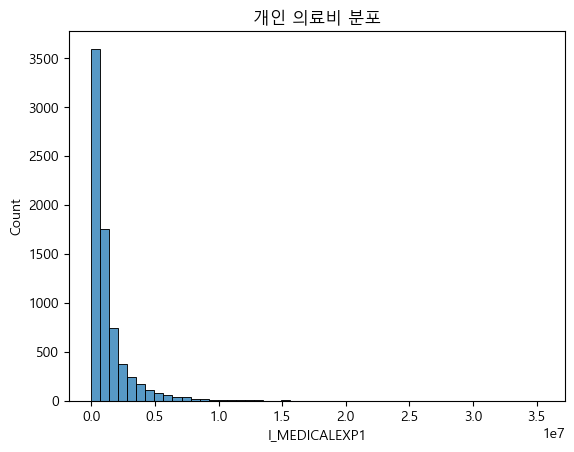

In [14]:
sns.histplot(x = 'I_MEDICALEXP1', data = df, bins = 50)
plt.title('개인 의료비 분포')
plt.show()

In [15]:
from matplotlib.ticker import FuncFormatter

# xticks 레이블을 만원 단위로 변경하고 천 단위 구분 기호 추가
def format_ticks(x, pos):
    return f'{x / 10000:,.0f}만'

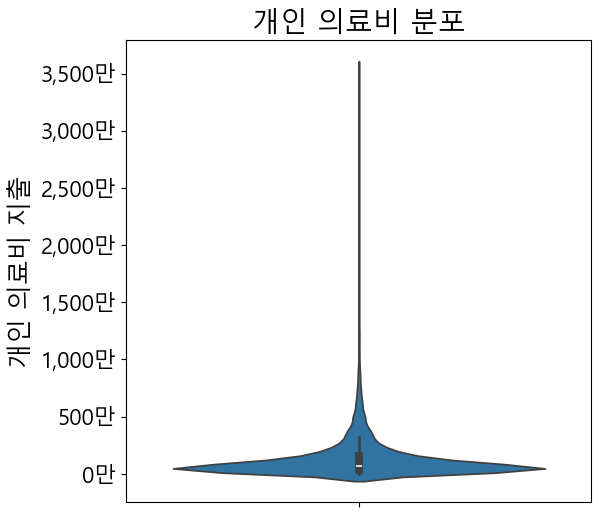

In [16]:
plt.figure(figsize = (6, 6))
sns.violinplot(y = 'I_MEDICALEXP1', data = df)
plt.title('개인 의료비 분포', fontsize = 20)
plt.yticks(fontsize = 16)
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ticks))

# y축 라벨 타이틀 폰트 크기 조정
plt.ylabel('개인 의료비 지출', fontsize = 18)  # y축 라벨 타이틀 폰트 크기 18로 설정

plt.show()

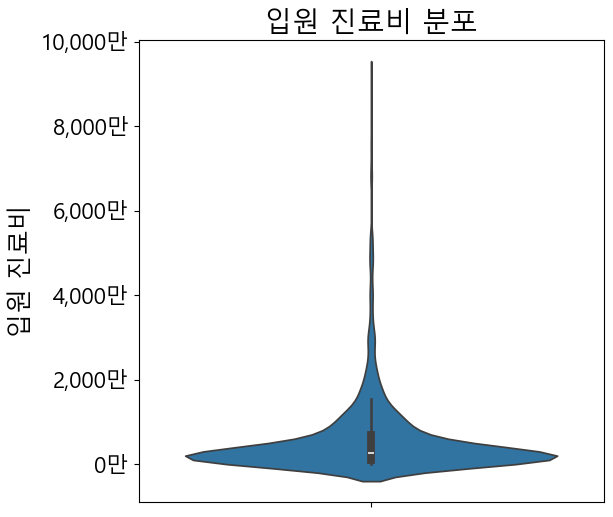

In [24]:
plt.figure(figsize = (6, 6))
sns.violinplot(y = 'IN35_6', data = df)
plt.title('입원 진료비 분포', fontsize = 20)
plt.yticks(fontsize = 16)
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ticks))

# y축 라벨 타이틀 폰트 크기 조정
plt.ylabel('입원 진료비', fontsize = 18)  # y축 라벨 타이틀 폰트 크기 18로 설정

plt.show()

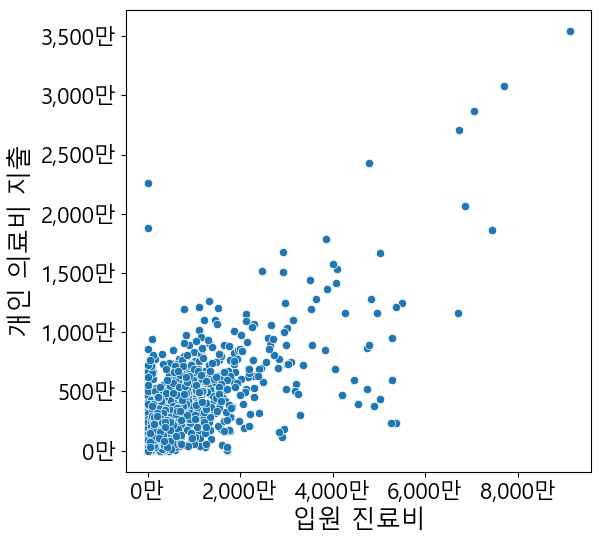

In [17]:
plt.figure(figsize = (6, 6))
sns.scatterplot(x = 'IN35_6', y = 'I_MEDICALEXP1', data = df)
#plt.title('입원 진료비와 개인 의료비 지출의 관계', fontsize = 20)
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ticks))
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_ticks))
# y축 라벨 타이틀 폰트 크기 조정
plt.xlabel('입원 진료비', fontsize = 18)  # y축 라벨 타이틀 폰트 크기 18로 설정
plt.ylabel('개인 의료비 지출', fontsize = 18)  # y축 라벨 타이틀 폰트 크기 18로 설정
plt.show()

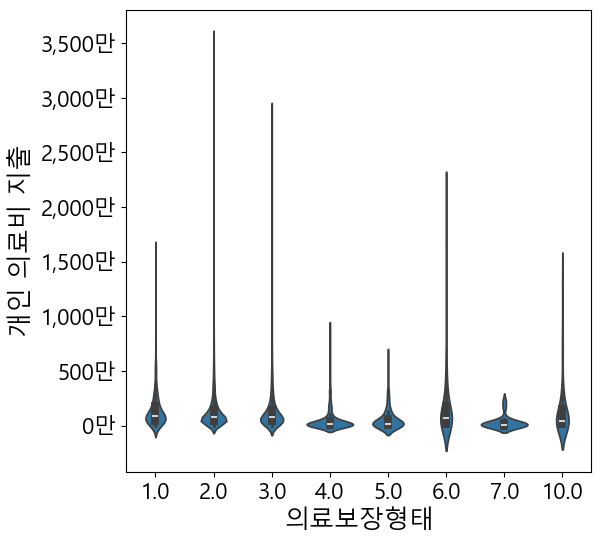

In [21]:
plt.figure(figsize = (6, 6))
sns.violinplot(data=df, x='C11', y='I_MEDICALEXP1')
#plt.title('입원 진료비와 개인 의료비 지출의 관계', fontsize = 20)
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ticks))
#plt.gca().xaxis.set_major_formatter(FuncFormatter(format_ticks))
# y축 라벨 타이틀 폰트 크기 조정
plt.xlabel('의료보장형태', fontsize = 18)  # y축 라벨 타이틀 폰트 크기 18로 설정
plt.ylabel('개인 의료비 지출', fontsize = 18)  # y축 라벨 타이틀 폰트 크기 18로 설정
plt.show()

In [194]:
df['IN35_6'].idxmax()

3061

In [195]:
df.sort_values(by = ['IN35_6'], ascending = False).head(10)['C11'].value_counts()

C11
2.0    5
3.0    3
6.0    1
7.0    1
Name: count, dtype: int64

In [196]:
df.sort_values(by = ['IN35_6'], ascending = False).head(10)

,PIDWON,CD3_1,CD4,CD5,year,C3,C4_0,C8,C11,C24,C41,TOTAL_Q5_08,I_MEDICALEXP1,ER33,ER26_5,IN9,IN35_6,IN37,OUCOUNT,OU9,OU29_7,OU35,OU50,SE1,age
3061,1226002.0,43.0,1.0,1.0,2016,2.0,1966.0,4,2.0,2.0,2.0,5.0,35446780.0,0.0,0.0,78.0,91333866.0,0.0,51.0,5.0,10690099.0,277700.0,-1.0,2.0,50.0
1648,1226002.0,43.0,1.0,1.0,2015,2.0,1966.0,4,2.0,1.0,2.0,4.0,30745440.0,0.0,220804.0,42.0,77113993.0,0.0,57.0,2.0,2597303.0,1920280.0,-1.0,2.0,49.0
2925,1104201.0,55.0,1.0,1.0,2016,1.0,1948.0,4,6.0,2.0,2.0,5.0,18644790.0,0.0,2131040.0,34.0,74487342.0,0.0,76.0,3.0,25536031.0,336719.0,-1.0,2.0,68.0
1232,3149802.0,61.0,1.0,1.0,2014,2.0,1949.0,2,3.0,2.0,1.0,1.0,28655555.0,0.0,0.0,211.0,70594903.0,39200.0,113.0,2.0,2683804.0,862260.0,-1.0,2.0,65.0
2389,2006001.0,65.0,1.0,1.0,2015,1.0,1948.0,3,2.0,1.0,2.0,3.0,20624773.0,0.0,189974.0,136.0,68647438.0,0.0,83.0,2.0,10550610.0,299950.0,-1.0,2.0,67.0
2643,3149802.0,61.0,1.0,1.0,2015,2.0,1949.0,2,3.0,2.0,2.0,1.0,27102360.0,0.0,259139.0,179.0,67269083.0,0.0,30.0,1.0,1033209.0,582100.0,-1.0,2.0,66.0
6668,1724104.0,59.0,1.0,1.0,2018,2.0,1941.0,2,3.0,2.0,2.0,3.0,11644559.0,0.0,532502.0,503.0,67157552.0,0.0,3.0,2.0,50760.0,0.0,-1.0,2.0,77.0
2134,1646601.0,59.0,1.0,1.0,2015,1.0,1951.0,2,2.0,2.0,2.0,1.0,12483551.0,0.0,0.0,381.0,54918899.0,0.0,6.0,3.0,131051.0,7370.0,-1.0,2.0,64.0
4881,1571801.0,78.0,1.0,1.0,2017,1.0,1933.0,2,7.0,2.0,2.0,2.0,2297610.0,0.0,0.0,230.0,53720220.0,0.0,5.0,6.0,33577.0,273.0,-1.0,2.0,84.0
5913,1151701.0,42.0,1.0,1.0,2018,1.0,1948.0,5,2.0,1.0,2.0,4.0,12168630.0,0.0,0.0,80.0,53643050.0,0.0,35.0,3.0,4041970.0,0.0,-1.0,2.0,70.0


In [197]:
df.iloc[3061, :]

PIDWON            1226002.0
CD3_1                  43.0
CD4                     1.0
CD5                     1.0
year                 2016.0
C3                      2.0
C4_0                 1966.0
C8                      4.0
C11                     2.0
C24                     2.0
C41                     2.0
TOTAL_Q5_08             5.0
I_MEDICALEXP1    35446780.0
ER33                    0.0
ER26_5                  0.0
IN9                    78.0
IN35_6           91333866.0
IN37                    0.0
OUCOUNT                51.0
OU9                     5.0
OU29_7           10690099.0
OU35               277700.0
OU50                   -1.0
SE1                     2.0
age                    50.0
Name: 3061, dtype: float64

NameError: name 'FuncFormatter' is not defined

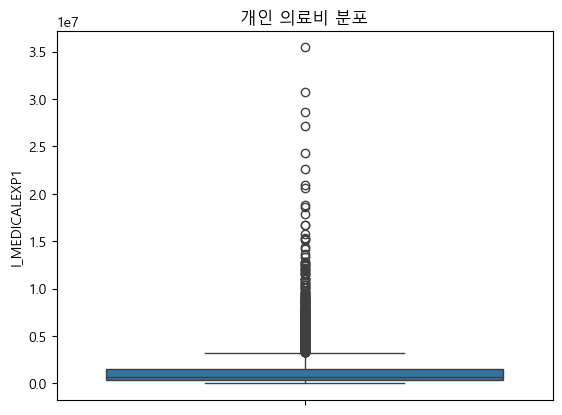

In [5]:
sns.boxplot(y = 'I_MEDICALEXP1', data = df)
plt.title('개인 의료비 분포')
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ticks))
plt.show()

#### 2) 범주형 변수

In [199]:
print(lst_categorical)

['C3', 'C8', 'C11', 'C24', 'C41', 'TOTAL_Q5_08', 'CD4', 'CD5', 'OU9', 'SE1', 'OU50']


##### 컬럼별 분포 확인
- C8 (교육 수준): 석·박사 비율이 낮음 → 대학교와 통합 고려 가능.
- C11 (의료보장 형태): 직장 건강보험 가입자가 많음.
- C24 (경제활동 여부): 경제활동하지 않는 사람이 더 많음.
- CD4 (질병으로 인한 의료 이용 여부): '예'가 많으며, 무응답(-9) 존재.
- CD5 (질병으로 인한 복용 여부): '예'가 많으며, 무응답(-9) 존재.\
- C41 (의료 이용 여부, 처방전 없이 약 복용) : '아니오'가 많음

##### 범주형 변수 분포 시각화

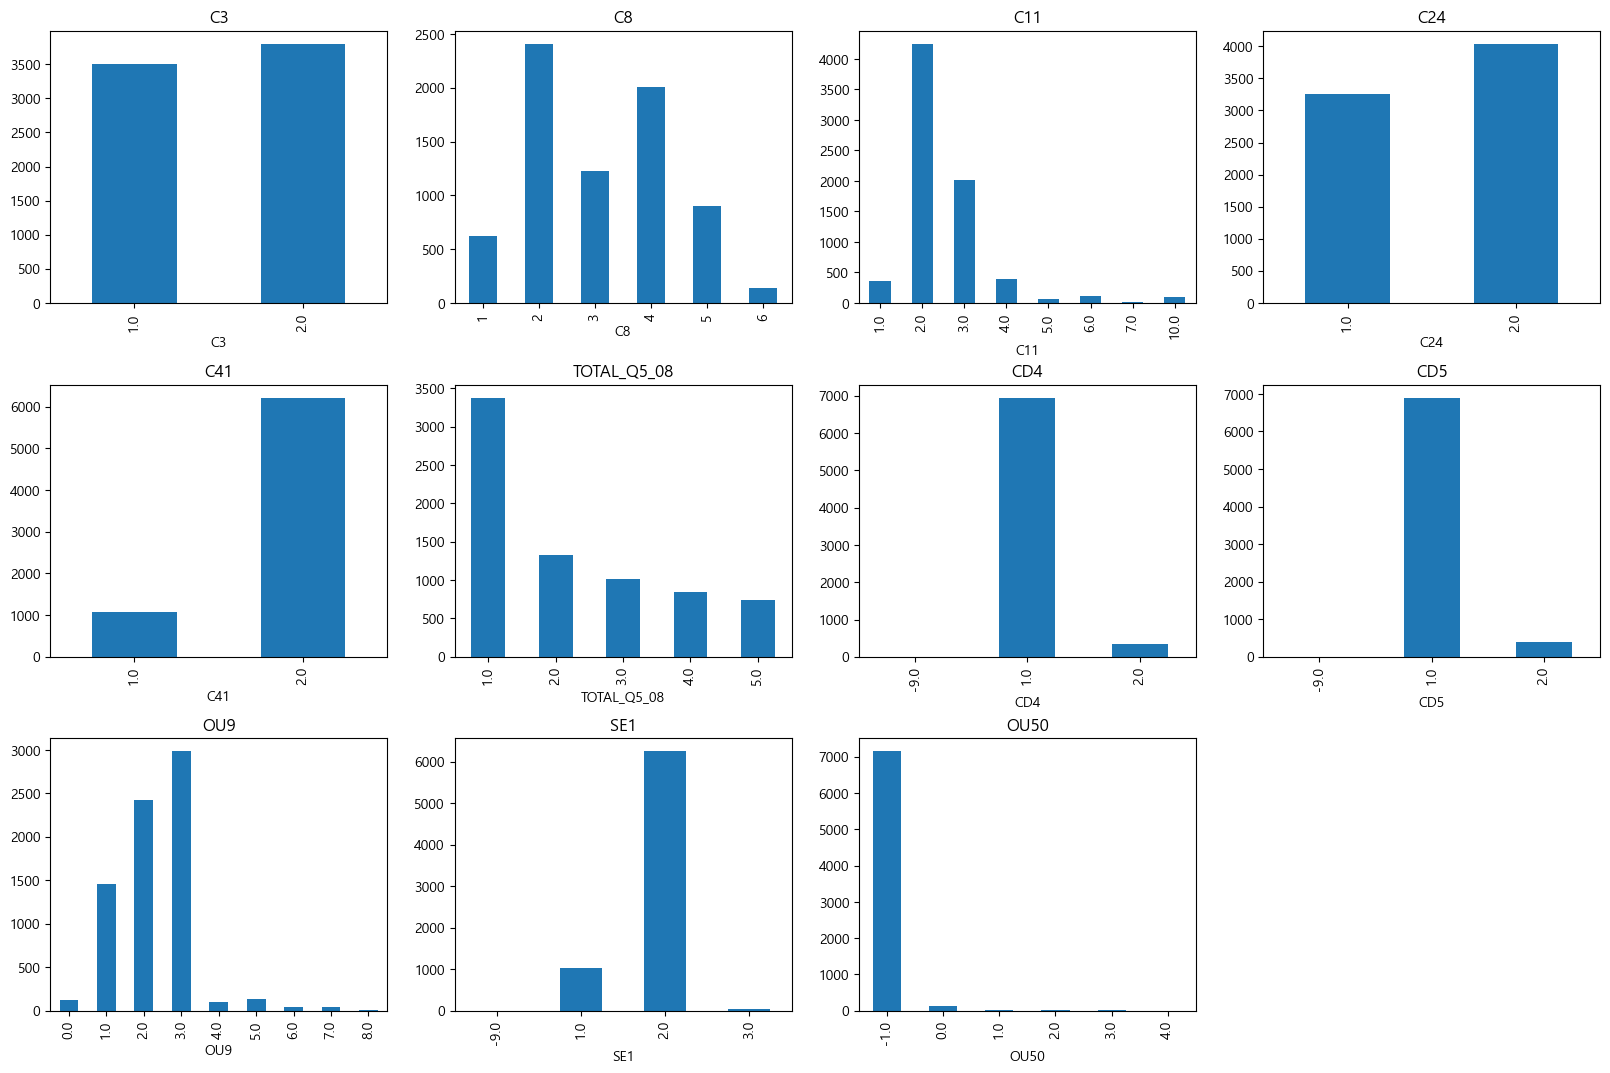

In [200]:
plt.figure(figsize=(20,10))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.3, wspace=0.2)

for col in lst_categorical:
    plt.subplot(3,4,x)
    x = x+1
    df[col].value_counts().sort_index().plot(kind='bar')
    plt.title(col)
plt.show()

##### 무응답 처리
- 조사 초기 무응답이었지만, 이후 문항에 대해 응답이 이루어진 경우 해당 응답 데이터를 활용하여 결측치를 대체함.

In [201]:
df[df['CD4'] == -9] 

,PIDWON,CD3_1,CD4,CD5,year,C3,C4_0,C8,C11,C24,C41,TOTAL_Q5_08,I_MEDICALEXP1,ER33,ER26_5,IN9,IN35_6,IN37,OUCOUNT,OU9,OU29_7,OU35,OU50,SE1,age
50,1041602.0,62.0,-9.0,-9.0,2014,2.0,1949.0,3,10.0,1.0,2.0,3.0,166700.0,0.0,0.0,0.0,0.0,0.0,19.0,3.0,616950.0,43500.0,-1.0,1.0,65.0
1537,1131401.0,68.0,-9.0,1.0,2015,1.0,1936.0,3,2.0,1.0,2.0,2.0,332800.0,0.0,0.0,0.0,0.0,0.0,22.0,1.0,211780.0,266500.0,-1.0,2.0,79.0


In [202]:
df[df['PIDWON'] == 1131401] 

,PIDWON,CD3_1,CD4,CD5,year,C3,C4_0,C8,C11,C24,C41,TOTAL_Q5_08,I_MEDICALEXP1,ER33,ER26_5,IN9,IN35_6,IN37,OUCOUNT,OU9,OU29_7,OU35,OU50,SE1,age
138,1131401.0,68.0,1.0,1.0,2014,1.0,1936.0,3,2.0,1.0,1.0,3.0,464000.0,0.0,0.0,0.0,0.0,0.0,23.0,2.0,467341.0,197100.0,-1.0,2.0,78.0
1537,1131401.0,68.0,-9.0,1.0,2015,1.0,1936.0,3,2.0,1.0,2.0,2.0,332800.0,0.0,0.0,0.0,0.0,0.0,22.0,1.0,211780.0,266500.0,-1.0,2.0,79.0
2943,1131401.0,68.0,1.0,1.0,2016,1.0,1936.0,3,2.0,1.0,2.0,4.0,212400.0,0.0,0.0,0.0,0.0,0.0,11.0,1.0,33700.0,190700.0,-1.0,2.0,80.0
4376,1131401.0,68.0,1.0,1.0,2017,1.0,1936.0,3,2.0,1.0,2.0,4.0,181400.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,178400.0,-1.0,2.0,81.0
5885,1131401.0,68.0,1.0,1.0,2018,1.0,1936.0,3,3.0,1.0,2.0,5.0,639000.0,0.0,0.0,0.0,0.0,0.0,33.0,2.0,222820.0,210400.0,-1.0,2.0,82.0


In [203]:
# CD5(질병으로 인한 복용 여부)
df[df['CD5'] == -9] 

,PIDWON,CD3_1,CD4,CD5,year,C3,C4_0,C8,C11,C24,C41,TOTAL_Q5_08,I_MEDICALEXP1,ER33,ER26_5,IN9,IN35_6,IN37,OUCOUNT,OU9,OU29_7,OU35,OU50,SE1,age
50,1041602.0,62.0,-9.0,-9.0,2014,2.0,1949.0,3,10.0,1.0,2.0,3.0,166700.0,0.0,0.0,0.0,0.0,0.0,19.0,3.0,616950.0,43500.0,-1.0,1.0,65.0


In [204]:
# CD3(성별), CD4(질병으로 인한 의료 이용 여부) 모두 무응답
df[df['PIDWON'] == 1041602] 

,PIDWON,CD3_1,CD4,CD5,year,C3,C4_0,C8,C11,C24,C41,TOTAL_Q5_08,I_MEDICALEXP1,ER33,ER26_5,IN9,IN35_6,IN37,OUCOUNT,OU9,OU29_7,OU35,OU50,SE1,age
50,1041602.0,62.0,-9.0,-9.0,2014,2.0,1949.0,3,10.0,1.0,2.0,3.0,166700.0,0.0,0.0,0.0,0.0,0.0,19.0,3.0,616950.0,43500.0,-1.0,1.0,65.0
1450,1041602.0,62.0,1.0,1.0,2015,2.0,1949.0,3,5.0,1.0,2.0,1.0,109900.0,0.0,0.0,0.0,0.0,0.0,32.0,2.0,666280.0,13500.0,-1.0,2.0,66.0
2858,1041602.0,62.0,1.0,1.0,2016,2.0,1949.0,3,5.0,1.0,2.0,2.0,199100.0,0.0,0.0,0.0,0.0,0.0,33.0,2.0,885528.0,11000.0,-1.0,2.0,67.0
4288,1041602.0,62.0,1.0,1.0,2017,2.0,1949.0,3,10.0,1.0,1.0,2.0,199700.0,0.0,0.0,0.0,0.0,0.0,30.0,3.0,864998.0,43900.0,-1.0,2.0,68.0
5793,1041602.0,62.0,1.0,1.0,2018,2.0,1949.0,3,10.0,1.0,1.0,2.0,878430.0,0.0,0.0,1.0,1445240.0,500.0,56.0,3.0,2706026.0,15500.0,-1.0,1.0,69.0


In [205]:
# 미충족 의료 무응답
df[df['SE1'] == -9] 

,PIDWON,CD3_1,CD4,CD5,year,C3,C4_0,C8,C11,C24,C41,TOTAL_Q5_08,I_MEDICALEXP1,ER33,ER26_5,IN9,IN35_6,IN37,OUCOUNT,OU9,OU29_7,OU35,OU50,SE1,age
633,1583102.0,54.0,1.0,1.0,2014,2.0,1942.0,2,10.0,2.0,2.0,1.0,961734.0,0.0,70907.0,20.0,3668394.0,0.0,13.0,2.0,88625.0,224200.0,-1.0,-9.0,72.0


In [206]:
df[df['PIDWON'] == 1583102] 

,PIDWON,CD3_1,CD4,CD5,year,C3,C4_0,C8,C11,C24,C41,TOTAL_Q5_08,I_MEDICALEXP1,ER33,ER26_5,IN9,IN35_6,IN37,OUCOUNT,OU9,OU29_7,OU35,OU50,SE1,age
633,1583102.0,54.0,1.0,1.0,2014,2.0,1942.0,2,10.0,2.0,2.0,1.0,961734.0,0.0,70907.0,20.0,3668394.0,0.0,13.0,2.0,88625.0,224200.0,-1.0,-9.0,72.0
2038,1583102.0,54.0,2.0,2.0,2015,2.0,1942.0,2,3.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,73.0
3435,1583102.0,54.0,1.0,1.0,2016,2.0,1942.0,2,3.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,74.0


In [207]:
# 무응답 처리 : 이후 문항에 대해 답한 결과로 대체함
df['CD4'] = df['CD4'].replace(-9, 1)
df['CD5'] = df['CD5'].replace(-9, 1)
df['SE1'] = df['SE1'].replace(-9, 2)

##### 범주형 변수와 타겟 변수 분포 확인
- C3 : 여성(2)의 분포가 더 넓고, 높은 의료비 지출을 가진 사례가 존재함.
- C8 : 교육 수준에 따라 의료비 분포 차이가 존재함.
- C11 : 건강보험가입자(2)에서 의료비 지출이 높은 사례가 존재함.
- C24 : 경제활동 유무에 따른 의료비 지출 차이가 존재함.
- OU9, OU50 : 특정 그룹에서 의료비 지출이 높거나 변동이 크게 나타남.
- OU9의 경우 정기적으로 의료기관을 방문하는 그룹이 더 높은 의료비를 지출함

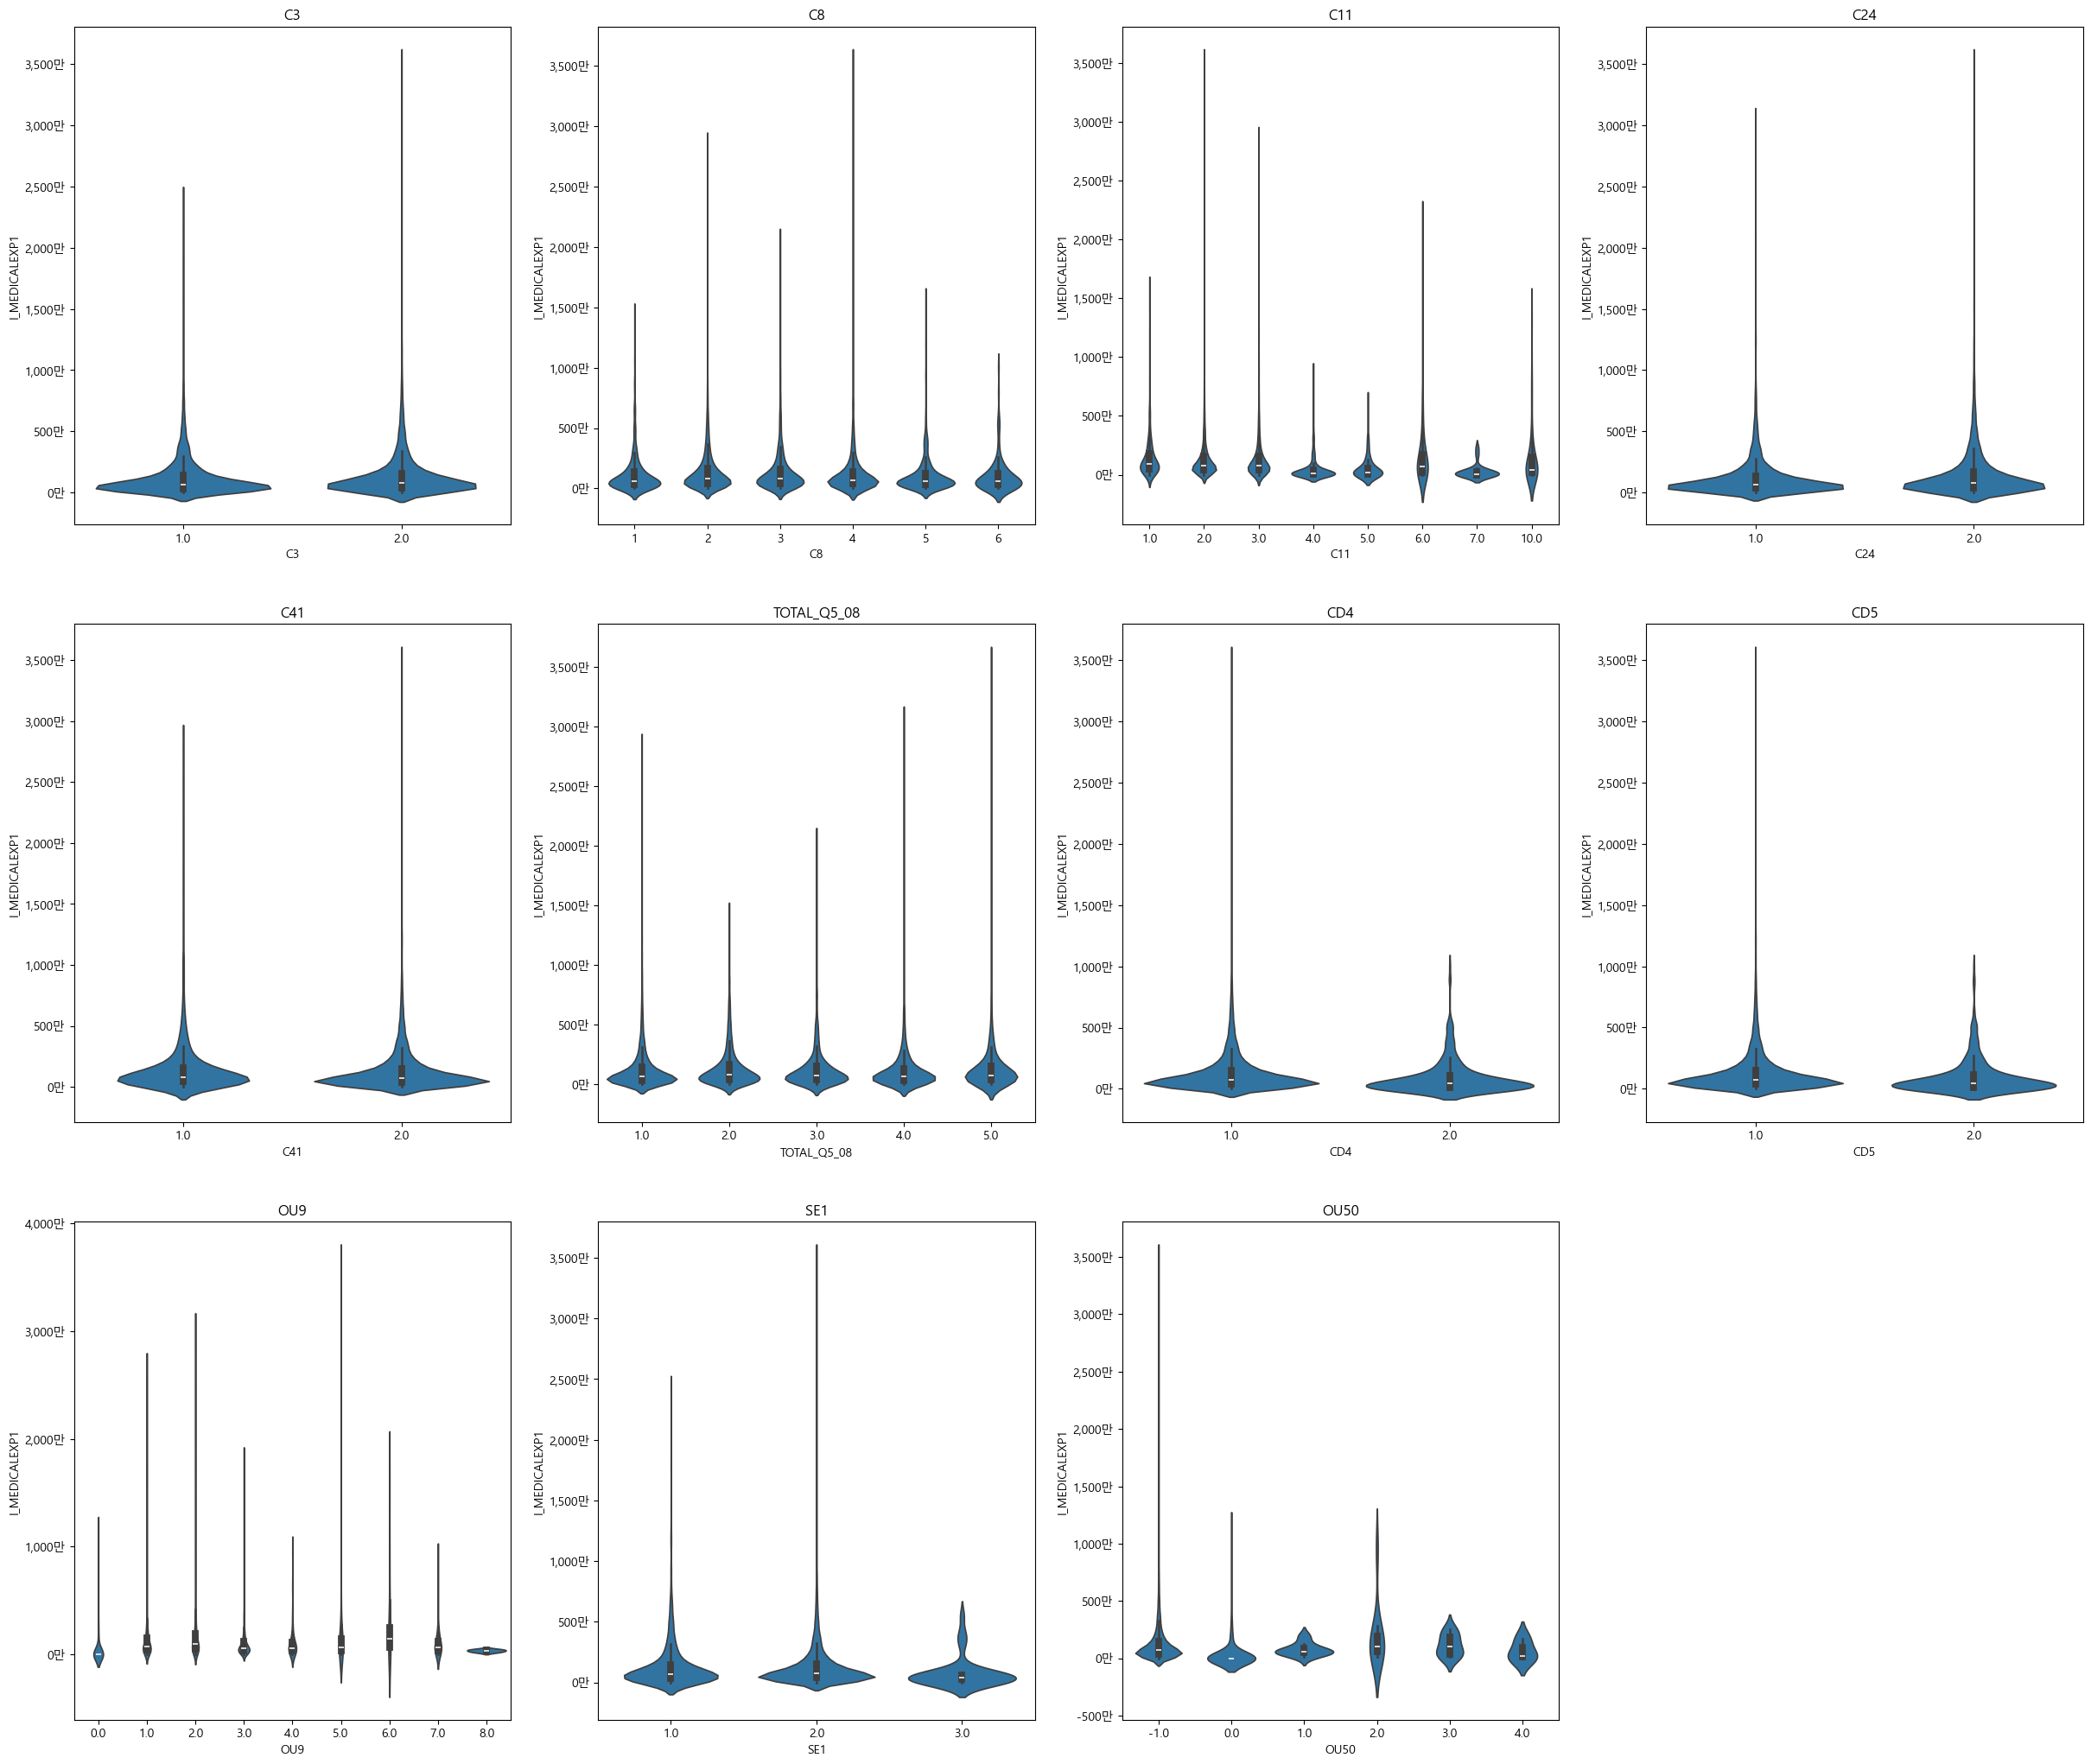

In [208]:
plt.figure(figsize=(30,20))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.2, wspace=0.2)

for col in lst_categorical:
    plt.subplot(3,4,x)
    x = x+1
    sns.violinplot(data=df, x=col, y='I_MEDICALEXP1')
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ticks))
    plt.title(col)
plt.show()

In [209]:
df[df['OU50'] == 2].min()

PIDWON           1216802.0
CD3_1                 30.0
CD4                    1.0
CD5                    1.0
year                2014.0
C3                     1.0
C4_0                1944.0
C8                     2.0
C11                    1.0
C24                    1.0
C41                    1.0
TOTAL_Q5_08            1.0
I_MEDICALEXP1     150330.0
ER33                   0.0
ER26_5                 0.0
IN9                    0.0
IN35_6                 0.0
IN37                   0.0
OUCOUNT               17.0
OU9                    1.0
OU29_7            252130.0
OU35               43200.0
OU50                   2.0
SE1                    1.0
age                   34.0
dtype: float64

##### 일원분산분석(ANOVA)
- 목적: 범주형 데이터에 따른 numeric data(예: 의료비 지출) 분포 차이를 검증

<strong>가정</strong>
- 정규성: 각 그룹의 데이터가 정규 분포를 따른다고 가정.
- 등분산성: 각 그룹의 분산이 동일하다고 가정
- 독립성: 각 그룹의 샘플이 서로 독립적
- 가정을 만족하지 않으면 ANOVA 결과의 신뢰성이 떨어질 수 있음

정규성 검정

- 귀무가설 : 모집단의 분포는 정규 분포이다
- 검정 방법 : Shpiro-Wilks Test
- p-value < 0.05이면, 귀무가설 기각 (기각하지 못하여야 정규성을 만족)

C:\Users\ssyyy\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7301.
  res = hypotest_fun_out(*samples, **kwds)


Text(0.5, 1.0, "shapiro test' pvalue : 9.81270185163992e-86")

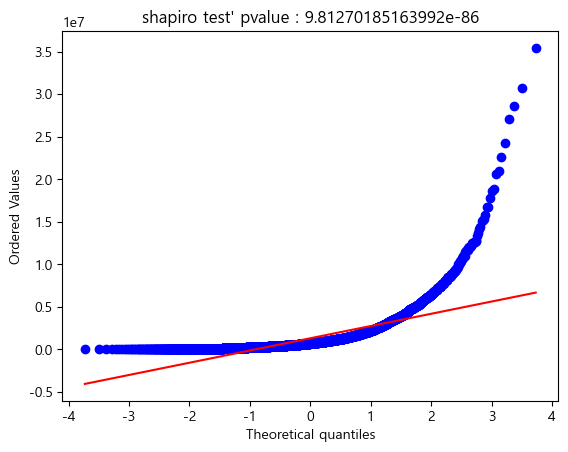

In [210]:
# numeric column 정규성 확인
stats.probplot(df['I_MEDICALEXP1'], dist=stats.norm, plot=plt)
plt.title("shapiro test' pvalue : %s"%str(stats.shapiro(df['I_MEDICALEXP1']).pvalue))

##### 정규성 검정
- p-value가 0.05 이하로 정규성을 만족하지 않으므로, 데이터가 정규 분포를 따르지 않는 것으로 판단됨.
- 비모수적 검정 방법인 크루스칼-왈리스 검정을 수행하여 그룹 간 차이를 분석함.

##### Kruskall 검정
- 비모수 검정이기때문에 정규성 / 등분산성을 만족하지 않아도 됨
- 모수 검정보다 검정 결과 신뢰도가 떨어짐

In [211]:
df['SE1'].value_counts()

SE1
2.0    6247
1.0    1018
3.0      36
Name: count, dtype: int64

In [212]:
lst_meaningful_col_by_kruskall = []

for col in lst_categorical:
    lst_kruskal = []

    for item in df[col].unique():
        df_tmp = (df[df[col] == item]['I_MEDICALEXP1'])
        lst_kruskal.append(np.array(df_tmp))
    statistic, pvalue = kruskal(*lst_kruskal)

    if pvalue <= 0.05:
        lst_meaningful_col_by_kruskall.append(col)
        
    print(f'{col}, {statistic}, {pvalue}\n')
print('-----------------------------------------')
print('전체 범주형 변수 : ', len(lst_categorical))
print('kruskall에 의해 뽑힌 변수 : ', len(lst_meaningful_col_by_kruskall), lst_meaningful_col_by_kruskall)

C3, 45.4061020290227, 1.6013469540472178e-11

C8, 71.07754377912401, 6.113967110103026e-14

C11, 503.30805408028596, 1.55882310582302e-104

C24, 34.86254182750335, 3.5382297280729772e-09

C41, 10.967362202016234, 0.00092730663607278

TOTAL_Q5_08, 25.155557862492845, 4.681324525130595e-05

CD4, 73.69032045696275, 9.138591679398151e-18

CD5, 68.34815926259733, 1.3703310107109832e-16

OU9, 464.05724896899704, 3.592107857448521e-95

SE1, 17.147170633569477, 0.000189033687738588

OU50, 234.82834088535998, 9.866305921061562e-49

-----------------------------------------
전체 범주형 변수 :  11
kruskall에 의해 뽑힌 변수 :  11 ['C3', 'C8', 'C11', 'C24', 'C41', 'TOTAL_Q5_08', 'CD4', 'CD5', 'OU9', 'SE1', 'OU50']


##### Insight
1. 비모수검정을 통해 총 11개의 범주형 컬럼 중 11개 컬럼이 의료비 지출액과 유의미한 데이터 분포 차이를 보인다고 검정됨
2. 종속 변수는 정규 분포를 보이지 않음

#### 3) 연속형 변수

In [213]:
df.columns

Index(['PIDWON', 'CD3_1', 'CD4', 'CD5', 'year', 'C3', 'C4_0', 'C8', 'C11',
       'C24', 'C41', 'TOTAL_Q5_08', 'I_MEDICALEXP1', 'ER33', 'ER26_5', 'IN9',
       'IN35_6', 'IN37', 'OUCOUNT', 'OU9', 'OU29_7', 'OU35', 'OU50', 'SE1',
       'age'],
      dtype='object')

In [214]:
# 연속형 변수 추출
print(list(set(df.columns.tolist()) - set(lst_categorical)))

['C4_0', 'ER26_5', 'IN35_6', 'OU35', 'I_MEDICALEXP1', 'OU29_7', 'IN9', 'PIDWON', 'age', 'ER33', 'CD3_1', 'IN37', 'OUCOUNT', 'year']


In [215]:
# PIDWON / year 변수 제거
lst_numerical = ['ER26_5', 'CD3_1', 'OU35', 'OUCOUNT', 'C4_0', 'IN37', 'OU29_7', 'IN35_6', 'ER33', 'IN9', 'age']

##### 컬럼별 분포 확인
- 응급과 입원 데이터의 경우, 대부분 0 근처에 몰려있고 일부 극단값이 존재함
- 나이 관련 변수들은 넓게 분포되어 있어 의료비 지출과 관련된 변수로 보임

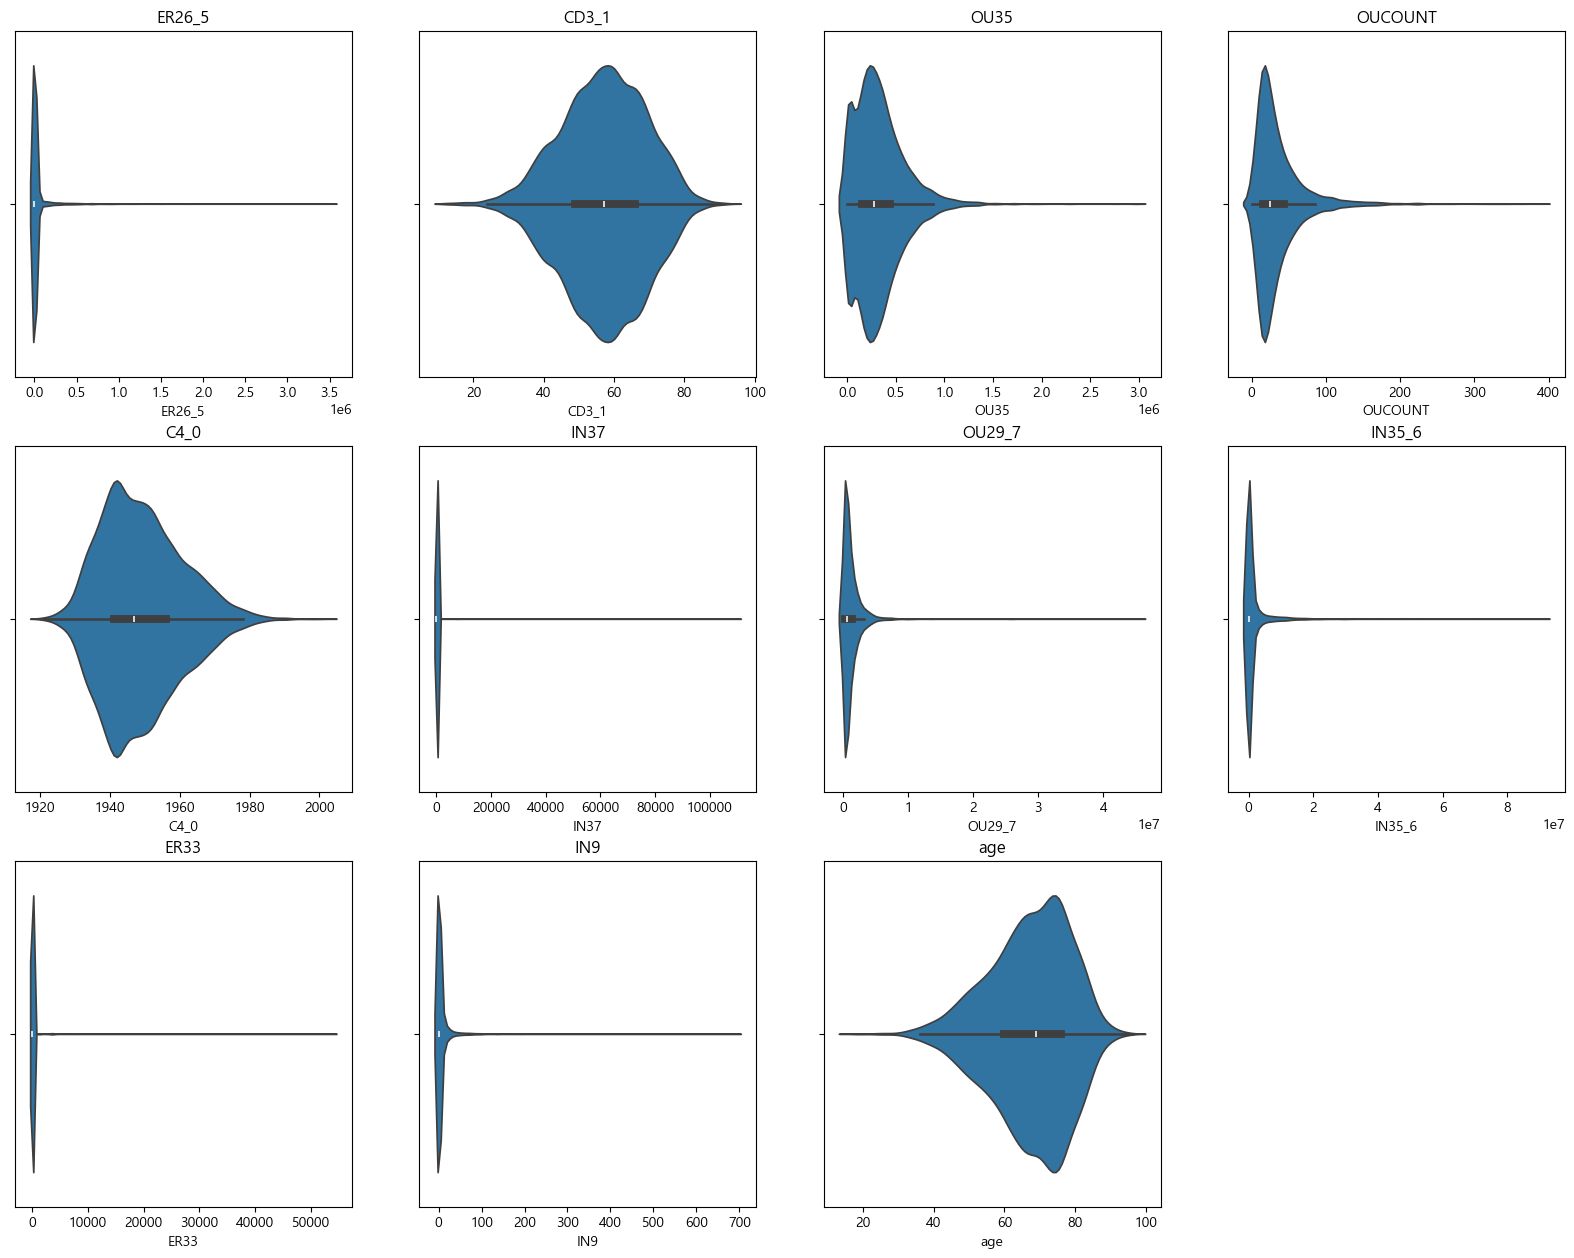

In [216]:
plt.figure(figsize = (20,12))
plt.subplots_adjust(top = 0.99, bottom = 0.01, wspace = 0.2, hspace = 0.2)

x = 1
for col in lst_numerical:
    plt.subplot(3, 4, x)
    x += 1
    sns.violinplot(data = df, x = col)
    plt.title(col)
plt.show()

##### 독립변수와 타겟 변수의 분포
- 응급/외래/입원 데이터의 경우, 대부분의 값이 0에 가깝지만 일부 높은 의료비 지출과 관련이 있음
- 나이가 많을수록 의료비 지출이 증가하는 경향을 보임.
- 특정 연령에서 의료비 지출이 급격히 증가하는 패턴을 가짐.

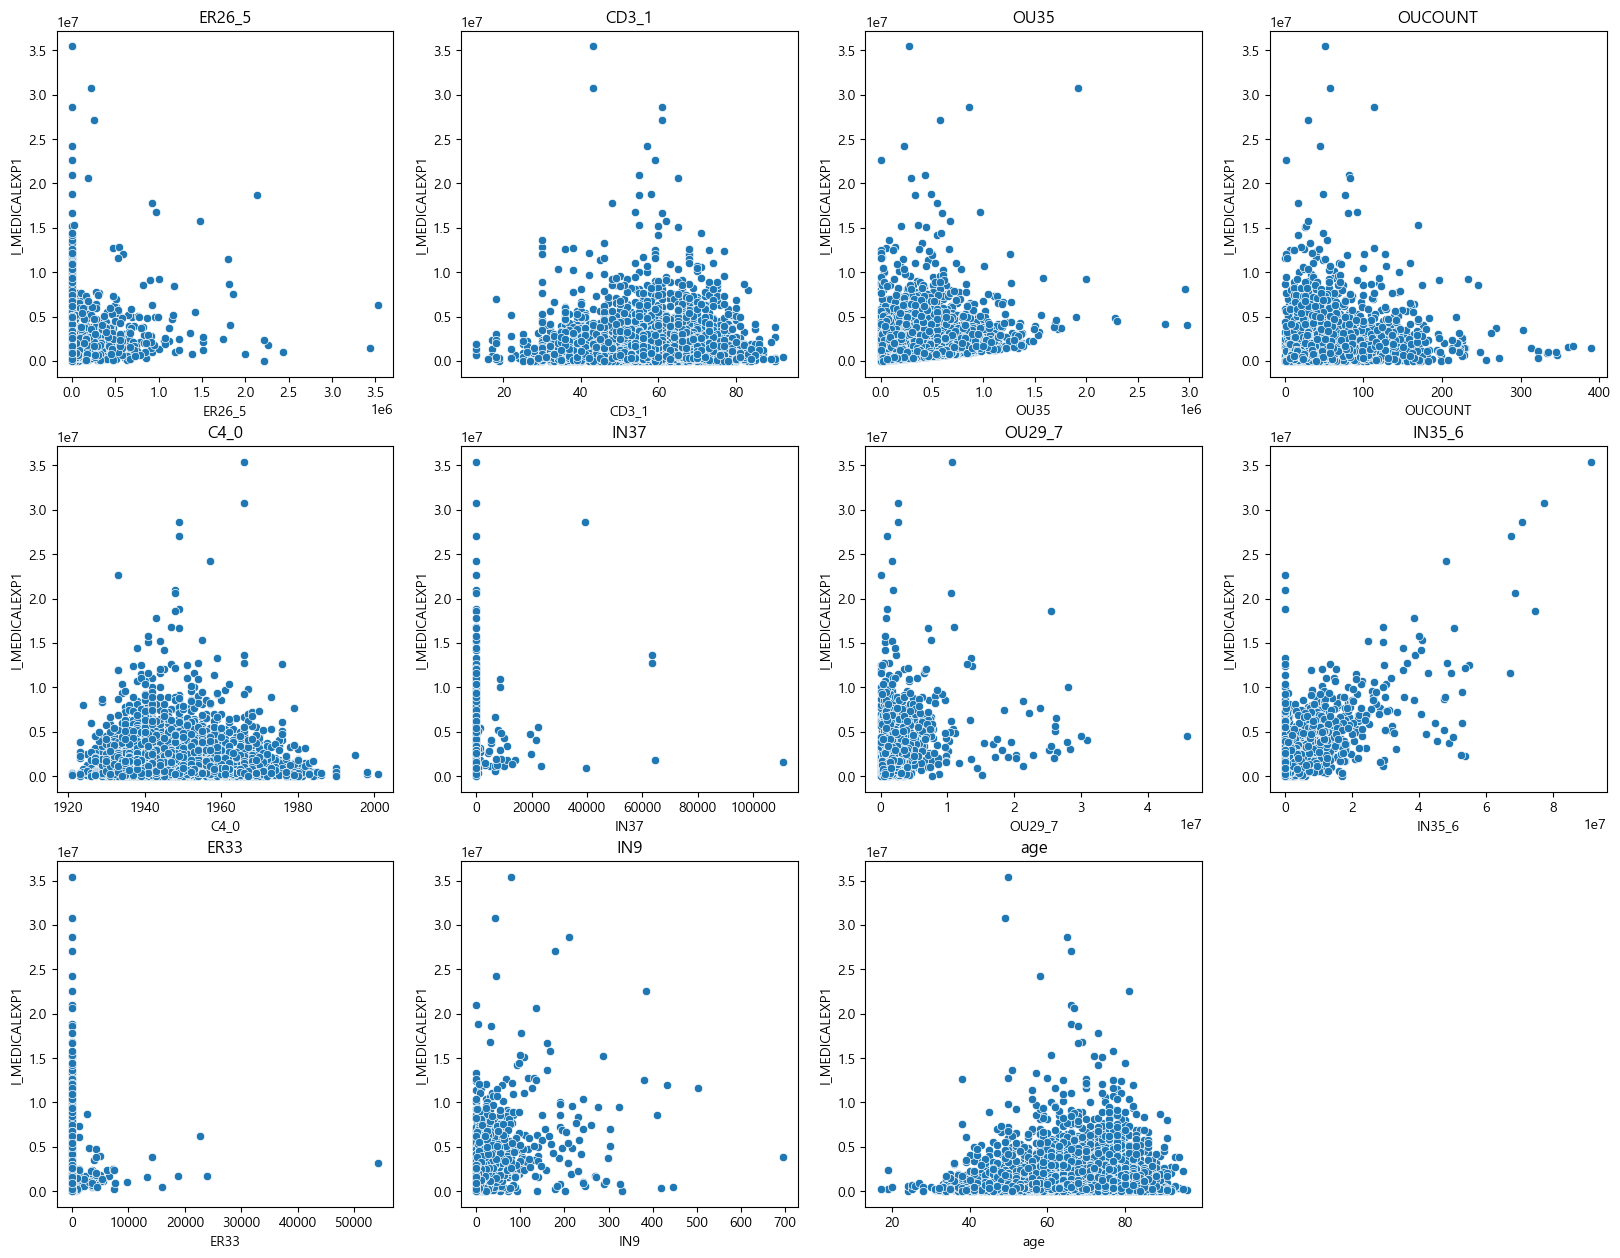

In [217]:
plt.figure(figsize = (20,12))
plt.subplots_adjust(top = 0.99, bottom = 0.01, wspace = 0.2, hspace = 0.2)

x = 1
for col in lst_numerical:
    plt.subplot(3, 4, x)
    x += 1
    sns.scatterplot(data = df, x = col , y= 'I_MEDICALEXP1')
    plt.title(col)
plt.show()

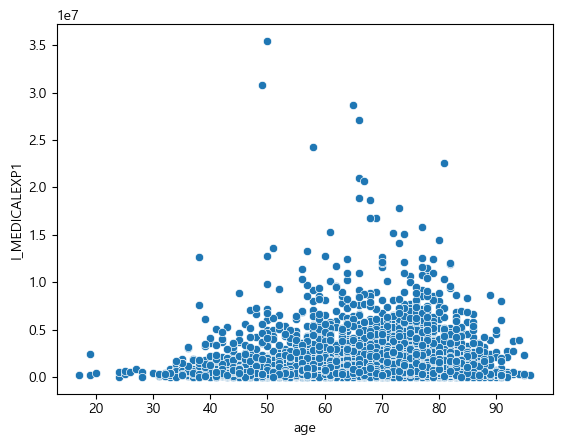

In [218]:
plt.figure()
sns.scatterplot(data = df, x = 'age', y='I_MEDICALEXP1')
plt.show()

In [219]:
for col in lst_numerical:
  print(col, "skew : ", skew(df[col]), "kur : ", kurtosis(df[col]) )

# 왜도 : 양수의 큰 왜도를 가진 변수(ex. ER33, IN37)들은 오른쪽으로 치우친 분포를 가지고 있음
# 첨도 : 높은 첨도를 가진 변수(ex. ER33, IN9 등)들은 극단적인 값들이 많음을 나타냄

ER26_5 skew :  10.23121634381186 kur :  149.8756394085662
CD3_1 skew :  -0.22826502261496895 kur :  -0.15764334790279122
OU35 skew :  1.7074010170027898 kur :  7.345259587333846
OUCOUNT skew :  3.112661636371954 kur :  16.15662498716117
C4_0 skew :  0.5715606015033249 kur :  0.07812852232207401
IN37 skew :  35.38275338294796 kur :  1505.2547351553915
OU29_7 skew :  8.143476732339444 kur :  103.9334618060417
IN35_6 skew :  7.412182336056865 kur :  75.87949146837961
ER33 skew :  38.579309981771914 kur :  1981.7590177629456
IN9 skew :  9.81330886914975 kur :  133.41524943264352
age skew :  -0.5583557133816099 kur :  0.06202138097697096


##### 다중공선성 
- 어떤 독립 변수가 다른 독립 변수들과 완벽한 “선형 독립”이 아닌 경우를 말함
- 다중 공선성은 데이터 분석 시 부정적인 영향을 미쳐, 설명력이 약해지고 standar error가 증가할 수 있음

<strong> 다중공선성 확인 방법</strong>
1. 결정계수와 유의확률을 활용한 다중공선성 확인
2. 상관계수 및 산점도(scatter plot)를 활용한 확인
3. VIF를 통한 다중공선성 확인

##### 상관관계 분석

- 입원 관련 변수가 타겟 컬럼과 높은 상관관계를 보임
- 기준은 0.85이상으로 너무 높은 상관관계를 갖는 데이터는 삭제함

In [220]:
# 상관관계를 위한 컬럼 
lst_numerical_corr = lst_numerical + ['I_MEDICALEXP1']

In [221]:
df[lst_numerical_corr].corr().style.background_gradient(cmap = 'Blues')

,ER26_5,CD3_1,OU35,OUCOUNT,C4_0,IN37,OU29_7,IN35_6,ER33,IN9,age,I_MEDICALEXP1
ER26_5,1.000000,0.024643,0.046534,0.081813,-0.055025,0.013774,0.143917,0.189494,0.059549,0.093638,0.057858,0.186565
CD3_1,0.024643,1.000000,0.000195,0.142921,-0.763634,-0.014932,0.003165,0.028010,0.003355,0.024564,0.767144,0.023177
OU35,0.046534,0.000195,1.000000,0.208920,-0.105726,0.029136,0.128410,0.039698,0.032229,-0.047689,0.115253,0.297854
OUCOUNT,0.081813,0.142921,0.208920,1.000000,-0.178588,0.008299,0.440716,0.098642,0.045407,0.052484,0.178482,0.240246
C4_0,-0.055025,-0.763634,-0.105726,-0.178588,1.000000,0.014743,-0.043643,-0.060542,-0.003931,-0.053720,-0.992322,-0.061933
IN37,0.013774,-0.014932,0.029136,0.008299,0.014743,1.000000,0.013395,0.107624,0.023966,0.069815,-0.013480,0.112795
OU29_7,0.143917,0.003165,0.128410,0.440716,-0.043643,0.013395,1.000000,0.185655,0.042535,0.073407,0.053319,0.414351
IN35_6,0.189494,0.028010,0.039698,0.098642,-0.060542,0.107624,0.185655,1.000000,-0.003656,0.560454,0.066057,0.715125
ER33,0.059549,0.003355,0.032229,0.045407,-0.003931,0.023966,0.042535,-0.003656,1.000000,0.000847,0.004467,0.026951
IN9,0.093638,0.024564,-0.047689,0.052484,-0.053720,0.069815,0.073407,0.560454,0.000847,1.000000,0.054317,0.436986


In [222]:
# 강한 상관관계를 변수 쌍 찾기
df_corr = df[lst_numerical_corr].corr()
index_corr_over_85 = np.where((abs(df_corr)>0.85) & (df_corr != 1))
index_corr_over_85

(array([ 4, 10], dtype=int64), array([10,  4], dtype=int64))

In [223]:
# 높은 상관을 가지는 변수 쌍의 개수
len_corr_over_85 = len(index_corr_over_85[0])

left_columns = df_corr.columns[index_corr_over_85[0]]
right_columns = df_corr.columns[index_corr_over_85[1]]

for index in range(len_corr_over_85):
  print(left_columns[index], "<->", right_columns[index])  

C4_0 <-> age
age <-> C4_0


In [224]:
# 상관관계가 -0.99로 매우 높아 삭제
lst_removed_by_correlation = ['C4_0']

In [225]:
df.shape

(7301, 25)

In [226]:
df = df.drop(lst_removed_by_correlation, axis = 1)
df.shape

(7301, 24)

In [227]:
# C4_0 (출생년도) 제거
lst_numerical.remove('C4_0')

In [228]:
print(lst_numerical)

['ER26_5', 'CD3_1', 'OU35', 'OUCOUNT', 'IN37', 'OU29_7', 'IN35_6', 'ER33', 'IN9', 'age']


##### VIF Analysis
VIF 통한 다중공선성 확인
- 일반적으로 10 이상인 경우, 다중공선성이 있다고 가정

In [229]:
def calculate_vif(df_target):
  vif = pd.DataFrame()
  vif['Feature'] = df_target.columns
  vif['VIF_Factor'] = [variance_inflation_factor(df_target.values, i) for i in range(df_target.shape[1])]
  
  return vif.sort_values(by=['VIF_Factor'], ascending = False)

# 진단 연령과 조사 당시 연령이 높은 상관관계를 보임
calculate_vif(df[lst_numerical])

,Feature,VIF_Factor
9,age,63.669885
1,CD3_1,59.005773
2,OU35,2.757292
3,OUCOUNT,2.713493
5,OU29_7,1.742531
6,IN35_6,1.666532
8,IN9,1.544463
0,ER26_5,1.091614
4,IN37,1.015520
7,ER33,1.010263


In [230]:
df_vif = df[lst_numerical].copy()
df_vif

,ER26_5,CD3_1,OU35,OUCOUNT,IN37,OU29_7,IN35_6,ER33,IN9,age
0,0.0,57.0,38100.0,18.0,0.0,107360.0,0.0,0.0,0.0,61.0
1,0.0,56.0,145400.0,8.0,0.0,212324.0,0.0,0.0,0.0,59.0
2,213467.0,57.0,187940.0,25.0,0.0,1636587.0,0.0,3490.0,0.0,58.0
3,0.0,51.0,100800.0,28.0,0.0,483893.0,0.0,0.0,0.0,53.0
4,0.0,36.0,263378.0,40.0,0.0,1225208.0,0.0,0.0,0.0,47.0
...,...,...,...,...,...,...,...,...,...,...
7296,0.0,60.0,127500.0,22.0,0.0,706220.0,0.0,0.0,0.0,66.0
7297,0.0,63.0,66400.0,23.0,0.0,625100.0,0.0,0.0,0.0,70.0
7298,122793.0,68.0,189700.0,21.0,0.0,802811.0,18838799.0,0.0,81.0,86.0
7299,0.0,58.0,420130.0,57.0,0.0,1565144.0,0.0,0.0,0.0,68.0


In [231]:
# 당뇨 경과 기간
df_vif['duration'] = df_vif['age']-df_vif['CD3_1'] 
df_vif['duration']

0        4.0
1        3.0
2        1.0
3        2.0
4       11.0
        ... 
7296     6.0
7297     7.0
7298    18.0
7299    10.0
7300    16.0
Name: duration, Length: 7301, dtype: float64

In [232]:
# 한 개 씩 데이터를 지우면서 확인 (반복작업)
df_vif.drop(['CD3_1'], axis = 1, inplace = True)

In [233]:
final_vif = calculate_vif(df_vif)
final_vif

,Feature,VIF_Factor
8,age,4.866351
9,duration,2.931666
1,OU35,2.757292
2,OUCOUNT,2.713493
4,OU29_7,1.742531
5,IN35_6,1.666532
7,IN9,1.544463
0,ER26_5,1.091614
3,IN37,1.015520
6,ER33,1.010263


In [234]:
print(len(lst_numerical),lst_numerical)

10 ['ER26_5', 'CD3_1', 'OU35', 'OUCOUNT', 'IN37', 'OU29_7', 'IN35_6', 'ER33', 'IN9', 'age']


In [235]:
# 다중공선성(VIF) 고려한 최종 숫자형 변수 리스트
lst_numerical_feature_by_vif = list(final_vif["Feature"].values)
print(lst_numerical_feature_by_vif)
print(len(lst_numerical_feature_by_vif))

['age', 'duration', 'OU35', 'OUCOUNT', 'OU29_7', 'IN35_6', 'IN9', 'ER26_5', 'IN37', 'ER33']
10


In [236]:
# 당뇨 경과 기간 생성
df['duration'] = df['age']-df['CD3_1'] 
df.head()

,PIDWON,CD3_1,CD4,CD5,year,C3,C8,C11,C24,C41,TOTAL_Q5_08,I_MEDICALEXP1,ER33,ER26_5,IN9,IN35_6,IN37,OUCOUNT,OU9,OU29_7,OU35,OU50,SE1,age,duration
0,1000402.0,57.0,2.0,2.0,2014,1.0,6,3.0,1.0,2.0,4.0,10067300.0,0.0,0.0,0.0,0.0,0.0,18.0,2.0,107360.0,38100.0,-1.0,2.0,61.0,4.0
1,1000601.0,56.0,1.0,1.0,2014,1.0,5,3.0,1.0,2.0,3.0,254750.0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,212324.0,145400.0,-1.0,2.0,59.0,3.0
2,1000602.0,57.0,1.0,1.0,2014,2.0,2,3.0,1.0,2.0,3.0,1596730.0,3490.0,213467.0,0.0,0.0,0.0,25.0,1.0,1636587.0,187940.0,-1.0,1.0,58.0,1.0
3,1003301.0,51.0,1.0,1.0,2014,1.0,4,2.0,1.0,2.0,5.0,266010.0,0.0,0.0,0.0,0.0,0.0,28.0,3.0,483893.0,100800.0,-1.0,2.0,53.0,2.0
4,1003302.0,36.0,1.0,1.0,2014,2.0,4,2.0,2.0,2.0,5.0,872758.0,0.0,0.0,0.0,0.0,0.0,40.0,3.0,1225208.0,263378.0,-1.0,2.0,47.0,11.0


In [237]:
df['duration'].describe()

count    7301.000000
mean       10.233393
std         7.988333
min         0.000000
25%         4.000000
50%         8.000000
75%        14.000000
max        55.000000
Name: duration, dtype: float64

##### Insight
1.   numercal data 간의 상관관계 중, 매우 높은 상관 관계를 갖는 경우가 1개 존재, age <-> C4_0(출생년도)
2.   외래와 입원이 타겟 컬럼과 약한 상관관계를 보임
3.   다중공선성으로 인해  CD3_1(진단 연령)을 삭제하고 현재 연령을 포함시킴
4.   당뇨 경과 기간 = 현재 연령(age) - 진단 연령(CD3_1) 변수를 생성하여 진단 연령이 미치는 영향을 간접적으로 반영.

# 과제 # 2. 모델링

## 2-1. 변수 선택
- 통계적 검정 (Kruskal-Wallis)으로 범주형 변수 필터링
- 상관분석 및 VIF 검정을 활용하여 다중공선성이 높은 변수 제거

In [238]:
lst_selected_categorical = lst_meaningful_col_by_kruskall.copy()
print(lst_selected_categorical)

['C3', 'C8', 'C11', 'C24', 'C41', 'TOTAL_Q5_08', 'CD4', 'CD5', 'OU9', 'SE1', 'OU50']


In [239]:
print(lst_numerical_feature_by_vif)

['age', 'duration', 'OU35', 'OUCOUNT', 'OU29_7', 'IN35_6', 'IN9', 'ER26_5', 'IN37', 'ER33']


In [240]:
lst_selected_numerical = lst_numerical_feature_by_vif.copy()

In [241]:
len(lst_selected_numerical)

10

In [242]:
target_col = 'I_MEDICALEXP1'

In [243]:
# 검정에 의해 선택된 변수들에 대해 분석을 진행함
# 연도별로 데이터를 나누기 위해 year 추가
df_fs = df[lst_selected_categorical + lst_selected_numerical + ['year'] + [target_col]]
df_fs.head(2)

,C3,C8,C11,C24,C41,TOTAL_Q5_08,CD4,CD5,OU9,SE1,OU50,age,duration,OU35,OUCOUNT,OU29_7,IN35_6,IN9,ER26_5,IN37,ER33,year,I_MEDICALEXP1
0,1.0,6,3.0,1.0,2.0,4.0,2.0,2.0,2.0,2.0,-1.0,61.0,4.0,38100.0,18.0,107360.0,0.0,0.0,0.0,0.0,0.0,2014,10067300.0
1,1.0,5,3.0,1.0,2.0,3.0,1.0,1.0,1.0,2.0,-1.0,59.0,3.0,145400.0,8.0,212324.0,0.0,0.0,0.0,0.0,0.0,2014,254750.0


In [244]:
df_fs[lst_selected_numerical].skew()

age         -0.558470
duration     1.215326
OU35         1.707752
OUCOUNT      3.113301
OU29_7       8.145150
IN35_6       7.413706
IN9          9.815326
ER26_5      10.233319
IN37        35.390025
ER33        38.587238
dtype: float64

In [245]:
df_fs[lst_selected_numerical].kurtosis()

age            0.062886
duration       1.612421
OU35           7.351115
OUCOUNT       16.168517
OU29_7       104.005497
IN35_6        75.932304
IN9          133.507485
ER26_5       149.979153
IN37        1506.286921
ER33        1983.117693
dtype: float64

In [246]:
# 데이터 변환을 위한 데이터 준비
df_dt = df_fs.copy()

## 2-2. 데이터 변환

##### 로그변환
- 데이터의 왜도(skewness)와 첨도(kurtosis) 값이 크기 때문에 로그 변환을 적용함
- 로그 변환을 적용하면 이상치의 영향을 줄이고, 변수 간 관계를 선형적으로 변형하여 모델의 성능을 향상시킬 수 있음

In [247]:
# 로그 변환할 변수 리스트
lst_log_transform = ['OUCOUNT', 'OU29_7', 'IN35_6', 'IN9', 'ER26_5', 'IN37', 'ER33', 'OU35']

# 로그 변환 수행
for col in lst_log_transform:
    df_dt[col] = np.log(df_dt[col] + 1)  # 0 또는 음수 값 방지를 위해 +1을 추가

# 변환 후 데이터 확인
print(df_dt[lst_log_transform].describe())

           OUCOUNT       OU29_7       IN35_6          IN9       ER26_5  \
count  7301.000000  7301.000000  7301.000000  7301.000000  7301.000000   
mean      3.230168    12.907134     3.206224     0.578591     1.019680   
std       0.888153     2.752821     6.173443     1.198734     3.380066   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       2.772589    12.551437     0.000000     0.000000     0.000000   
50%       3.258097    13.388890     0.000000     0.000000     0.000000   
75%       3.784190    14.164722     0.000000     0.000000     0.000000   
max       5.968708    17.639242    18.330032     6.543912    15.077516   

              IN37         ER33         OU35  
count  7301.000000  7301.000000  7301.000000  
mean      0.053640     0.078414    11.859383  
std       0.696441     0.789726     2.502794  
min       0.000000     0.000000     0.000000  
25%       0.000000     0.000000    11.904974  
50%       0.000000     0.000000    12.538971  
75% 

##### 원핫인코딩
- 순서가 없는 범주형 변수에 대해 원-핫 인코딩을 적용함

In [248]:
df_dt[lst_selected_categorical].nunique()

C3             2
C8             6
C11            8
C24            2
C41            2
TOTAL_Q5_08    5
CD4            2
CD5            2
OU9            9
SE1            3
OU50           6
dtype: int64

In [249]:
print(lst_selected_categorical)

['C3', 'C8', 'C11', 'C24', 'C41', 'TOTAL_Q5_08', 'CD4', 'CD5', 'OU9', 'SE1', 'OU50']


In [250]:
# 이미 라벨 인코딩을 진행한 소득분위와 교육 수준은 제외함
lst_oh = ['C3', 'C11', 'C24', 'C41', 'CD4', 'CD5', 'OU9', 'SE1', 'OU50']

In [251]:
df_dt = pd.get_dummies(df_dt, columns = lst_oh, drop_first=True)  # 첫 번째 카테고리를 삭제하여 다중공선성을 피할 수 있음.

print("원-핫 인코딩된 데이터:")
df_dt

원-핫 인코딩된 데이터:


,C8,TOTAL_Q5_08,age,duration,OU35,OUCOUNT,OU29_7,IN35_6,IN9,ER26_5,IN37,ER33,year,I_MEDICALEXP1,C3_2.0,C11_2.0,C11_3.0,C11_4.0,C11_5.0,C11_6.0,C11_7.0,C11_10.0,C24_2.0,C41_2.0,CD4_2.0,CD5_2.0,OU9_1.0,OU9_2.0,OU9_3.0,OU9_4.0,OU9_5.0,OU9_6.0,OU9_7.0,OU9_8.0,SE1_2.0,SE1_3.0,OU50_0.0,OU50_1.0,OU50_2.0,OU50_3.0,OU50_4.0
0,6,4.0,61.0,4.0,10.547996,2.944439,11.583952,0.000000,0.000000,0.000000,0.0,0.000000,2014,10067300.0,False,False,True,False,False,False,False,False,False,True,True,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False
1,5,3.0,59.0,3.0,11.887251,2.197225,12.265873,0.000000,0.000000,0.000000,0.0,0.000000,2014,254750.0,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False
2,2,3.0,58.0,1.0,12.143883,3.258097,14.308124,0.000000,0.000000,12.271242,0.0,8.157944,2014,1596730.0,True,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,4,5.0,53.0,2.0,11.520904,3.367296,13.089621,0.000000,0.000000,0.000000,0.0,0.000000,2014,266010.0,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False
4,4,5.0,47.0,11.0,12.481349,3.713572,14.018622,0.000000,0.000000,0.000000,0.0,0.000000,2014,872758.0,True,True,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7296,2,1.0,66.0,6.0,11.755879,3.135494,13.467683,0.000000,0.000000,0.000000,0.0,0.000000,2018,467400.0,False,False,True,False,False,False,False,False,True,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False
7297,5,1.0,70.0,7.0,11.103467,3.178054,13.345669,0.000000,0.000000,0.000000,0.0,0.000000,2018,220160.0,False,True,False,False,False,False,False,False,True,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False
7298,1,1.0,86.0,18.0,12.153204,3.091042,13.595876,16.751429,4.406719,11.718263,0.0,0.000000,2018,5384290.0,True,True,False,False,False,False,False,False,True,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False
7299,2,1.0,68.0,10.0,12.948322,4.060443,14.263489,0.000000,0.000000,0.000000,0.0,0.000000,2018,918230.0,False,True,False,False,False,False,False,False,True,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False


In [252]:
df_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7301 entries, 0 to 7300
Data columns (total 41 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   C8             7301 non-null   int32  
 1   TOTAL_Q5_08    7301 non-null   float64
 2   age            7301 non-null   float64
 3   duration       7301 non-null   float64
 4   OU35           7301 non-null   float64
 5   OUCOUNT        7301 non-null   float64
 6   OU29_7         7301 non-null   float64
 7   IN35_6         7301 non-null   float64
 8   IN9            7301 non-null   float64
 9   ER26_5         7301 non-null   float64
 10  IN37           7301 non-null   float64
 11  ER33           7301 non-null   float64
 12  year           7301 non-null   int64  
 13  I_MEDICALEXP1  7301 non-null   float64
 14  C3_2.0         7301 non-null   bool   
 15  C11_2.0        7301 non-null   bool   
 16  C11_3.0        7301 non-null   bool   
 17  C11_4.0        7301 non-null   bool   
 18  C11_5.0 

In [253]:
# bool 타입의 열만 int로 변환
for col in df_dt.select_dtypes(include=['bool']).columns:
    df_dt[col] = df_dt[col].astype(int)

In [254]:
df_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7301 entries, 0 to 7300
Data columns (total 41 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   C8             7301 non-null   int32  
 1   TOTAL_Q5_08    7301 non-null   float64
 2   age            7301 non-null   float64
 3   duration       7301 non-null   float64
 4   OU35           7301 non-null   float64
 5   OUCOUNT        7301 non-null   float64
 6   OU29_7         7301 non-null   float64
 7   IN35_6         7301 non-null   float64
 8   IN9            7301 non-null   float64
 9   ER26_5         7301 non-null   float64
 10  IN37           7301 non-null   float64
 11  ER33           7301 non-null   float64
 12  year           7301 non-null   int64  
 13  I_MEDICALEXP1  7301 non-null   float64
 14  C3_2.0         7301 non-null   int32  
 15  C11_2.0        7301 non-null   int32  
 16  C11_3.0        7301 non-null   int32  
 17  C11_4.0        7301 non-null   int32  
 18  C11_5.0 

## 2-3. 변수 요약  

최종적으로 생성된 변수들은 아래와 같은 과정을 거쳐 선정됨.  

1. 변수 선택 (Feature Selection)  
- 상관관계 분석 (Correlation Analysis) 및 Kruskal-Wallis 검정을 활용하여 주요 변수를 선정함.  
- 다중공선성 (VIF) 분석을 통해 연관성이 높은 변수는 제거하고, 필요에 따라 새로운 변수를 생성함.  
- Kruskal-Wallis 검정을 활용하여 범주형 변수와 의료비 지출 간의 차이가 유의한 변수만 선택함.  

2. 결측치 처리 (Missing Value Handling)  
- 조사 첫 해에는 무응답이었지만 이후 응답한 경우, 해당 응답으로 결측값을 대체함.  
- 특정 변수의 결측값은 해당 그룹 내 최빈값 (Mode)으로 보완하여 대표성을 유지함.  
- 의료 서비스 이용 내역(외래/응급/입원)이 없는 경우, 결측값을 0으로 대체하여 의미를 부여함.  

3. 데이터 변환 (Data Transformation)  
- 로그 변환 (Log Transformation)  
  - 오른쪽으로 긴 분포(Skewed Distribution)를 정규 분포에 가깝게 변환하여 모델 성능을 향상함.  
- 원-핫 인코딩 (One-Hot Encoding)  
  - 순서가 없는 범주형 변수를 이진(0,1) 형태로 변환하여 학습 가능하도록 조정함.  
- 라벨 인코딩 (Label Encoding)  
  - 순서가 있는 범주형 변수는 숫자로 변환하여 모델이 순위 정보를 학습할 수 있도록 함.  


## 2-4. 모델링  

2019년 데이터를 예측하기 위해 다양한 모델을 비교하고, 가장 우수한 성능을 보이는 모델을 선정함.  

##### 모델 후보군 및 특성  

1. 선형 회귀 (Linear Regression)  
   - 선형 회귀는 종속 변수와 독립 변수 간의 선형 관계를 가정하여 예측하는 기본적인 회귀 기법  
   - 의료비 지출 예측은 연속형 변수를 대상으로 하므로, 선형 회귀 모델을 우선적으로 고려함  
   - 각 독립 변수가 종속 변수에 미치는 영향을 직관적으로 해석할 수 있어 이해하기 용이함  

2. 규제 선형 모델 (Lasso, Ridge)  
   - 다중 공선성 문제를 완화하고, 모델의 성능을 향상시키기 위해 가중치를 규제하는 선형 회귀 모델  
   - Lasso 회귀: L1 정규화를 적용하여 불필요한 변수의 계수를 0으로 만들어 변수 선택 효과를 제공  
   - Ridge 회귀: L2 정규화를 적용하여 모든 변수를 유지하면서 가중치를 조정하여 과적합을 방지하고 모델의 안정성을 높임  

3. 배깅(Bagging) - 랜덤 포레스트 (Random Forest Regressor)  
   - 배깅 기법을 활용하여 여러 개의 결정 트리(Decision Tree)를 조합하여 예측 성능을 향상시키는 앙상블 학습 기법  
   - 개별 결정 트리를 앙상블 방식으로 결합하여 비선형 관계를 효과적으로 학습할 수 있음  
   - 범주형 변수와 수치형 변수가 혼합된 데이터에서도 강한 성능을 보이며, 이상치에 대한 영향이 적음  

4. 부스팅(Boosting) - XGBoost Regressor  
   - 부스팅은 이전 모델이 만든 오류를 보완하며 학습을 진행하는 강력한 앙상블 학습 기법  
   - XGBoost는 성능 최적화와 계산 효율성을 고려한 대표적인 부스팅 알고리즘으로, 강력한 예측 성능을 제공  
   - 복잡한 패턴을 학습하는 데 강점을 가지며, 성능 최적화를 위한 다양한 하이퍼파라미터 조정이 가능함  

각 모델의 성능을 비교한 후, 가장 높은 예측력을 보이는 최적의 모델을 선정하여 최종 예측을 수행함.  


In [255]:
df_train = df_dt[df_dt['year'] < 2018]
df_test= df_dt[df_dt['year'] == 2018]

In [256]:
print('train data 개수 : ', df_train.shape )
print('test data 개수 : ', df_test.shape)

train data 개수 :  (5746, 41)
test data 개수 :  (1555, 41)


In [257]:
print('train data 비율 : ',  df_train.shape[0] / (df_train.shape[0] + df_test.shape[0]))
print('test data 비율 : ', df_test.shape[0] / (df_train.shape[0] + df_test.shape[0]))

train data 비율 :  0.7870154773318724
test data 비율 :  0.21298452266812765


In [258]:
# 독립 변수와 종속 변수 설정
y_train = df_train[target_col]
X_train = df_train.drop([target_col, 'year'], axis = 1)

y_test = df_test[target_col]
X_test = df_test.drop([target_col, 'year'], axis = 1)

### 1. 선형 회귀(Linear Regression)
- 선형 회귀는 종속 변수와 독립 변수 간의 선형 관계를 가정하여 예측하는 기본적인 회귀 기법
- 의료비 지출 예측은 연속형 변수를 대상으로 하므로, 선형 회귀 모델을 우선적으로 고려함
- 각 독립 변수가 종속 변수에 미치는 영향을 직관적으로 해석할 수 있어 이해하기 용이함

In [259]:
model = LinearRegression(fit_intercept = True)
model.fit(X_train, y_train)

LinearRegression()

In [260]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [261]:
# 모델의 상수항(intercept) 출력
print(model.intercept_)  # 회귀 모델에서 y 절편(상수항)을 의미함

# 모델의 회귀 계수(coefficient) 출력
print(model.coef_)  # 각 독립변수(특징, feature)에 대한 회귀 계수를 나타냄

-2090643.6525087187
[   83895.85041474    61432.56627633    -4833.28870633     6032.90335175
    45032.834596     325786.30414076   110573.17467534    -6364.81858557
   907740.14740483    30129.65618419   119065.4159728    -59062.05137747
    37538.10112196   -15946.57279251    62744.44510734 -1037440.74200283
  -963082.53722712    30374.114217    -570568.82087506  -648502.23582879
    76062.40077978   -38250.56048765   287528.98488464  -321958.28445845
  -190644.53116037  -188842.19695894  -320270.75284322  -370697.45120568
    -1940.44871477   197512.02178022  -333119.32937602  -593771.00674759
   -23446.58312864   -99943.70349088  1801773.69522636  -546360.29214419
  -308772.72577124  -371712.67060339  1309638.01444532]


In [262]:
# 선형 회귀 모델 생성 및 훈련
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# 예측 수행
y_train_pred = linear_model.predict(X_train)
y_test_pred = linear_model.predict(X_test)

# 훈련 세트 평가
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# 테스트 세트 평가
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred) 
test_r2 = r2_score(y_test, y_test_pred)

# 결과 출력
print("훈련 세트 - MAE:", round(train_mae, 2), "RMSE:", round(train_rmse, 2), "R²:", round(train_r2, 2))
print("테스트 세트 - MAE:", round(test_mae, 2), "RMSE:", round(test_rmse, 2), "R²:", round(test_r2, 2))

훈련 세트 - MAE: 740467.2 RMSE: 1468998.96 R²: 0.42
테스트 세트 - MAE: 763178.98 RMSE: 1264568.15 R²: 0.48


In [263]:
lst_result = []
lst_result.append({
    'Model': 'Linear',
    'Train MAE': train_mae,
    'Train RMSE': train_rmse,
    'Test MAE': test_mae,
    'Test RMSE': test_rmse,
    'Test RMSE': test_rmse,
    'Test R²': test_r2
})

In [264]:
lst_result

[{'Model': 'Linear',
  'Train MAE': 740467.2023471224,
  'Train RMSE': 1468998.9600774562,
  'Test MAE': 763178.9789921199,
  'Test RMSE': 1264568.1491166193,
  'Test R²': 0.4798454100461742}]

In [265]:
ols = sm.OLS(y_train, sm.add_constant(X_train)).fit()

In [266]:
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:          I_MEDICALEXP1   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     109.4
Date:                Sun, 16 Mar 2025   Prob (F-statistic):               0.00
Time:                        23:02:44   Log-Likelihood:                -89747.
No. Observations:                5746   AIC:                         1.796e+05
Df Residuals:                    5707   BIC:                         1.798e+05
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.882e+06   2.58e+05     -7.303      

### 2. 규제 선형 모델 (LASSO)
- 다중공선성 (Multicollinearity) 문제를 완화하기 위해 LASSO 회귀를 적용하여 변수를 선택하고 가중치를 조정함.  
- L1 규제 (L1 Regularization, Lasso Penalty)를 적용하여 특정 변수의 가중치를 0으로 만들어 불필요한 변수를 제거하고, 모델의 해석 가능성을 높임.  

In [267]:
# 기본 Lasso 모델 생성 및 학습
lasso = Lasso(alpha=1.0)  # 기본 alpha 값 사용
lasso.fit(X_train, y_train)

Lasso()

In [268]:
# 예측
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

In [269]:
# 훈련 세트 평가
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

# 테스트 세트 평가
test_mae = mean_absolute_error(y_test, y_test_pred) 
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

In [270]:
# 결과 출력
print(f"기본 Lasso 모델 평가:")
print(f"훈련 MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}")
print(f"테스트 MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}")

기본 Lasso 모델 평가:
훈련 MAE: 740462.9481, RMSE: 1468998.9638, R²: 0.4214
테스트 MAE: 763167.6658, RMSE: 1264564.0029, R²: 0.4798


##### 라쏘(Lasso) 모델의 최적화  
- 모델의 복잡도를 조절하고 불필요한 변수를 제거하여 해석력을 높이는 것이 중요함  
- GridSearchCV를 활용하여 최적의 alpha 값을 탐색  

- 주요 하이퍼파라미터 및 후보군  
  - alpha: 정규화 강도를 조절하는 하이퍼파라미터  
    - 값이 클수록 회귀 계수가 작아지며, 과적합 방지  
    - 값이 너무 크면 모델이 단순해져 과소적합(Underfitting) 가능성 존재  
    - np.logspace(-4, 4, 100): 0.0001부터 10000까지 로그 스케일로 탐색하여 최적의 값 선택  

In [271]:
# Lasso 모델과 하이퍼파라미터 후보군 설정
lasso = Lasso()
param_grid = {'alpha': np.logspace(-4, 4, 100)}  # 0.0001에서 10000까지의 로그 스케일

# 그리드 서치 수행 (scoring을 MAE로 설정)
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

# 최적의 모델로 예측 수행
best_lasso = grid_search.best_estimator_
y_train_pred = best_lasso.predict(X_train)
y_test_pred = best_lasso.predict(X_test)

# 훈련 세트 평가
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# 테스트 세트 평가
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred) 
test_r2 = r2_score(y_test, y_test_pred)

C:\Users\ssyyy\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.952e+14, tolerance: 1.876e+12
  model = cd_fast.enet_coordinate_descent(
C:\Users\ssyyy\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.414e+14, tolerance: 1.567e+12
  model = cd_fast.enet_coordinate_descent(
C:\Users\ssyyy\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.830e+14, toleranc

In [272]:
# 최적의 alpha 값 출력
print("최적의 alpha 값:", grid_search.best_params_['alpha'])

# 결과 출력
print("훈련 세트 - MAE:", round(train_mae, 2), "RMSE:", round(train_rmse, 2), "R²:", round(train_r2, 2))
print("테스트 세트 - MAE:", round(test_mae, 2), "RMSE:", round(test_rmse, 2), "R²:", round(test_r2, 2))

최적의 alpha 값: 4750.810162102803
훈련 세트 - MAE: 738307.19 RMSE: 1473721.49 R²: 0.42
테스트 세트 - MAE: 761278.39 RMSE: 1266469.19 R²: 0.48


In [273]:
# 회귀 계수 저장
coefficients = best_lasso.coef_
features = X_train.columns

# 계수와 특징을 데이터프레임으로 변환
coef_df_lasso = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})

# 계수 데이터프레임
coef_df_lasso = coef_df_lasso[coef_df_lasso['Coefficient'] != 0]  # 0인 계수는 제외
coef_df_lasso = coef_df_lasso.sort_values(by='Coefficient', ascending=False)

In [274]:
lst_result.append({
    'Model': 'Lasso',
    'Train MAE': train_mae,
    'Train RMSE': train_rmse,
    'Train R²': train_r2,
    'Test MAE': test_mae,
    'Test RMSE': test_rmse,
    'Test R²': test_r2
})

In [275]:
lst_result

[{'Model': 'Linear',
  'Train MAE': 740467.2023471224,
  'Train RMSE': 1468998.9600774562,
  'Test MAE': 763178.9789921199,
  'Test RMSE': 1264568.1491166193,
  'Test R²': 0.4798454100461742},
 {'Model': 'Lasso',
  'Train MAE': 738307.1859030952,
  'Train RMSE': 1473721.4900774816,
  'Train R²': 0.4176920827149997,
  'Test MAE': 761278.3908077298,
  'Test RMSE': 1266469.1939249774,
  'Test R²': 0.47828032167895096}]

### 3. 규제 선형 모델(Ridge)
- 다중 공선성 문제를 완화하고, 모델의 성능을 향상시키기 위해 가중치를 규제하는 선형 회귀 모델
- L2 정규화를 적용하여 모든 변수를 유지하면서 가중치를 조정하여 과적합을 방지하고 모델의 안정성을 높임

In [276]:
# Ridge 모델 설정 및 학습
ridge = Ridge()
ridge.fit(X_train, y_train)

# Ridge 예측 수행
y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)

In [277]:
# 훈련 세트 평가
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# 테스트 세트 평가
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred) 
test_r2 = r2_score(y_test, y_test_pred)

# 결과 출력
print("훈련 세트 - MAE:", round(train_mae, 2), "RMSE:", round(train_rmse, 2), "R²:", round(train_r2, 2))
print("테스트 세트 - MAE:", round(test_mae, 2), "RMSE:", round(test_rmse, 2), "R²:", round(test_r2, 2))

훈련 세트 - MAE: 740273.2 RMSE: 1469039.14 R²: 0.42
테스트 세트 - MAE: 762504.24 RMSE: 1264208.46 R²: 0.48


##### 릿지(Ridge) 모델의 최적화  
- 모델이 복잡해지는 것을 방지하고 일반화 성능을 향상시키기 위해 적절한 하이퍼파라미터 선택이 중요함  
- GridSearchCV를 활용하여 최적의 파라미터를 탐색  

- 주요 하이퍼파라미터 및 후보군  
  - alpha: 정규화 강도를 조절하는 하이퍼파라미터  
    - 값이 클수록 회귀 계수가 작아지며, 과적합 방지  
    - 값이 너무 크면 모델이 단순해져 과소적합(Underfitting) 가능성 존재  
    - np.logspace(-4, 4, 100): 0.0001부터 10000까지 로그 스케일로 탐색하여 최적의 값 선택  


In [278]:
# Ridge 모델과 하이퍼파라미터 후보군 설정
ridge = Ridge()
param_grid = {'alpha': np.logspace(-4, 4, 100)}  # 0.0001에서 10000까지의 로그 스케일

# 그리드 서치 수행 (scoring을 MAE로 설정)
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

# 최적의 모델로 예측 수행
best_ridge = grid_search.best_estimator_
y_train_pred = best_ridge.predict(X_train)
y_test_pred = best_ridge.predict(X_test)

# 훈련 세트 평가
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# 테스트 세트 평가
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred) 
test_r2 = r2_score(y_test, y_test_pred)

In [279]:
# 회귀 계수 추출
coefficients = best_ridge.coef_
features = X_train.columns

# 계수와 특징을 데이터프레임으로 변환
coef_df_ridge = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})

# 계수 데이터프레임
coef_df_ridge = coef_df_ridge[coef_df_ridge['Coefficient'] != 0]  # 0인 계수 제외
coef_df_ridge = coef_df_ridge.sort_values(by='Coefficient', ascending=False)

In [280]:
# 결과 출력
print("훈련 세트 - MAE:", round(train_mae, 2), "RMSE:", round(train_rmse, 2), "R²:", round(train_r2, 2))
print("테스트 세트 - MAE:", round(test_mae, 2), "RMSE:", round(test_rmse, 2), "R²:", round(test_r2, 2))
print("최적의 alpha 값:", grid_search.best_params_['alpha'])

훈련 세트 - MAE: 740167.68 RMSE: 1470004.74 R²: 0.42
테스트 세트 - MAE: 761410.22 RMSE: 1264340.53 R²: 0.48
최적의 alpha 값: 12.328467394420684


In [281]:
lst_result.append({
    'Model': 'Ridge',
    'Train MAE': train_mae,
    'Train RMSE': train_rmse,
    'Train R²': train_r2,
    'Test MAE': test_mae,
    'Test RMSE': test_rmse,
    'Test R²': test_r2
})

In [282]:
lst_result

[{'Model': 'Linear',
  'Train MAE': 740467.2023471224,
  'Train RMSE': 1468998.9600774562,
  'Test MAE': 763178.9789921199,
  'Test RMSE': 1264568.1491166193,
  'Test R²': 0.4798454100461742},
 {'Model': 'Lasso',
  'Train MAE': 738307.1859030952,
  'Train RMSE': 1473721.4900774816,
  'Train R²': 0.4176920827149997,
  'Test MAE': 761278.3908077298,
  'Test RMSE': 1266469.1939249774,
  'Test R²': 0.47828032167895096},
 {'Model': 'Ridge',
  'Train MAE': 740167.6825538897,
  'Train RMSE': 1470004.735124474,
  'Train R²': 0.4206255632290511,
  'Test MAE': 761410.2167366518,
  'Test RMSE': 1264340.53144845,
  'Test R²': 0.4800326450630882}]

### 4. Bagging(Random Forest)
- 배깅 기법을 활용하여 여러 개의 결정 트리(Decision Tree)를 조합하여 예측 성능을 향상시키는 앙상블 학습 기법  
- 개별 결정 트리를 앙상블 방식으로 결합하여 비선형 관계를 효과적으로 학습할 수 있음  
- 범주형 변수와 수치형 변수가 혼합된 데이터에서도 강한 성능을 보이며, 이상치에 대한 영향이 적음  

In [283]:
# Random Forest 모델 생성 및 훈련
rf_model = RandomForestRegressor(random_state = 42)
rf_model.fit(X_train, y_train)

# 예측 수행
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

In [284]:
# 훈련 세트 평가
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# 테스트 세트 평가
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred) 
test_r2 = r2_score(y_test, y_test_pred)

# 결과 출력
print("훈련 세트 - MAE:", round(train_mae, 2), "RMSE:", round(train_rmse, 2), "R²:", round(train_r2, 2))
print("테스트 세트 - MAE:", round(test_mae, 2), "RMSE:", round(test_rmse, 2), "R²:", round(test_r2, 2))

훈련 세트 - MAE: 143848.73 RMSE: 370538.02 R²: 0.96
테스트 세트 - MAE: 478397.39 RMSE: 1063876.26 R²: 0.63


##### 랜덤 포레스트(Random Forest) 모델의 최적화  

- 과적합을 방지하고 일반화 성능을 높이기 위해 적절한 하이퍼파라미터 선택이 중요함.  
- GridSearchCV를 활용하여 최적의 파라미터를 탐색함.  

##### 주요 하이퍼파라미터 및 후보군  

- n_estimators: 생성할 트리의 개수  
  - [50, 100, 200]을 탐색하여 최적 개수를 선택  
  - 트리 개수가 많아질수록 성능이 향상될 가능성이 있지만, 계산 비용이 증가할 수 있음  

- max_depth: 트리의 최대 깊이  
  - [None, 10, 20, 30]을 탐색하여 적절한 깊이를 찾음  
  - 깊이가 너무 크면 과적합이 발생할 수 있으며, 너무 작으면 학습 부족 가능성이 있음  

- min_samples_split: 노드를 분할하는 데 필요한 최소 샘플 수  
  - [2, 5, 10]을 탐색하여 최적의 값을 선택  
  - 값이 작을수록 트리가 깊어져 모델이 복잡해질 가능성이 높음  


In [285]:
# 하이퍼파라미터 후보군 설정
param_grid = {
    'n_estimators': [50, 100, 200],  # 트리 개수
    'max_depth': [None, 10, 20, 30],  # 트리의 최대 깊이
   'min_samples_split' : [2, 5, 10] # 노드를 나누는 데 필요한 최소 샘플 수
}

# 그리드 서치 수행 (scoring을 MAE로 설정)
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

# 최적의 모델로 예측 수행
best_rf = grid_search.best_estimator_
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

In [286]:
# 훈련 세트 평가
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# 테스트 세트 평가
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred) 
test_r2 = r2_score(y_test, y_test_pred)

# 결과 출력
print("최적의 하이퍼파라미터:", grid_search.best_params_)
print("훈련 세트 - MAE:", round(train_mae, 2), "RMSE:", round(train_rmse, 2), "R²:", round(train_r2, 2))
print("테스트 세트 - MAE:", round(test_mae, 2), "RMSE:", round(test_rmse, 2), "R²:", round(test_r2, 2))

최적의 하이퍼파라미터: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}
훈련 세트 - MAE: 219623.18 RMSE: 598862.19 R²: 0.9
테스트 세트 - MAE: 480031.86 RMSE: 1064747.48 R²: 0.63


In [287]:
lst_result.append({
    'Model': 'Random Forest',
    'Train MAE': train_mae,
    'Train RMSE': train_rmse,
    'Train R²': train_r2,
    'Test MAE': test_mae,
    'Test RMSE': test_rmse,
    'Test R²': test_r2
})

##### Feature Importance 
- 입원 / 외래 관련 변수가 의료비를 예측하는데 중요한 변수로 나타남

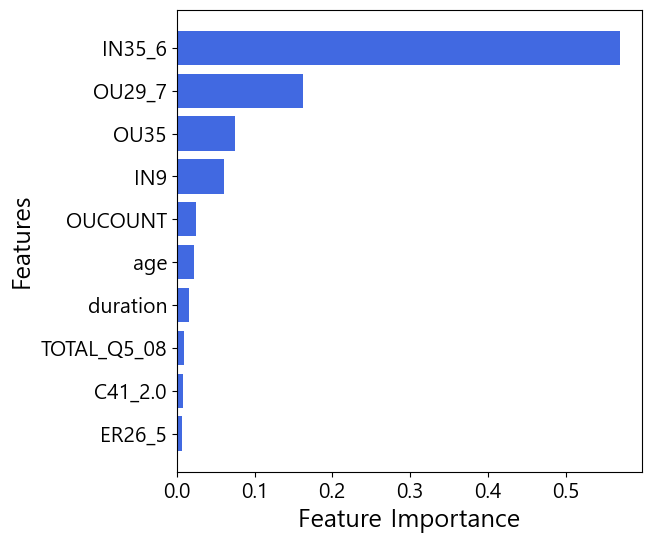

In [303]:
# 모델 학습 후 feature importance 확인
feature_importance = rf_model.feature_importances_
feature_names = X_train.columns

# 중요도 데이터프레임 생성
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 상위 20개 변수 선택
top_20_features = importance_df.head(10)

# 시각화
plt.figure(figsize=(6, 6))
plt.barh(top_20_features['Feature'], top_20_features['Importance'], color='royalblue')
plt.xlabel("Feature Importance", fontsize = 18)
plt.ylabel("Features", fontsize = 18)
#plt.title("Top 10 Features - Random Forest Importance", fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.gca().invert_yaxis()  # 중요도가 높은 변수를 위쪽에 표시
plt.show()

In [302]:
import shap

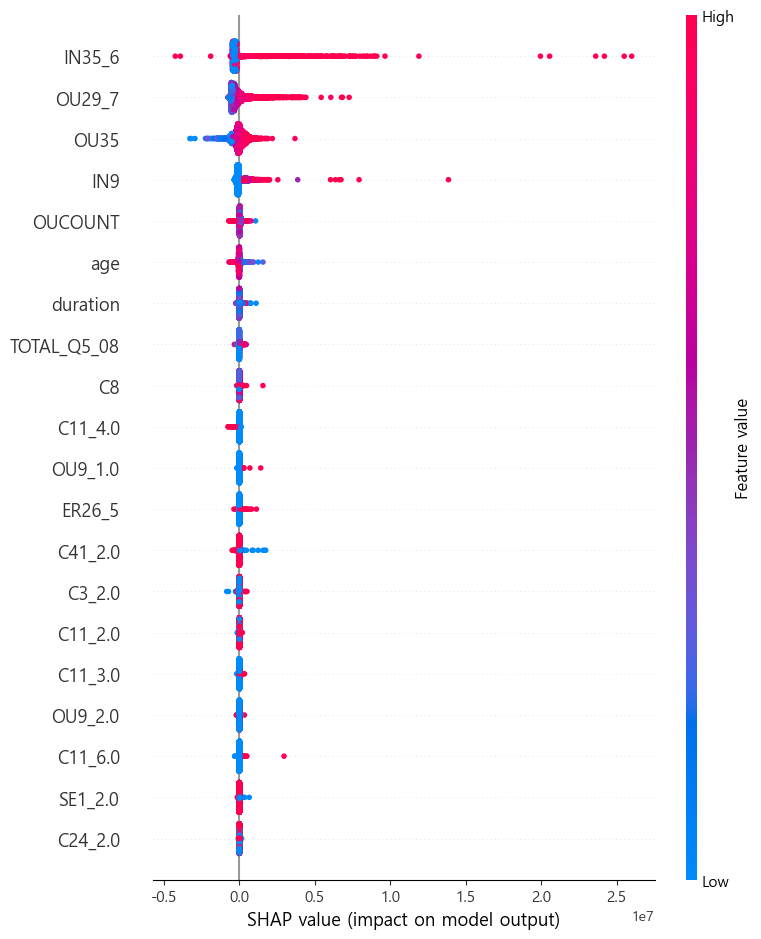

In [304]:
# SHAP 값 계산
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train)

# SHAP summary plot
shap.summary_plot(shap_values, X_train)

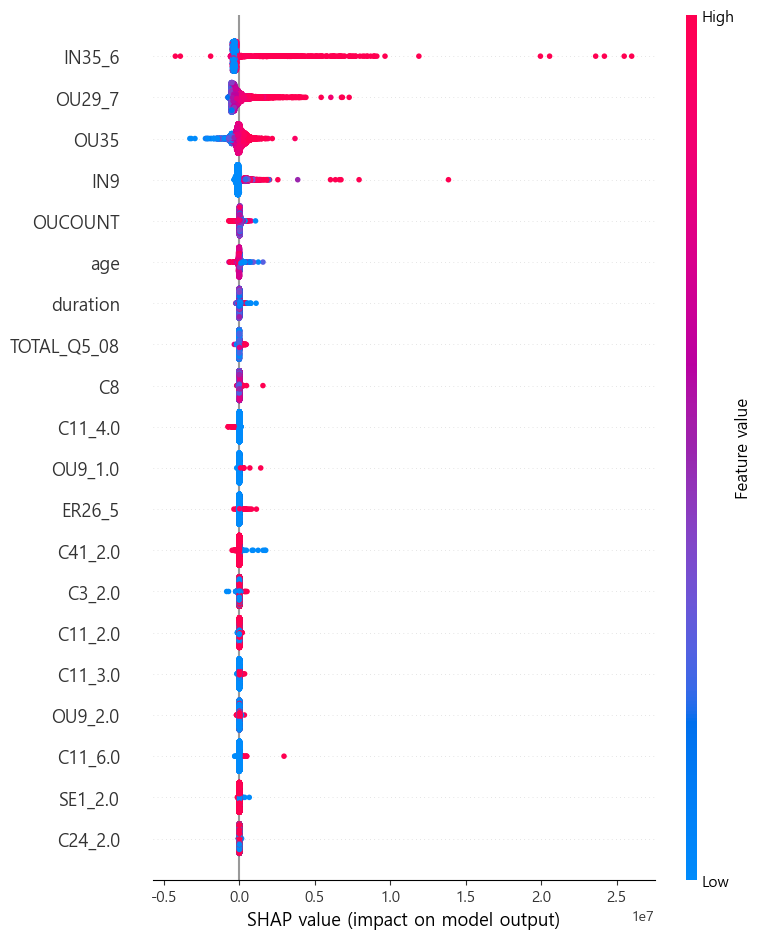

In [306]:
plt.figure(figsize = (6,6))
shap.summary_plot(shap_values, X_train)

### 5. Boosting(XGBoost)
- 부스팅은 이전 모델이 만든 오류를 보완하며 학습을 진행하는 강력한 앙상블 학습 기법  
- XGBoost는 성능 최적화와 계산 효율성을 고려한 대표적인 부스팅 알고리즘으로, 강력한 예측 성능을 제공  
- 복잡한 패턴을 학습하는 데 강점을 가지며, 성능 최적화를 위한 다양한 하이퍼파라미터 조정이 가능함  

In [289]:
# XGBoost 모델 생성 및 훈련
xgb_model = XGBRegressor(random_state = 42)
xgb_model.fit(X_train, y_train)

# 예측 수행
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

In [290]:
# 훈련 세트 평가
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# 테스트 세트 평가
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred) 
test_r2 = r2_score(y_test, y_test_pred)

# 결과 출력
print("훈련 세트 - MAE:", round(train_mae, 2), "RMSE:", round(train_rmse, 2), "R²:", round(train_r2, 2))
print("테스트 세트 - MAE:", round(test_mae, 2), "RMSE:", round(test_rmse, 2), "R²:", round(test_r2, 2))

훈련 세트 - MAE: 128524.9 RMSE: 219532.02 R²: 0.99
테스트 세트 - MAE: 497402.17 RMSE: 1066749.42 R²: 0.63


##### XGBoost 모델의 최적화  
- 과적합을 방지하고 일반화 성능을 높이기 위해 적절한 하이퍼파라미터 선택이 중요함.  
- GridSearchCV를 활용하여 최적의 파라미터를 탐색함.  

##### 주요 하이퍼파라미터 및 후보군  
- n_estimators: 생성할 트리의 개수

    - [50, 100, 200]을 탐색하여 최적 개수를 선택
    - 트리 개수가 많아질수록 성능이 향상될 가능성이 있지만, 계산 비용이 증가할 수 있음
- max_depth: 트리의 최대 깊이

    - [None, 3, 5, 10, 20]을 탐색하여 적절한 깊이를 찾음
    - 깊이가 너무 크면 과적합이 발생할 수 있으며, 너무 작으면 학습 부족 가능성이 있음
- learning_rate: 학습률
    - [0.01, 0.1, 0.2]**을 탐색하여 최적 값을 선택
    - 학습률이 클수록 빠르게 학습하지만 최적값을 지나칠 가능성이 있으며, 낮으면 안정적이지만 학습 속도가 느려질 수 있음

In [291]:
# XGBoost 모델과 하이퍼파라미터 후보군 설정
xgb_model = XGBRegressor(random_state = 42)
xgb_model.fit(X_train, y_train)

param_grid = {
    'n_estimators': [50, 100, 200],  # 트리 개수
    'max_depth': [None, 3, 5, 10, 20],  # 트리의 최대 깊이
    'learning_rate': [0.01, 0.1, 0.2],  # 학습률
}

# 그리드 서치 수행 (scoring을 MAE로 설정)
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

# 최적의 모델로 예측 수행
best_xgb = grid_search.best_estimator_
y_train_pred = best_xgb.predict(X_train)
y_test_pred = best_xgb.predict(X_test)

##### Feature Importance 
- 입원 / 의료보장형태 / 외래 관련 변수가 의료비를 예측하는데 중요한 변수로 나타남

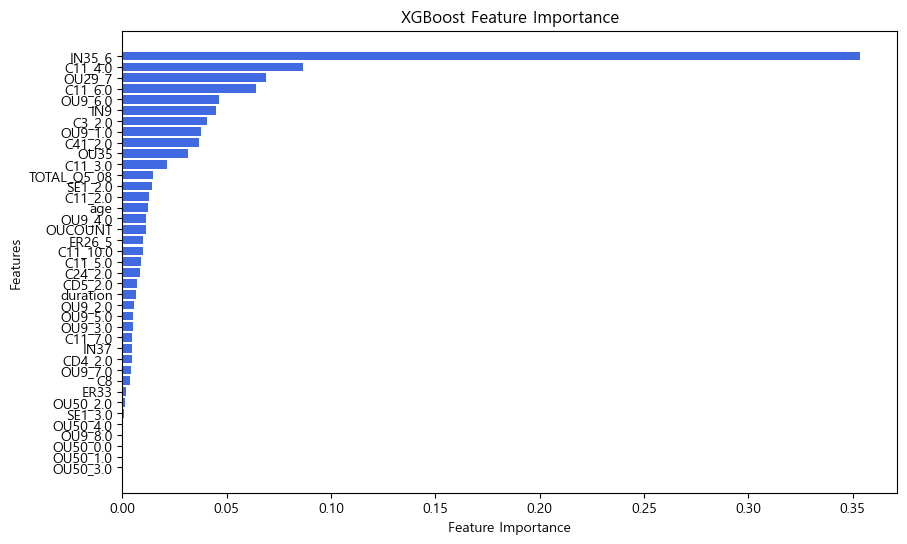

In [292]:
# 모델 학습 후 feature importance 확인
feature_importance = xgb_model.feature_importances_
feature_names = X_train.columns

# 중요도 데이터프레임 생성
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='royalblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()  # 중요도가 높은 변수를 위쪽에 표시
plt.show()

In [293]:
lst_result.append({
    'Model': 'XGBoost',
    'Train MAE': train_mae,
    'Train RMSE': train_rmse,
    'Train R²': train_r2,
    'Test MAE': test_mae,
    'Test RMSE': test_rmse,
    'Test R²': test_r2
})

In [294]:
df_result = pd.DataFrame(lst_result)
df_result

,Model,Train MAE,Train RMSE,Test MAE,Test RMSE,Test R²,Train R²
0,Linear,740467.202347,1.468999e+06,763178.978992,1.264568e+06,0.479845,NaN
1,Lasso,738307.185903,1.473721e+06,761278.390808,1.266469e+06,0.478280,0.417692
2,Ridge,740167.682554,1.470005e+06,761410.216737,1.264341e+06,0.480033,0.420626
3,Random Forest,219623.178759,5.988622e+05,480031.857555,1.064747e+06,0.631242,0.903844
4,XGBoost,128524.903391,2.195320e+05,497402.165930,1.066749e+06,0.629854,0.987078


In [295]:
df_result

,Model,Train MAE,Train RMSE,Test MAE,Test RMSE,Test R²,Train R²
0,Linear,740467.202347,1.468999e+06,763178.978992,1.264568e+06,0.479845,NaN
1,Lasso,738307.185903,1.473721e+06,761278.390808,1.266469e+06,0.478280,0.417692
2,Ridge,740167.682554,1.470005e+06,761410.216737,1.264341e+06,0.480033,0.420626
3,Random Forest,219623.178759,5.988622e+05,480031.857555,1.064747e+06,0.631242,0.903844
4,XGBoost,128524.903391,2.195320e+05,497402.165930,1.066749e+06,0.629854,0.987078


##### 모델별 성능 평가
- Test 데이터에서 가장 좋은 성능을 보인 Random Forest 모델을 최종 선정하여 분석 진행
- Random Forest는 선형 모델보다 훨씬 우수한 성능을 보임
- XGBoost와 성능 차이가 크지는 않지만, test 데이터에서는 Random Forest가 더 나은 결과를 보였음
- 범주형 변수와 수치형 변수가 혼합된 데이터 특성상, Random Forest가 이를 효과적으로 학습한 것으로 판단됨


In [296]:
df_model_result = df_result

C:\Users\ssyyy\AppData\Local\Temp\ipykernel_20948\586682736.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Test MAE', data=df_result, palette=colors)


Text(0.5, 0, 'Model')

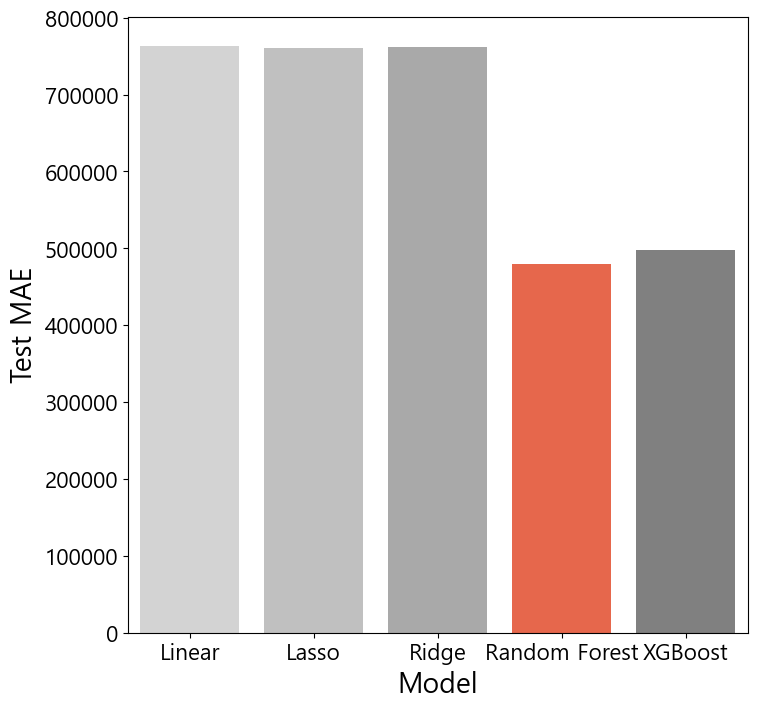

In [299]:
import matplotlib.pyplot as plt
import seaborn as sns

# 모델별 색상 리스트 (랜덤포레스트는 채도 높은 색, 나머지 모델은 채도 낮은 색)
colors = [
      # Random Forest (채도 높은 색)
    '#D3D3D3',  # XGBoost (채도 낮은 색)
    '#C0C0C0',  # Lasso (채도 낮은 색)
    '#A9A9A9',  # Ridge (채도 낮은 색)
    '#FF5733',
    '#808080'   # Linear Regression (채도 낮은 색)
]

# 그래프 그리기
plt.figure(figsize=(8, 8))
sns.barplot(x='Model', y='Test MAE', data=df_result, palette=colors)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("Test MAE", fontsize=20)
plt.xlabel("Model", fontsize=20)
#plt.title('회귀 모델 성능 비교', fontsize=23)


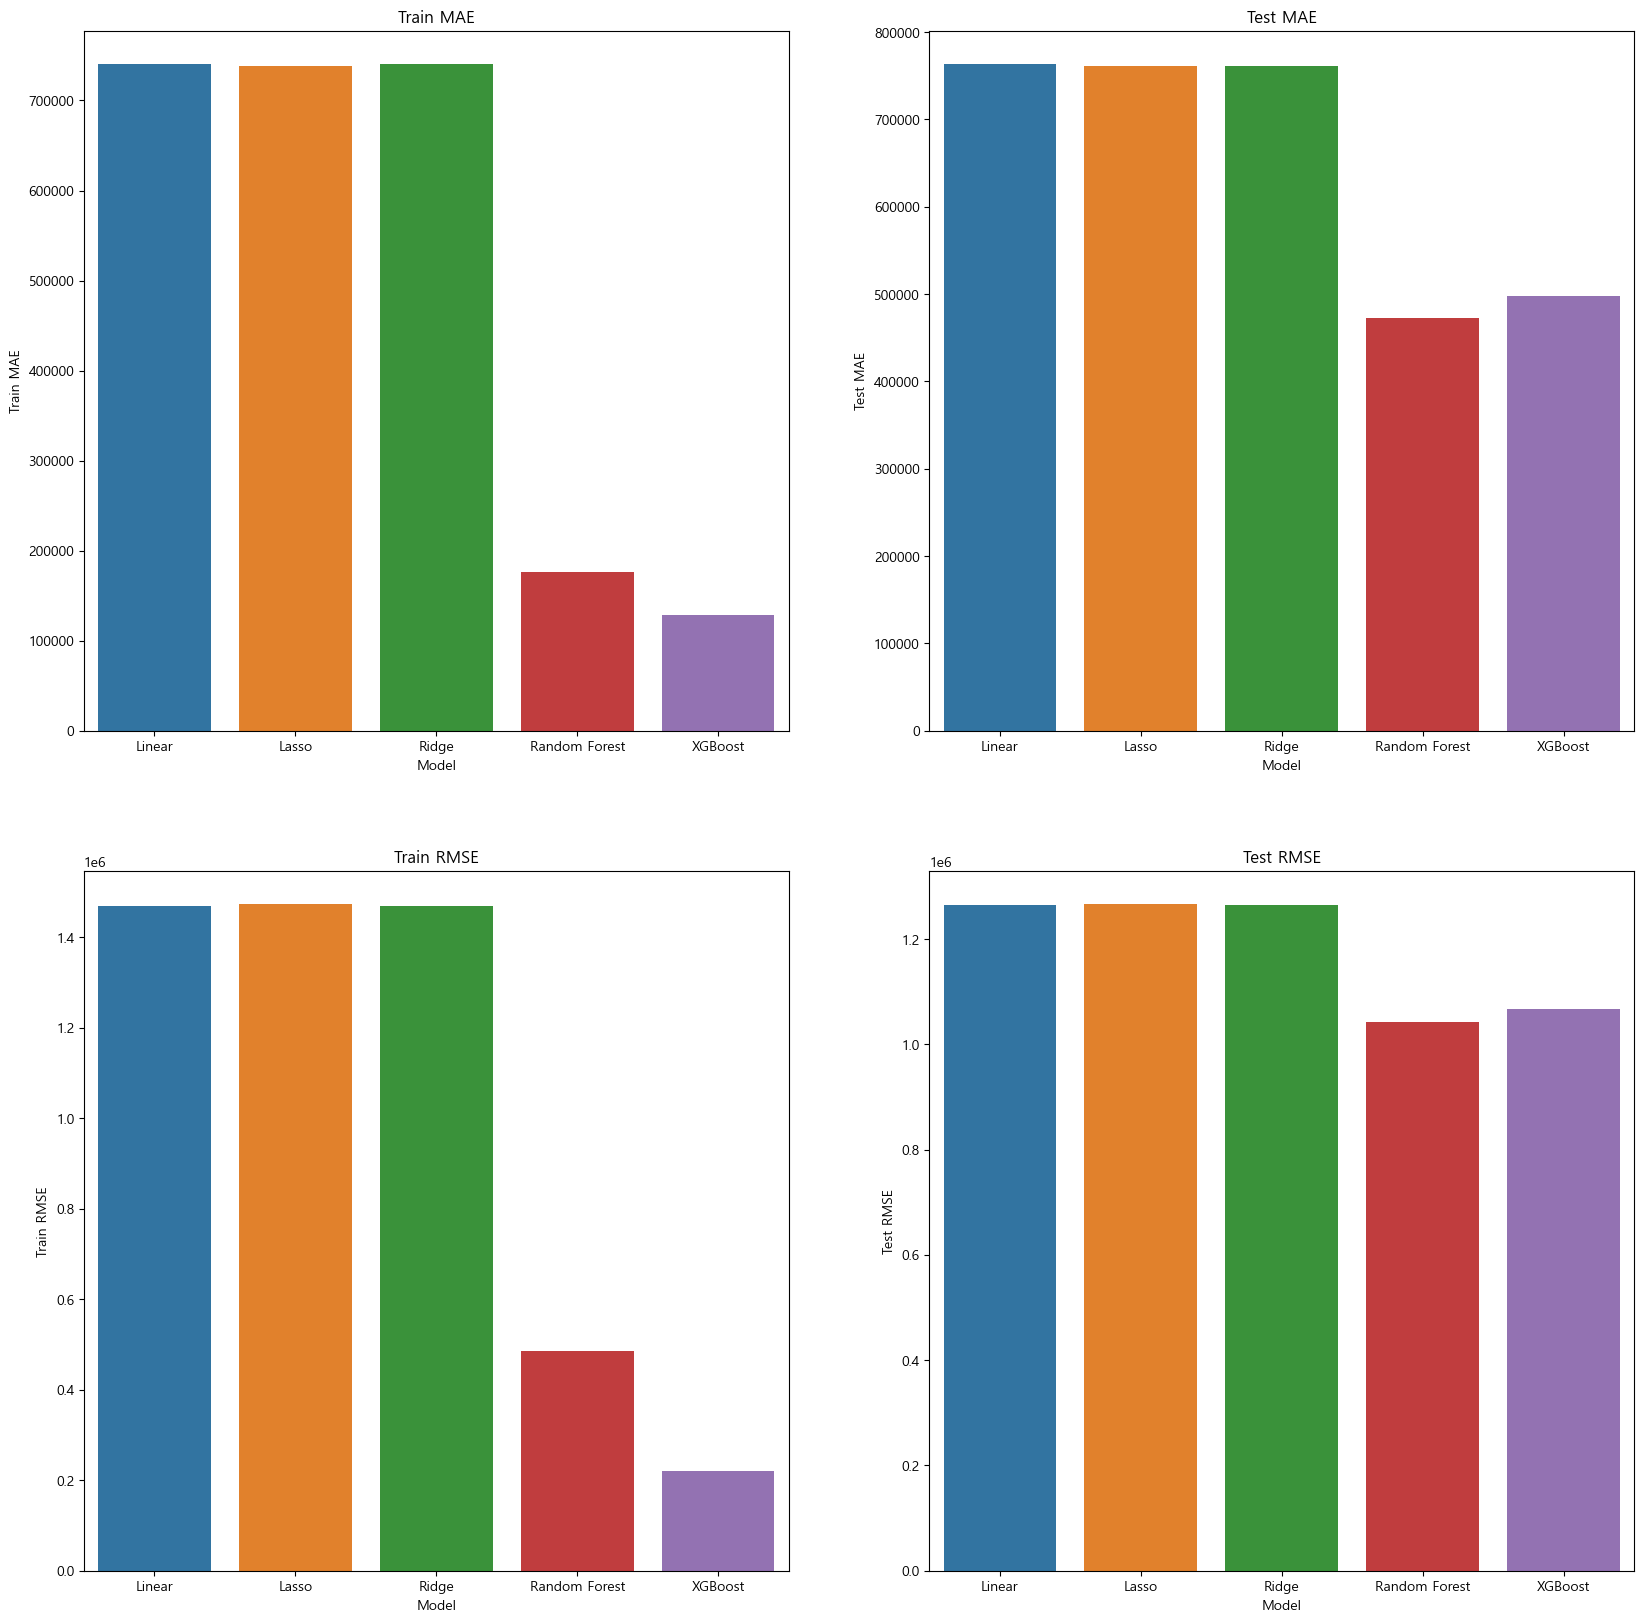

In [485]:
# 시각화 설정
plt.figure(figsize=(20, 20))

# 성능 지표 설정
metrics = ['Train MAE', 'Test MAE', 'Train RMSE', 'Test RMSE']
titles = ['Train MAE', 'Test MAE', 'Train RMSE', 'Test RMSE']

# MAE 및 RMSE를 위한 서브플롯
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    sns.barplot(x='Model', y=metric, data=df_result, hue='Model', legend=False)
    plt.title(titles[i])
    plt.ylabel(metric)

### 6. 최종 모델
- 학습에 사용하지 않은 2018년 데이터를 사용하여 2019년 의료 지출액을 예측함
- 시간에 따라 변하는 변수 : 나이와 당뇨병을 진단받은 후 경과한 기간
- 변하지 않는 변수 : 성별, 교육 수준 등
- 시간에 따라 변하는 변수는 1씩 증가하여 학습에 사용함

In [119]:
# 학습에 사용하지 않은 2018년 데이터 사용
df_train_18 = df_dt[df_dt['year'] == 2018]

In [120]:
df_train_18.loc[:, 'age'] = df_train_18['age'] + 1
df_train_18.loc[:,'duration'] = df_train_18['duration'] + 1

In [121]:
X = df_train_18.drop(['year','I_MEDICALEXP1'], axis = 1)
X.columns

Index(['C8', 'TOTAL_Q5_08', 'age', 'duration', 'OU35', 'OUCOUNT', 'OU29_7',
       'IN35_6', 'IN9', 'ER26_5', 'IN37', 'ER33', 'C3_2.0', 'C11_2.0',
       'C11_3.0', 'C11_4.0', 'C11_5.0', 'C11_6.0', 'C11_7.0', 'C11_10.0',
       'C24_2.0', 'C41_2.0', 'CD4_2.0', 'CD5_2.0', 'OU9_1.0', 'OU9_2.0',
       'OU9_3.0', 'OU9_4.0', 'OU9_5.0', 'OU9_6.0', 'OU9_7.0', 'OU9_8.0',
       'SE1_2.0', 'SE1_3.0', 'OU50_0.0', 'OU50_1.0', 'OU50_2.0', 'OU50_3.0',
       'OU50_4.0'],
      dtype='object')

In [122]:
predict_expense_2019 = best_rf.predict(X)
predict_expense_2019

array([2368741.65507941, 2523989.45043343,  781686.70982598, ...,
       5791697.0381373 ,  986771.75390354, 3819613.60522543])

In [123]:
# 예측값을 포함한 데이터프레임 생성
df_exp_2019 = pd.DataFrame({
    'predicted_expense_2019': predict_expense_2019
})

# 결과 
df_exp_2019

,predicted_expense_2019
0,2.368742e+06
1,2.523989e+06
2,7.816867e+05
3,4.009765e+05
4,1.324611e+06
...,...
1550,4.188436e+05
1551,3.503201e+05
1552,5.791697e+06
1553,9.867718e+05


In [130]:
df_exp_2019.mean()

predicted_expense_2019    1.583362e+06
dtype: float64

In [125]:
df['I_MEDICALEXP1'].max()

35446780.0

In [126]:
df.sort_values(by = ['I_MEDICALEXP1'], ascending = False).head(30)

,PIDWON,CD3_1,CD4,CD5,year,C3,C8,C11,C24,C41,TOTAL_Q5_08,I_MEDICALEXP1,ER33,ER26_5,IN9,IN35_6,IN37,OUCOUNT,OU9,OU29_7,OU35,OU50,SE1,age,duration
3061,1226002.0,43.0,1.0,1.0,2016,2.0,4,2.0,2.0,2.0,5.0,35446780.0,0.0,0.0,78.0,91333866.0,0.0,51.0,5.0,10690099.0,277700.0,-1.0,2.0,50.0,7.0
1648,1226002.0,43.0,1.0,1.0,2015,2.0,4,2.0,1.0,2.0,4.0,30745440.0,0.0,220804.0,42.0,77113993.0,0.0,57.0,2.0,2597303.0,1920280.0,-1.0,2.0,49.0,6.0
1232,3149802.0,61.0,1.0,1.0,2014,2.0,2,3.0,2.0,1.0,1.0,28655555.0,0.0,0.0,211.0,70594903.0,39200.0,113.0,2.0,2683804.0,862260.0,-1.0,2.0,65.0,4.0
2643,3149802.0,61.0,1.0,1.0,2015,2.0,2,3.0,2.0,2.0,1.0,27102360.0,0.0,259139.0,179.0,67269083.0,0.0,30.0,1.0,1033209.0,582100.0,-1.0,2.0,66.0,5.0
2363,1812201.0,57.0,1.0,1.0,2015,1.0,4,2.0,1.0,1.0,5.0,24275957.0,0.0,0.0,46.0,47912641.0,0.0,45.0,2.0,1739495.0,231950.0,-1.0,1.0,58.0,1.0
1193,3127902.0,59.0,1.0,1.0,2014,2.0,4,3.0,2.0,2.0,1.0,22601500.0,0.0,0.0,384.0,0.0,0.0,1.0,2.0,14770.0,0.0,-1.0,2.0,81.0,22.0
119,1104201.0,55.0,1.0,1.0,2014,1.0,4,6.0,1.0,2.0,5.0,20944420.0,0.0,0.0,0.0,0.0,0.0,82.0,2.0,1826665.0,427660.0,-1.0,2.0,66.0,11.0
2389,2006001.0,65.0,1.0,1.0,2015,1.0,3,2.0,1.0,2.0,3.0,20624773.0,0.0,189974.0,136.0,68647438.0,0.0,83.0,2.0,10550610.0,299950.0,-1.0,2.0,67.0,2.0
2266,1742102.0,58.0,1.0,1.0,2015,2.0,3,2.0,2.0,2.0,3.0,18829330.0,0.0,0.0,4.0,0.0,0.0,48.0,1.0,896182.0,494310.0,-1.0,2.0,66.0,8.0
2925,1104201.0,55.0,1.0,1.0,2016,1.0,4,6.0,2.0,2.0,5.0,18644790.0,0.0,2131040.0,34.0,74487342.0,0.0,76.0,3.0,25536031.0,336719.0,-1.0,2.0,68.0,13.0


<Axes: ylabel='Count'>

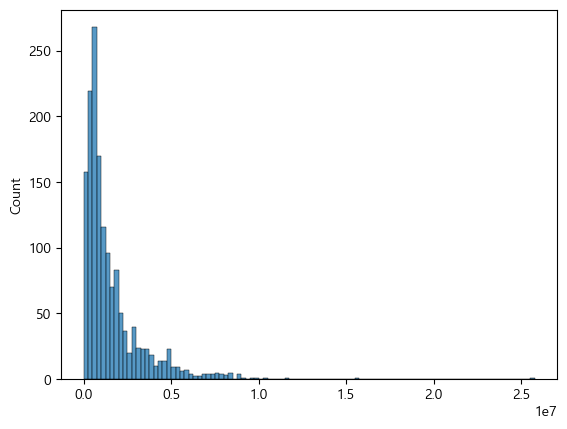

In [127]:
sns.histplot(predict_expense_2019)

In [128]:
np.min(predict_expense_2019)

17.779389918065228

-1669961.0991613762 510291.59052022453 947249.8340948838 1963793.3836412919 4144046.0733228927


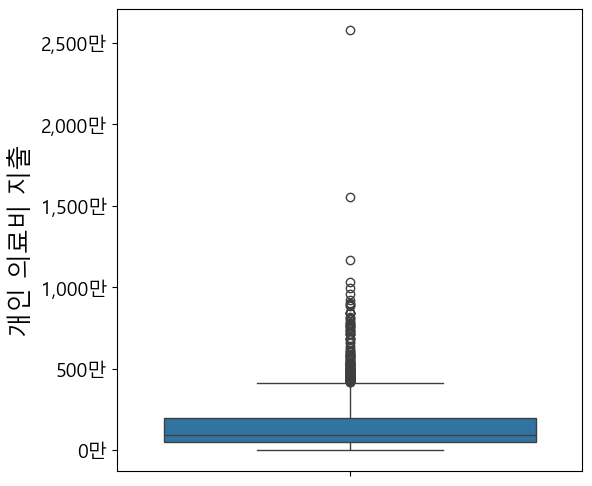

In [301]:
plt.figure(figsize = (6, 6))
sns.boxplot(data = predict_expense_2019)
plt.yticks(fontsize=14)
#plt.title('2019년 의료비 분포{}'.format, fontsize = 20)
median = np.median(predict_expense_2019)
Q1 = np.percentile(predict_expense_2019, 25)  # 1사분위(Q1)
Q3 = np.percentile(predict_expense_2019, 75) 
IQR = Q3-Q1

plt.ylabel('개인 의료비 지출', fontsize = 18)

print(Q1 - 1.5*IQR, Q1, median, Q3, Q3 + 1.5*IQR) 
# y축 포맷 설정
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ticks))
plt.show()

In [767]:
print(f"2019년 예측 의료비: {round(predict_expense_2019.mean(), 0)}만원" )

2019년 예측 의료비: 1579924.0만원


##### 연도별 교차 검증을 통한 모델 성능 평가
- Random Forest 회귀 모델을 사용하여 특정 연도별로 데이터의 예측 성능을 평가함

In [112]:
# 학습에 필요한 컬럼 추출
lst_cols = df_train.columns.tolist()

In [113]:
# 교차 검증 사용 데이터
df_dt[lst_cols]

,C8,TOTAL_Q5_08,age,duration,OU35,OUCOUNT,OU29_7,IN35_6,IN9,ER26_5,IN37,ER33,year,I_MEDICALEXP1,C3_2.0,C11_2.0,C11_3.0,C11_4.0,C11_5.0,C11_6.0,C11_7.0,C11_10.0,C24_2.0,C41_2.0,CD4_2.0,CD5_2.0,OU9_1.0,OU9_2.0,OU9_3.0,OU9_4.0,OU9_5.0,OU9_6.0,OU9_7.0,OU9_8.0,SE1_2.0,SE1_3.0,OU50_0.0,OU50_1.0,OU50_2.0,OU50_3.0,OU50_4.0
0,6,4.0,61.0,4.0,10.547996,2.944439,11.583952,0.000000,0.000000,0.000000,0.0,0.000000,2014,10067300.0,0,0,1,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,5,3.0,59.0,3.0,11.887251,2.197225,12.265873,0.000000,0.000000,0.000000,0.0,0.000000,2014,254750.0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,3.0,58.0,1.0,12.143883,3.258097,14.308124,0.000000,0.000000,12.271242,0.0,8.157944,2014,1596730.0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,5.0,53.0,2.0,11.520904,3.367296,13.089621,0.000000,0.000000,0.000000,0.0,0.000000,2014,266010.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
4,4,5.0,47.0,11.0,12.481349,3.713572,14.018622,0.000000,0.000000,0.000000,0.0,0.000000,2014,872758.0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7296,2,1.0,66.0,6.0,11.755879,3.135494,13.467683,0.000000,0.000000,0.000000,0.0,0.000000,2018,467400.0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7297,5,1.0,70.0,7.0,11.103467,3.178054,13.345669,0.000000,0.000000,0.000000,0.0,0.000000,2018,220160.0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7298,1,1.0,86.0,18.0,12.153204,3.091042,13.595876,16.751429,4.406719,11.718263,0.0,0.000000,2018,5384290.0,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7299,2,1.0,68.0,10.0,12.948322,4.060443,14.263489,0.000000,0.000000,0.000000,0.0,0.000000,2018,918230.0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


##### 연도별 모델 학습 및 검증

In [139]:
# 결과를 저장할 리스트 초기화
lst_result = []

for validation_year in [2015, 2016, 2017, 2018]:
    # 훈련 데이터와 검증 데이터 선택
    X_train = df_dt.loc[df_dt['year'] < validation_year, lst_cols]
    y_train = df_dt.loc[df_dt['year'] < validation_year, target_col]
    
    X_val = df_dt.loc[df_dt['year'] == validation_year, lst_cols]
    y_val = df_dt.loc[df_dt['year'] == validation_year, target_col]

    train =  X_train.drop(['year','I_MEDICALEXP1'], axis = 1)
    val = X_val.drop(['year','I_MEDICALEXP1'], axis = 1)
    
    
    best_rf.fit(train, y_train)
    
    # 예측
    pred_val_ls = best_rf.predict(val)

    # 평가지표 계산
    mse = mean_squared_error(y_val, pred_val_ls)
    mae = mean_absolute_error(y_val, pred_val_ls)
    r2 = r2_score(y_val, pred_val_ls)
    
    # 결과 저장
    lst_result.append({
        'year': validation_year,
        'predictions': pred_val_ls.mean(),
        'real_price' : y_val.mean(),
        'mae': round(mae),
        'rmse': round(np.sqrt(mse)),
        'r2': r2
    })

In [140]:
# 결과를 데이터프레임으로 변환
df_result = pd.DataFrame(lst_result)
df_result

,year,predictions,real_price,mae,rmse,r2
0,2015,1.240361e+06,1.305468e+06,433104,1201476,0.692611
1,2016,1.408879e+06,1.373301e+06,435036,1030449,0.754577
2,2017,1.487771e+06,1.354085e+06,429723,1086541,0.590298
3,2018,1.586301e+06,1.411852e+06,474224,1046760,0.643596


In [141]:
# 2019년 예측값 추가
new_row = pd.DataFrame({
    'year': [2019],
    'predictions': [predict_expense_2019.mean()]
})

# 데이터프레임에 새로운 행 추가
df_result = pd.concat([df_result, new_row], ignore_index=True)

In [142]:
df_result

,year,predictions,real_price,mae,rmse,r2
0,2015,1.240361e+06,1.305468e+06,433104.0,1201476.0,0.692611
1,2016,1.408879e+06,1.373301e+06,435036.0,1030449.0,0.754577
2,2017,1.487771e+06,1.354085e+06,429723.0,1086541.0,0.590298
3,2018,1.586301e+06,1.411852e+06,474224.0,1046760.0,0.643596
4,2019,1.583362e+06,NaN,NaN,NaN,NaN


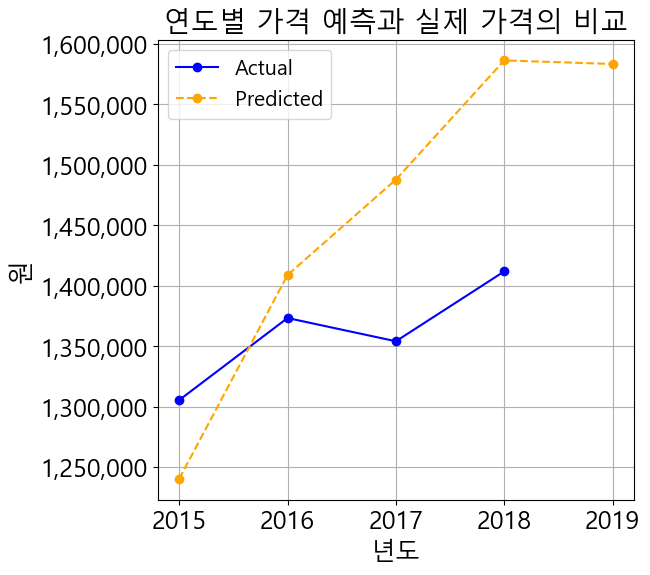

In [143]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
# 각 평가지표를 플로팅
# y축 포맷터 함수 정의
def format_y_ticks(x, pos):
    return f'{int(x):,}'  # 천 단위로 구분하여 문자열로 반환

plt.figure(figsize=(6, 6))
plt.plot(df_result['year'], df_result['real_price'], marker='o', linestyle='-', color='blue', label='Actual' )
plt.plot(df_result['year'], df_result['predictions'], marker='o', linestyle='--', color='orange', label='Predicted')

plt.title('연도별 가격 예측과 실제 가격의 비교', fontsize = 20)
plt.xlabel('년도', fontsize = 18)
plt.ylabel('원', fontsize = 18)
plt.xticks(df_result['year'],  fontsize = 18)  
plt.yticks(fontsize = 18) 
plt.grid()
plt.legend(fontsize = 15)

plt.tight_layout()  # 서브플롯 간의 간격 조정
# y축 포맷 설정
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
plt.show()


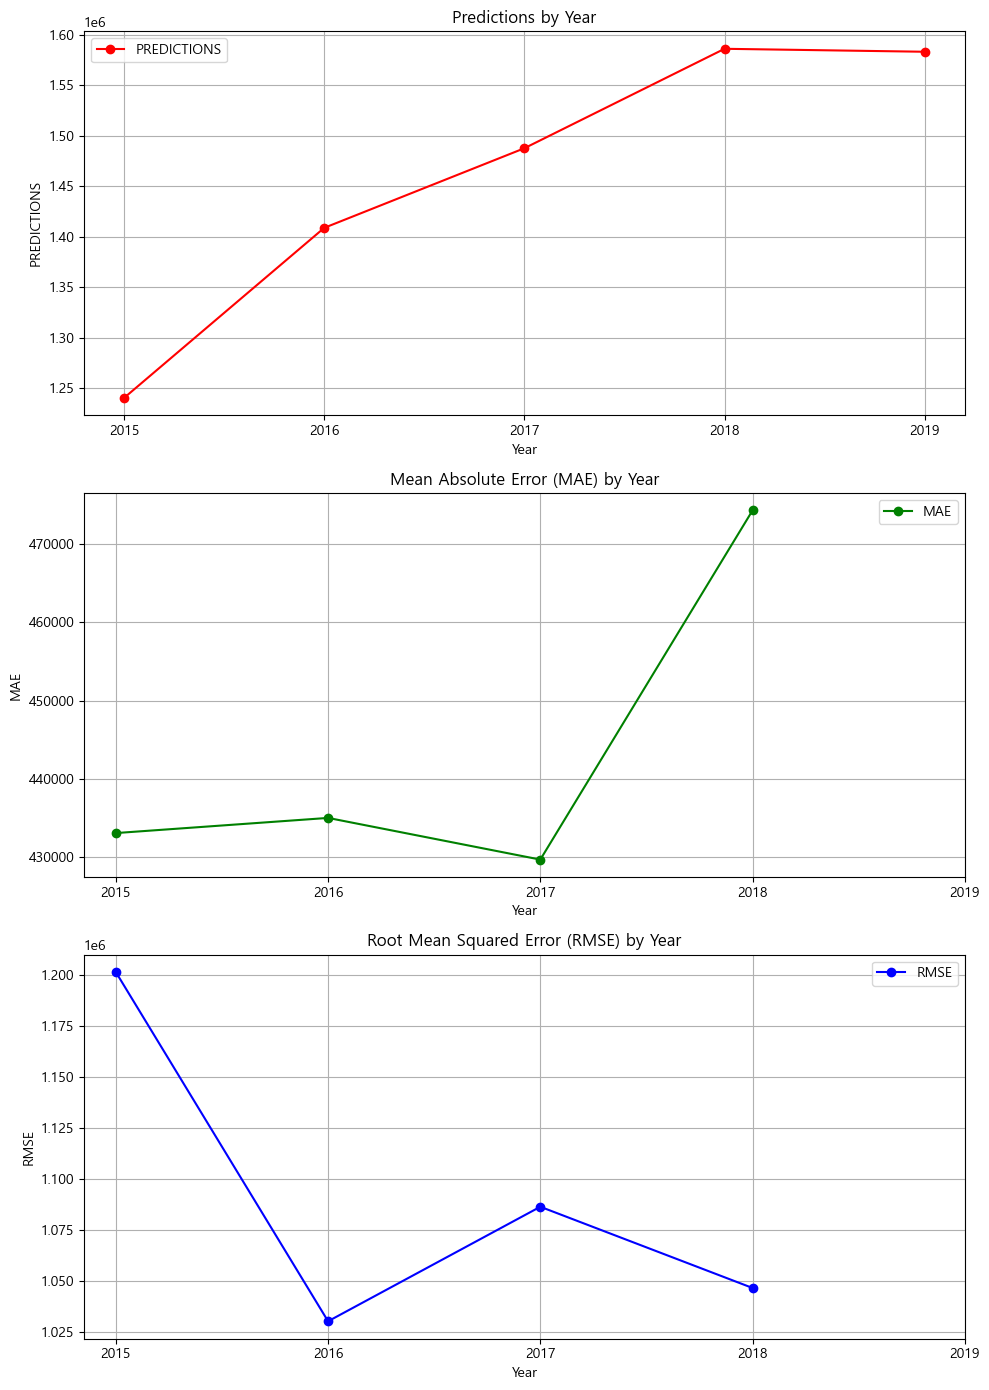

In [144]:
# 평가지표와 색상 설정
metrics = ['predictions', 'mae', 'rmse']
colors = ['r', 'g', 'b']
titles = [
    'Predictions by Year', 
    'Mean Absolute Error (MAE) by Year', 
    'Root Mean Squared Error (RMSE) by Year'
]

# 플롯 설정
plt.figure(figsize=(10, 14))

# 각 평가지표를 플로팅
for i, metric in enumerate(metrics):
    plt.subplot(len(metrics), 1, i + 1)
    plt.plot(df_result['year'], df_result[metric], marker='o', linestyle='-', color=colors[i], label=metric.upper())
    plt.title(titles[i])
    plt.xlabel('Year')
    plt.ylabel(metric.upper())
    plt.xticks(df_result['year'])  
    plt.grid()
    plt.legend()

# 전체 플롯 간격 조정
plt.tight_layout()
plt.show()

# 과제 # 3. 결과 해석

## 3-1. 모델 결과 해석
### 1. 선형회귀

1) 모델 적합도 분석
- 결정 계수 : 의료비 지출의 변동 중 42%를 설명함
- F-statistic : p-value가 0.05보다 작게 나타나므로 모델은 통계적으로 유의미함

2) 통계적으로 유의미한 변수
- 39개의 변수 중 20개의 변수가 유의미하게 나타남

3) 다중공선성
- Cond. No.의 값 높게 나타나 다중공선성 문제를 확인함
- 다중공선성이 있는 경우, 특정 변수들의 상관관계가 높아 모델 해석이 왜곡될 수 있음.

4) 결론
- 결정 계수가 높지 않지만, 유의미한 변수를 찾을 수 있음
- 다중공선성이 있기 때문에 릿지나 라쏘 모델 적용 고려

In [454]:
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:          I_MEDICALEXP1   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     109.4
Date:                Thu, 27 Feb 2025   Prob (F-statistic):               0.00
Time:                        05:40:17   Log-Likelihood:                -89747.
No. Observations:                5746   AIC:                         1.796e+05
Df Residuals:                    5707   BIC:                         1.798e+05
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.882e+06   2.58e+05     -7.303      

In [455]:
# p-value가 0.05보다 작은 유의미한 변수 추출
significant_vars = ols.pvalues[ols.pvalues < 0.05]
print("\n유의미한 변수 (p-value < 0.05):")
print(significant_vars)


유의미한 변수 (p-value < 0.05):
const           3.197225e-13
C8              1.453917e-05
TOTAL_Q5_08     6.996887e-05
age             2.888421e-02
duration        2.016120e-02
OU35            4.274448e-04
OUCOUNT         8.216119e-24
OU29_7          1.659938e-23
IN9            1.041147e-163
ER26_5          1.386745e-06
IN37            2.538335e-05
ER33            2.635020e-02
C11_4.0         1.163128e-14
C11_5.0         1.131911e-05
C11_10.0        1.638077e-03
OU9_1.0         4.446523e-04
OU9_2.0         3.256157e-04
OU9_3.0         8.589426e-07
OU9_4.0         9.721130e-04
OU9_7.0         2.399372e-02
OU50_0.0        8.276460e-14
dtype: float64


의료비에 영향을 미치는 변수
##### [로그변환 변수]
- log(OUCOUNT) : 외래 진료 횟수(OUCOUNT)가 1% 증가하면, 의료비가 약 325,800원 증가
- log(OU29_7) : 외래 진료비(OU29_7)가 1% 증가하면, 의료비가 110,600원 증가
- log(IN9) : 입원일수(IN9)가 1% 증가하면, 의료비가 약 90,770원 증가
- log(ER26_5) : 응급 진료비(ER26_5)이 1% 증가하면, 의료비가 약 301원 증가
- log(IN37) : 입원 처방약 값(IN37) 관련 의료 서비스가 1% 증가하면, 의료비가 약 119,100원 증가
- log(ER33) : 응급 처방약 값 (ER33)  1% 증가하면, 의료비가 약 59,000원 감소
- log(OU35) : 외래 처방약 값(OU35)이 1% 증가하면, 의료비가 약 45,300원 증가

##### [로그변환하지 않은 변수]
- C8(교육수준) : C8 변수가 1 증가하면, 의료비가 약 83,900원 증가
- TOTAL_Q5_08(가구소득) :  TOTAL_Q5_08 변수가 1 증가하면, 의료비가 약 61,400원 증가
- age(나이) : 나이가 1세 증가할 때, 의료비가 약 4,833원 감소
- duration(당뇨 경과 기간) : 치료 기간(duration)이 1 단위 증가하면, 의료비가 약 6,032원 증가


[의료보장형태]
- C11_4.0(의료보장형태 : 의료급여1) : 특정 집단(C11_4.0)은 기준 집단보다 의료비가 약 104만 원 적음
- C11_5.0(의료보장형태 : 의료급여2) : 특정 집단(C11_5.0)은 기준 집단보다 의료비가 약 96만 원 적음
- C11_10.0(의료보장형태 : 건강보험 + 차상위) : 특정 집단(C11_10.0)은 기준 집단보다 의료비가 약 64만 원 적음

[방문유형] : 동일 질환으로 첫방문, 재방문인지
- OU9_1.0(첫방문) : OU9_1.0이 1 증가하면, 의료비가 약 39만 원 감소
- OU9_2.0(재방문) : OU9_2.0이 1 증가하면, 의료비가 약 39.8만 원 감소
- OU9_3.0(정기적) : OU9_3.0이 1 증가하면, 의료비가 약 52.9만 원 감소
- OU9_4.0(첫방문 + 정기) : OU9_4.0이 1 증가하면, 의료비가 약 58만 원 감소
- OU9_7.0(첫방문 + 재방문) : OU9_7.0이 1 증가하면, 의료비가 약 54.2만 원 감소

[치료여부] : OU50 (1) 치료 중인 경우
- OU50_0.0 : OU50_0.0이 1 증가하면, 의료비가 약 159만 원 증가

<strong> 결론 </strong>
- 의료비는 의료 이용량(외래 진료, 입원, 응급 치료 등), 경제적 요인(소득, 교육 수준), 의료 보장 제도, 방문 유형에 따라 차이가 발생하는 것으로 나타남.
- 입원 및 응급 진료 이용량이 의료비 증가에 가장 큰 영향을 미치는 요인으로 분석됨
- 소득 및 교육 수준이 높을수록 의료비 증가 : 소득과 교육 수준이 높은 계층에서 의료비가 더 많이 지출되는 경향을 보임. 
- 의료 보장 형태에 따른 의료비 차이 : 의료 급여 대상자는 건강보험 가입자에 비해 의료비 부담이 낮은 것으로 나타남
- 방문 유형에 따른 의료비 차이 : 첫 방문보다는 지속적인 관리가 이루어질 때 의료비 부담이 낮아지는 경향을 보임.

In [462]:
len(significant_vars.index)

21

In [464]:
significant_vars.index

Index(['const', 'C8', 'TOTAL_Q5_08', 'age', 'duration', 'OU35', 'OUCOUNT',
       'OU29_7', 'IN9', 'ER26_5', 'IN37', 'ER33', 'C11_4.0', 'C11_5.0',
       'C11_10.0', 'OU9_1.0', 'OU9_2.0', 'OU9_3.0', 'OU9_4.0', 'OU9_7.0',
       'OU50_0.0'],
      dtype='object')

In [465]:
# 로그변환 적용 변수
lst_log_transform

['OUCOUNT', 'OU29_7', 'IN35_6', 'IN9', 'ER26_5', 'IN37', 'ER33', 'OU35']

### 2. Lasso 
##### 의료비 증가에 미치는 변수
- OU50(치료 여부) : 치료 중인 경우, 의료비를 약 151만원 증가
- log(IN9)(입원 일수) : 입원이 1% 증가할 때 의료비 약 890,200원 증가
- log(OUCOUNT)(외래 이용횟수) : 외래 방문 횟수가 1% 증가할 때 의료비 약 292,200원 증가
<br></br>
##### 의료비 감소에 미치는 변수
- log(ER33)(응급 처방약 값) : 응급 처방약 값(ER33)이 1% 증가하면 의료비 약 477원 감소
- C11_4.0(의료보장형태 : 건강보험 + 차상위 경감) : 건강보험 + 차상위 경감 대상자일 때, 의료비 약 97,451원 감소
- C11_4.0(의료보장형태 : 건강보험 + 차상위 경감) : 건강보험 + 차상위 경감 대상자일 때, 의료비 약 97,451원 감소

In [466]:
coef_df_lasso

,Feature,Coefficient
34,OU50_0.0,1.511669e+06
8,IN9,8.902641e+05
5,OUCOUNT,2.922177e+05
14,C11_3.0,1.363665e+05
10,IN37,1.056887e+05
6,OU29_7,1.025274e+05
0,C8,7.838994e+04
13,C11_2.0,6.411588e+04
1,TOTAL_Q5_08,6.406409e+04
20,C24_2.0,4.778553e+04


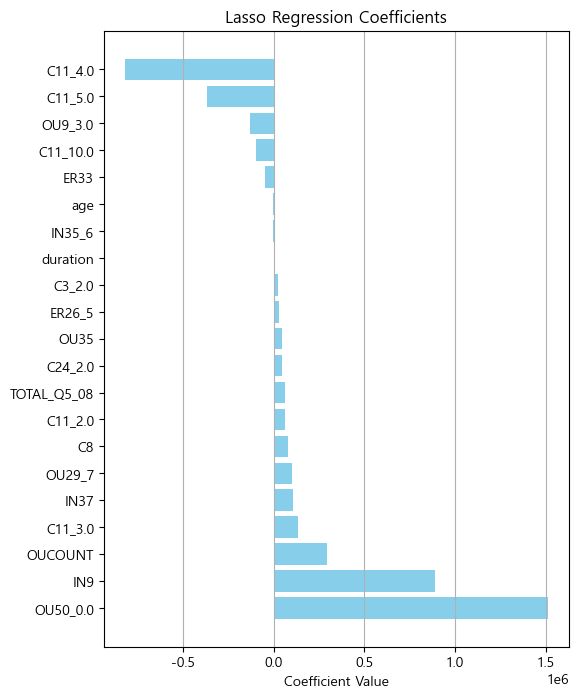

In [458]:
# 시각화
plt.figure(figsize=(6, 8))
plt.barh(coef_df_lasso['Feature'], coef_df_lasso['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Lasso Regression Coefficients')
plt.grid(axis='x')
plt.show()

### 3. Ridge
##### 의료비 증가에 미치는 변수
- OU50(치료 여부) : 치료 중인 경우, 의료비를 약 143만원 증가
- log(IN9)(입원 일수) : 입원이 1% 증가할 때 의료비 약 9,004원 증가
- log(OUCOUNT)(외래 이용횟수) : 외래 방문 횟수가 1% 증가할 때 의료비 약 3,132원 증가
<br></br>
##### 의료비 감소에 미치는 변수
- C11_4.0(의료급여1) : 의료급여1 대상자일 때, 기준 집단보다 의료비가 약 91만 원 감소
- C11_5.0(의료급여2) : 의료급여2 대상자일 때, 기준 집단보다 의료비가 약 72만 원 감소
- C11_10.0(의료보장형태 : 건강보험 + 차상위 경감) : 건강보험 + 차상위 경감 대상자일 때, 의료비 약 47만 원  감소

In [467]:
coef_df_ridge

,Feature,Coefficient
34,OU50_0.0,1.431615e+06
8,IN9,9.004374e+05
5,OUCOUNT,3.132076e+05
22,CD4_2.0,2.001227e+05
38,OU50_4.0,1.732140e+05
14,C11_3.0,1.553506e+05
10,IN37,1.183432e+05
29,OU9_6.0,1.064832e+05
6,OU29_7,1.048160e+05
17,C11_6.0,9.733932e+04


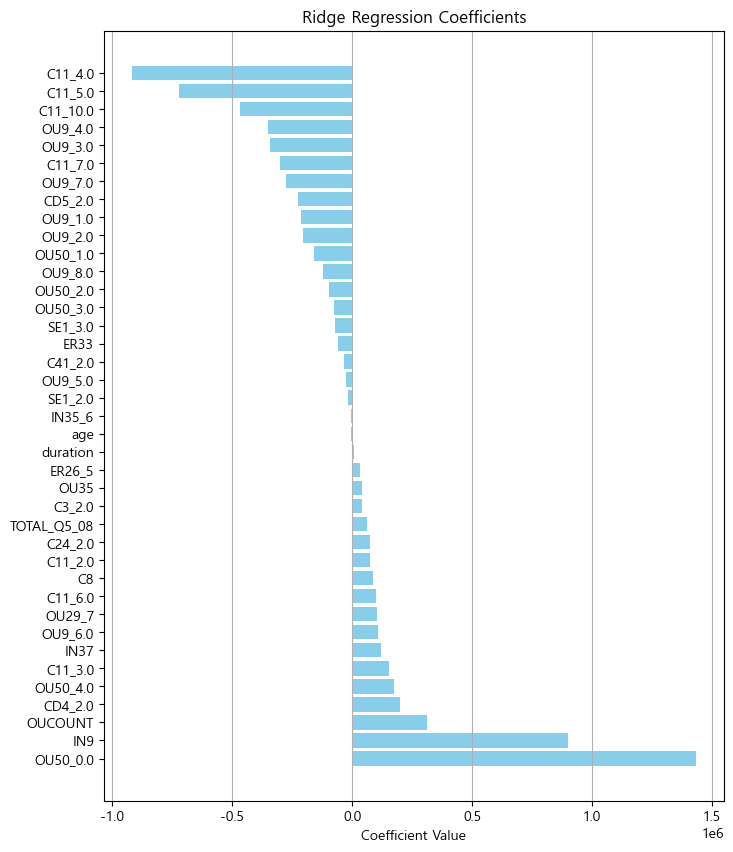

In [459]:
# 시각화
plt.figure(figsize=(8, 10))
plt.barh(coef_df_ridge['Feature'], coef_df_ridge['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Ridge Regression Coefficients')
plt.grid(axis='x')
plt.show()

## 3-2. 통계 검정 개념

#### 1. Shapiro-Wilk 검정
- 데이터가 정규 분포를 따르는지 검증하는 데 사용되는 방법
- 검정 통계량이 작을수록 데이터가 정규 분포에서 벗어날 가능성이 높음.
    -  귀무가설(H₀): 데이터가 정규 분포를 따른다.
    - 대립가설(H₁): 데이터가 정규 분포를 따르지 않는다.
- p-value가 유의수준보다 작으면 귀무가설을 기각하고, 데이터가 정규 분포를 따르지 않는다고 판단함.

#### 2. 등분산성 검정
- 두 개 이상의 그룹 간 분산이 동일한지를 검정하는 방법

- Levene's Test
    -  귀무가설(H₀): 각 그룹의 분산이 동일하다.
    - 대립가설(H₁): 각 그룹의 분산이 동일하지 않는다.
- 가장 널리 사용되는 방법으로, 각 그룹의 중위수를 기반으로 분산의 동질성을 검정
- p-value가 유의수준보다 작으면 귀무가설을 기각하고, 등분산성을 만족하지 않는다고 판단함.

#### 3. ANOVA (Analysis of Variance, 분산 분석
- ANOVA는 세 개 이상의 그룹 간 평균 차이가 통계적으로 유의미한지 검증하는 방법
- 독립 변수가 종속 변수에 미치는 영향을 분석하는 데 사용함.

    - 귀무가설(H₀): 독립변수의 차이에 따른 종속변수는 동일하다.
    - 대립가설(H₁): 독립변수의 차이에 따른 종속변수는 다르다.
- p-value가 유의수준보다 작으면 귀무가설을 기각하고, 그룹 간 차이가 유의미하다고 판단.

<strong>ANOVA 수행 시 가정해야 할 조건</strong>
1. 정규성: 각 그룹의 데이터가 정규 분포를 따라야 함.
- 검정 방법: Shapiro-Wilk test, Q-Q plot
2. 등분산성: 모든 그룹의 분산이 비슷해야 함.
- 검정 방법: Levene's test
3. 독립성: 각 그룹의 샘플이 서로 독립적이어야 함.

#### 4. Kruskal-Wallis 검정
- ANOVA의 정규성 가정이 만족되지 않을 때 사용하는 비모수 검정법
- 모수 검정(ANOVA)은 정규성과 등분산성을 만족해야 하지만, Kruskal-Wallis 검정은 그렇지 않아도 사용 가능.
- 신뢰도는 모수 검정보다 낮을 수 있음.

    - 귀무가설(H₀): 모든 그룹의 중앙값은 서로 같다.
    - 대립가설(H₁): 모든 그룹의 중앙값이 전부 같은 것은 아니다.